In [1]:
import random
from copy import deepcopy
from time import perf_counter

from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import lr_scheduler

from avalanche.benchmarks.classic import CORe50, SplitTinyImageNet, SplitCIFAR10, \
    SplitCIFAR100, SplitCIFAR110, SplitMNIST, RotatedMNIST, PermutedMNIST, SplitCUB200

from torchvision import transforms

from sena_models import SenaVGG19, convert_vgg_to_sena
from lora_models import LoraVGG19, equip_vgg_with_lora

from torch.optim.lr_scheduler import ReduceLROnPlateau

from utils import create_plot_images

from avalanche.evaluation.metrics import ConfusionMatrix, WandBStreamConfusionMatrix
from avalanche.evaluation.metric_utils import default_cm_image_creator

import wandb
import torchvision.models as models

import gc
import os

In [2]:
dataset_name = 'cifar-100'
results_file_name = f'results/{dataset_name}'

total_number_classes = 100
n_split_experiences = 10
patience = 10

In [3]:
# creating the benchmark (scenario object)
split_ds = SplitCIFAR100(
    n_experiences=n_split_experiences,
    seed=1234,
    return_task_id=True
)

train_stream = split_ds.train_stream
test_stream = split_ds.test_stream

train_ds = []
test_ds = []
masks = []
classes_in_experience = []

for experience in train_stream:
    print("Start of task ", experience.task_label, 'experience.current_experience', experience.current_experience)
    print('Classes in this task:', experience.classes_in_this_experience)
    masks.append([i for i in range(total_number_classes) if i not in experience.classes_in_this_experience])
    classes_in_experience.append(experience.classes_in_this_experience)
    
    # The current Pytorch training set can be easily recovered through the 
    # experience
    current_training_set = experience.dataset
    train_ds.append(current_training_set)
    
    # ...as well as the task_label
    print('Task {}'.format(experience.task_label))
    print('This task contains', len(current_training_set), 'training examples')

    # we can recover the corresponding test experience in the test stream
    current_test_set = test_stream[experience.current_experience].dataset
    print('This task contains', len(current_test_set), 'test examples')
    test_ds.append(current_test_set)
    print(80*'-')

100%|███████████████████████| 169001437/169001437 [00:15<00:00, 10768421.46it/s]


Extracting /home/everton_aleixo/.avalanche/data/cifar100/cifar-100-python.tar.gz to /home/everton_aleixo/.avalanche/data/cifar100
Files already downloaded and verified
Start of task  0 experience.current_experience 0
Classes in this task: [1, 34, 67, 75, 46, 48, 18, 51, 19, 30]
Task 0
This task contains 5000 training examples
This task contains 1000 test examples
--------------------------------------------------------------------------------
Start of task  1 experience.current_experience 1
Classes in this task: [66, 69, 7, 39, 76, 13, 14, 16, 22, 92]
Task 1
This task contains 5000 training examples
This task contains 1000 test examples
--------------------------------------------------------------------------------
Start of task  2 experience.current_experience 2
Classes in this task: [64, 36, 6, 72, 11, 77, 78, 82, 56, 94]
Task 2
This task contains 5000 training examples
This task contains 1000 test examples
----------------------------------------------------------------------------

torch.Size([9, 3, 32, 32])
19
30
34
1
18
1
67
1
19


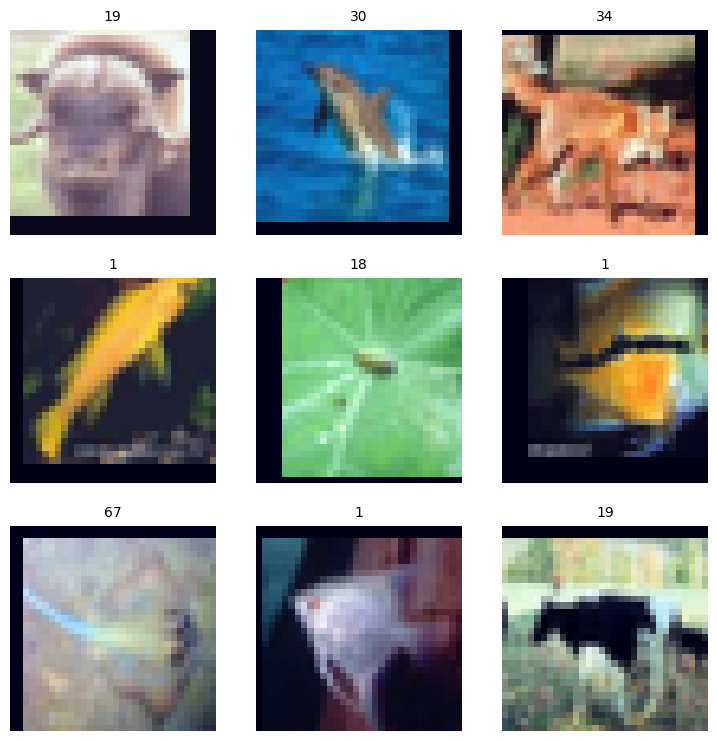

In [4]:
batch_gen = torch.utils.data.DataLoader(train_ds[0], 
                              batch_size=9, 
                              shuffle=True, 
                              num_workers=1,
                              )

for batch in batch_gen:
    sample = batch[0]
    target = batch[1]
    print(sample.shape)
    break

create_plot_images(sample_cpu=sample.numpy(), target=target.numpy())

In [ ]:
os.path.isfile('stop.txt')
# !dir

In [6]:
tasks = [i for i in range(n_split_experiences)]
acc_by_task = {i: 0 for i in range(n_split_experiences)}
results_diff_models = {}
best_model = {}
cms = {}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

for loop in range(9, 10):
    #loop=1
    if os.path.isfile('stop.txt'):
        print(f'You should continue from loop {loop}')
        break

    config = {
        "learning_rate": 0.00001,
        "weight_decay": 5.e-4,
        "batch_size": 64,
        "optimizer": "Adam",
        "architecture": "VGG19",
        "dataset": f'{dataset_name}',
        "epochs": 300,
        "lr_schedule": "ReduceLROnPlateau - Patience 4 - Monitoring Val Accuracy",
        "description": "Testing CIFAR-100 splited into 10 tasks."
    }
    wandb.init(
        # set the wandb project where this run will be logged
        project="cf-lora-cifar100-v2",
        name=f"vgg19-lr-00001-10tasks-lora-{loop}-2",
        
        # track hyperparameters and run metadata
        config=config
    )
    
    for model_type in ['vgg19']:
        bz=config['batch_size']
            
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(0)
        random.seed(0)
        np.random.seed(0)
                       
        model = models.vgg19_bn(weights="IMAGENET1K_V1")
        model.classifier[6] = nn.Linear(4096, total_number_classes)
        model = equip_vgg_with_lora(model, masks, total_number_classes)
        #model = convert_vgg_to_sena(model, masks, total_number_classes)
                
        print(f'model: {model_type}')
        
        for task in tasks:
            epoch_losses = {'train_acc': [], 'train_loss': [], 'test_acc': [], 'test_loss': []}
    
            model.to('cpu')
            model.change_to_task(task)
            model.to(device)
            print(40*'-', f'TASK_{task}', 40*'-')
        
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
            lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=4, verbose=True)
            
            early_stop = 0
            best_val = 0
            for i in range(config['epochs']):
                g = torch.Generator()
                g.manual_seed(0)
                batch_gen = torch.utils.data.DataLoader(train_ds[task], 
                                                      batch_size=config['batch_size'], 
                                                      shuffle=True, 
                                                      num_workers=1,
                                                      )
                print(f'Training task {task} in epoch {i}. Batch size: {bz}.')
                count = 0
                total_loss = .0
                total_hit = 0
                for batch in tqdm(batch_gen):
                    sample = batch[0].to(device)
                    target = batch[1]
                    target_onehot = F.one_hot(target, num_classes=total_number_classes).to(torch.float).to(device)
    
                    y_hat = model(sample)
        
                    # Compute the loss
                    loss_training = criterion(y_hat, target_onehot)            
                    
                    # Backpropagation and optimization
                    optimizer.zero_grad()
                    loss_training.backward()
                    optimizer.step()
                    
                    total_loss += loss_training
                    total_hit += sum(np.argmax(y_hat.cpu().detach().numpy(), axis=1) == target.numpy())
    
                    sample.to('cpu')
                    target_onehot.to('cpu')
                    del sample, target_onehot
                    gc.collect()
                    torch.cuda.empty_cache()
                    
                # Evaluate in test DS after each epoch
                with torch.no_grad():
                    batch_gen_test = torch.utils.data.DataLoader(test_ds[task], 
                                                      batch_size=config['batch_size'], 
                                                      shuffle=True, 
                                                      num_workers=1,
                                                      )
                    model.eval()
                    test_loss = 0.
                    acc = 0.
                    for batch_test in tqdm(batch_gen_test):
                        sample = batch_test[0].to(device)
                        target = batch_test[1]
                        target_onehot = F.one_hot(target, num_classes=total_number_classes).to(torch.float).to(device)
            
                        y_hat = model(sample)
                        cpu_inference = y_hat.argmax(axis=1)
                        
                        test_loss += criterion(y_hat, target_onehot)
                        acc += sum(cpu_inference.cpu() == target).item()
    
                        sample.to('cpu')
                        target_onehot.to('cpu')
                        del sample, target_onehot
                        gc.collect()
                        torch.cuda.empty_cache()
    
                    test_loss = (test_loss/len(batch_gen_test)).cpu()
                    acc = acc/len(test_ds[task])
                    lr_scheduler.step(acc)
                    model.train()
                
                epoch_losses['train_acc'].append(total_hit/(len(batch_gen)*bz))
                epoch_losses['train_loss'].append((total_loss/len(batch_gen)).cpu().item())
                
                epoch_losses['test_acc'].append(acc)
                epoch_losses['test_loss'].append(test_loss.item())
        
                # if acc > (best_val+0.01):
                if acc > (best_val):
                    model.to('cpu')
                    best_model[f'{model_type}-{task}'] = deepcopy(model)
                    model.to(device)
                    best_val = acc
                    early_stop = 0
        
                if early_stop > patience:
                    break
                
                early_stop += 1
    
                wandb.log({"train_acc": (total_hit/(len(batch_gen)*bz)), "train_loss": (total_loss/len(batch_gen)), 
                           "val_acc": acc, "val_loss": test_loss, "task": (task+1),
                           "Accuracy": acc, "Loss": test_loss, 
                           "patience": early_stop, "best_val_acc": best_val, "learning_rate": optimizer.param_groups[0]['lr']
                          })
                
                print(f'Trainig acc: {total_hit/(len(batch_gen)*bz):.4}   //   Training loss: {(total_loss/len(batch_gen)):.4f}   //   Test acc: {acc:.4f}   //   Test loss: {test_loss:.4f}')
                print(f'early_stop: {early_stop}  /   Best acc: {best_val}')
                del batch_gen, batch_gen_test
                gc.collect()
                torch.cuda.empty_cache()
    
            model.to('cpu')
            del model
            model = best_model[f'{model_type}-{task}']
            del best_model[f'{model_type}-{task}']
    
            gc.collect()
            torch.cuda.empty_cache()
            if task == 0:
                model.freeze_main_params()
            else:
                model.change_to_task(0)
            
            # results_diff_models[f'{model_type}-{task}'] = pd.DataFrame(epoch_losses)
    
            # del criterion, optimizer, lr_scheduler 
            gc.collect()
            torch.cuda.empty_cache()
    
        wandb.finish()

    # cm = ConfusionMatrix(num_classes=total_number_classes)
    # for task in tasks:
    #     model = best_model[f'{model_type}-{task}']
    #     model.eval()
            
    #     with torch.no_grad():
    #         batch_gen_test = torch.utils.data.DataLoader(test_ds[task], 
    #                                           batch_size=bz, 
    #                                           shuffle=True, 
    #                                           num_workers=1,
    #                                           )
    #         for batch_test in tqdm(batch_gen_test):
    #             sample = batch_test[0].to(device)
    #             target = batch_test[1]
    
    #             if model_type == 'pnn':
    #                 y_hat = model(sample, task_labels=task)
    #             else:
    #                 y_hat = model(sample)

    #             cpu_inference = y_hat.argmax(axis=1)
                
    #             cm.update(target, cpu_inference.cpu())
    
    # model.train()
    # cms[f'{model_type}'] = cm

wandb: Currently logged in as: everton (cf-lora). Use `wandb login --relogin` to force relogin


model: vgg19
[WARM] The model is already prepared to task 0.
---------------------------------------- TASK_0 ----------------------------------------
Training task 0 in epoch 0. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.34it/s]


Trainig acc: 0.1576   //   Training loss: 4.5320   //   Test acc: 0.2470   //   Test loss: 4.4096
early_stop: 1  /   Best acc: 0.247
Training task 0 in epoch 1. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


Trainig acc: 0.3198   //   Training loss: 4.3328   //   Test acc: 0.4120   //   Test loss: 4.2588
early_stop: 1  /   Best acc: 0.412
Training task 0 in epoch 2. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.4525   //   Training loss: 4.1953   //   Test acc: 0.5040   //   Test loss: 4.1425
early_stop: 1  /   Best acc: 0.504
Training task 0 in epoch 3. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.5113   //   Training loss: 4.1234   //   Test acc: 0.5340   //   Test loss: 4.0977
early_stop: 1  /   Best acc: 0.534
Training task 0 in epoch 4. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.5492   //   Training loss: 4.0788   //   Test acc: 0.5730   //   Test loss: 4.0592
early_stop: 1  /   Best acc: 0.573
Training task 0 in epoch 5. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.38it/s]


Trainig acc: 0.5949   //   Training loss: 4.0385   //   Test acc: 0.6350   //   Test loss: 4.0022
early_stop: 1  /   Best acc: 0.635
Training task 0 in epoch 6. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.6442   //   Training loss: 3.9835   //   Test acc: 0.6650   //   Test loss: 3.9687
early_stop: 1  /   Best acc: 0.665
Training task 0 in epoch 7. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.6958   //   Training loss: 3.9358   //   Test acc: 0.7140   //   Test loss: 3.9226
early_stop: 1  /   Best acc: 0.714
Training task 0 in epoch 8. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.73   //   Training loss: 3.8990   //   Test acc: 0.7390   //   Test loss: 3.8920
early_stop: 1  /   Best acc: 0.739
Training task 0 in epoch 9. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.35it/s]


Trainig acc: 0.7553   //   Training loss: 3.8703   //   Test acc: 0.7580   //   Test loss: 3.8742
early_stop: 1  /   Best acc: 0.758
Training task 0 in epoch 10. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.7793   //   Training loss: 3.8458   //   Test acc: 0.7720   //   Test loss: 3.8646
early_stop: 1  /   Best acc: 0.772
Training task 0 in epoch 11. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


Trainig acc: 0.7824   //   Training loss: 3.8388   //   Test acc: 0.7820   //   Test loss: 3.8482
early_stop: 1  /   Best acc: 0.782
Training task 0 in epoch 12. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.7977   //   Training loss: 3.8219   //   Test acc: 0.7850   //   Test loss: 3.8437
early_stop: 1  /   Best acc: 0.785
Training task 0 in epoch 13. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8111   //   Training loss: 3.8100   //   Test acc: 0.7890   //   Test loss: 3.8335
early_stop: 1  /   Best acc: 0.789
Training task 0 in epoch 14. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.34it/s]


Trainig acc: 0.8145   //   Training loss: 3.8038   //   Test acc: 0.8010   //   Test loss: 3.8266
early_stop: 1  /   Best acc: 0.801
Training task 0 in epoch 15. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8283   //   Training loss: 3.7884   //   Test acc: 0.8020   //   Test loss: 3.8251
early_stop: 1  /   Best acc: 0.802
Training task 0 in epoch 16. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8459   //   Training loss: 3.7774   //   Test acc: 0.8100   //   Test loss: 3.8211
early_stop: 1  /   Best acc: 0.81
Training task 0 in epoch 17. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.8329   //   Training loss: 3.7837   //   Test acc: 0.8120   //   Test loss: 3.8172
early_stop: 1  /   Best acc: 0.812
Training task 0 in epoch 18. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.41it/s]


Trainig acc: 0.8477   //   Training loss: 3.7683   //   Test acc: 0.8080   //   Test loss: 3.8154
early_stop: 2  /   Best acc: 0.812
Training task 0 in epoch 19. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.8513   //   Training loss: 3.7661   //   Test acc: 0.8180   //   Test loss: 3.8085
early_stop: 1  /   Best acc: 0.818
Training task 0 in epoch 20. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.861   //   Training loss: 3.7559   //   Test acc: 0.8210   //   Test loss: 3.8044
early_stop: 1  /   Best acc: 0.821
Training task 0 in epoch 21. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.8525   //   Training loss: 3.7620   //   Test acc: 0.8150   //   Test loss: 3.8091
early_stop: 2  /   Best acc: 0.821
Training task 0 in epoch 22. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8693   //   Training loss: 3.7472   //   Test acc: 0.8160   //   Test loss: 3.8069
early_stop: 3  /   Best acc: 0.821
Training task 0 in epoch 23. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.8633   //   Training loss: 3.7501   //   Test acc: 0.8350   //   Test loss: 3.7877
early_stop: 1  /   Best acc: 0.835
Training task 0 in epoch 24. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.8695   //   Training loss: 3.7473   //   Test acc: 0.8260   //   Test loss: 3.7974
early_stop: 2  /   Best acc: 0.835
Training task 0 in epoch 25. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8784   //   Training loss: 3.7405   //   Test acc: 0.8270   //   Test loss: 3.7971
early_stop: 3  /   Best acc: 0.835
Training task 0 in epoch 26. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.8827   //   Training loss: 3.7338   //   Test acc: 0.8200   //   Test loss: 3.8034
early_stop: 4  /   Best acc: 0.835
Training task 0 in epoch 27. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8809   //   Training loss: 3.7371   //   Test acc: 0.8240   //   Test loss: 3.8007
early_stop: 5  /   Best acc: 0.835
Training task 0 in epoch 28. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Epoch 00029: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.8884   //   Training loss: 3.7292   //   Test acc: 0.8310   //   Test loss: 3.7938
early_stop: 6  /   Best acc: 0.835
Training task 0 in epoch 29. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.8934   //   Training loss: 3.7244   //   Test acc: 0.8300   //   Test loss: 3.7929
early_stop: 7  /   Best acc: 0.835
Training task 0 in epoch 30. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.38it/s]


Trainig acc: 0.8904   //   Training loss: 3.7217   //   Test acc: 0.8390   //   Test loss: 3.7867
early_stop: 1  /   Best acc: 0.839
Training task 0 in epoch 31. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8851   //   Training loss: 3.7330   //   Test acc: 0.8270   //   Test loss: 3.7968
early_stop: 2  /   Best acc: 0.839
Training task 0 in epoch 32. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.8958   //   Training loss: 3.7202   //   Test acc: 0.8310   //   Test loss: 3.7910
early_stop: 3  /   Best acc: 0.839
Training task 0 in epoch 33. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8898   //   Training loss: 3.7281   //   Test acc: 0.8390   //   Test loss: 3.7888
early_stop: 4  /   Best acc: 0.839
Training task 0 in epoch 34. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.9023   //   Training loss: 3.7169   //   Test acc: 0.8340   //   Test loss: 3.7926
early_stop: 5  /   Best acc: 0.839
Training task 0 in epoch 35. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Epoch 00036: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.8934   //   Training loss: 3.7254   //   Test acc: 0.8350   //   Test loss: 3.7918
early_stop: 6  /   Best acc: 0.839
Training task 0 in epoch 36. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.894   //   Training loss: 3.7204   //   Test acc: 0.8360   //   Test loss: 3.7929
early_stop: 7  /   Best acc: 0.839
Training task 0 in epoch 37. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8924   //   Training loss: 3.7240   //   Test acc: 0.8290   //   Test loss: 3.7917
early_stop: 8  /   Best acc: 0.839
Training task 0 in epoch 38. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8926   //   Training loss: 3.7259   //   Test acc: 0.8390   //   Test loss: 3.7835
early_stop: 9  /   Best acc: 0.839
Training task 0 in epoch 39. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8964   //   Training loss: 3.7227   //   Test acc: 0.8310   //   Test loss: 3.7953
early_stop: 10  /   Best acc: 0.839
Training task 0 in epoch 40. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Epoch 00041: reducing learning rate of group 0 to 1.0000e-08.
Trainig acc: 0.8952   //   Training loss: 3.7220   //   Test acc: 0.8290   //   Test loss: 3.7923
early_stop: 11  /   Best acc: 0.839
Training task 0 in epoch 41. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.2132   //   Training loss: 4.5123   //   Test acc: 0.3540   //   Test loss: 4.3424
early_stop: 1  /   Best acc: 0.354
Training task 1 in epoch 1. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.4484   //   Training loss: 4.2295   //   Test acc: 0.5400   //   Test loss: 4.1397
early_stop: 1  /   Best acc: 0.54
Training task 1 in epoch 2. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.5744   //   Training loss: 4.0844   //   Test acc: 0.6210   //   Test loss: 4.0470
early_stop: 1  /   Best acc: 0.621
Training task 1 in epoch 3. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.6604   //   Training loss: 4.0025   //   Test acc: 0.6860   //   Test loss: 3.9762
early_stop: 1  /   Best acc: 0.686
Training task 1 in epoch 4. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.7097   //   Training loss: 3.9393   //   Test acc: 0.7450   //   Test loss: 3.9150
early_stop: 1  /   Best acc: 0.745
Training task 1 in epoch 5. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.7419   //   Training loss: 3.9063   //   Test acc: 0.7540   //   Test loss: 3.8912
early_stop: 1  /   Best acc: 0.754
Training task 1 in epoch 6. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.7636   //   Training loss: 3.8757   //   Test acc: 0.7650   //   Test loss: 3.8767
early_stop: 1  /   Best acc: 0.765
Training task 1 in epoch 7. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.7807   //   Training loss: 3.8554   //   Test acc: 0.7830   //   Test loss: 3.8536
early_stop: 1  /   Best acc: 0.783
Training task 1 in epoch 8. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.35it/s]


Trainig acc: 0.7791   //   Training loss: 3.8561   //   Test acc: 0.7840   //   Test loss: 3.8552
early_stop: 1  /   Best acc: 0.784
Training task 1 in epoch 9. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.7973   //   Training loss: 3.8342   //   Test acc: 0.8050   //   Test loss: 3.8365
early_stop: 1  /   Best acc: 0.805
Training task 1 in epoch 10. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8147   //   Training loss: 3.8155   //   Test acc: 0.7990   //   Test loss: 3.8337
early_stop: 2  /   Best acc: 0.805
Training task 1 in epoch 11. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.82   //   Training loss: 3.8132   //   Test acc: 0.8160   //   Test loss: 3.8177
early_stop: 1  /   Best acc: 0.816
Training task 1 in epoch 12. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8161   //   Training loss: 3.8122   //   Test acc: 0.8250   //   Test loss: 3.8142
early_stop: 1  /   Best acc: 0.825
Training task 1 in epoch 13. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


Trainig acc: 0.8309   //   Training loss: 3.7983   //   Test acc: 0.8150   //   Test loss: 3.8186
early_stop: 2  /   Best acc: 0.825
Training task 1 in epoch 14. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


Trainig acc: 0.8323   //   Training loss: 3.7914   //   Test acc: 0.8440   //   Test loss: 3.8019
early_stop: 1  /   Best acc: 0.844
Training task 1 in epoch 15. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.8339   //   Training loss: 3.7910   //   Test acc: 0.8400   //   Test loss: 3.7985
early_stop: 2  /   Best acc: 0.844
Training task 1 in epoch 16. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.36it/s]


Trainig acc: 0.8376   //   Training loss: 3.7893   //   Test acc: 0.8390   //   Test loss: 3.7942
early_stop: 3  /   Best acc: 0.844
Training task 1 in epoch 17. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.8493   //   Training loss: 3.7776   //   Test acc: 0.8450   //   Test loss: 3.7872
early_stop: 1  /   Best acc: 0.845
Training task 1 in epoch 18. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


Trainig acc: 0.8493   //   Training loss: 3.7746   //   Test acc: 0.8480   //   Test loss: 3.7847
early_stop: 1  /   Best acc: 0.848
Training task 1 in epoch 19. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.8542   //   Training loss: 3.7711   //   Test acc: 0.8510   //   Test loss: 3.7834
early_stop: 1  /   Best acc: 0.851
Training task 1 in epoch 20. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8532   //   Training loss: 3.7692   //   Test acc: 0.8480   //   Test loss: 3.7833
early_stop: 2  /   Best acc: 0.851
Training task 1 in epoch 21. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8617   //   Training loss: 3.7663   //   Test acc: 0.8600   //   Test loss: 3.7770
early_stop: 1  /   Best acc: 0.86
Training task 1 in epoch 22. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8693   //   Training loss: 3.7601   //   Test acc: 0.8580   //   Test loss: 3.7743
early_stop: 2  /   Best acc: 0.86
Training task 1 in epoch 23. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.8655   //   Training loss: 3.7550   //   Test acc: 0.8600   //   Test loss: 3.7759
early_stop: 3  /   Best acc: 0.86
Training task 1 in epoch 24. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Trainig acc: 0.8722   //   Training loss: 3.7523   //   Test acc: 0.8640   //   Test loss: 3.7690
early_stop: 1  /   Best acc: 0.864
Training task 1 in epoch 25. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.8766   //   Training loss: 3.7458   //   Test acc: 0.8630   //   Test loss: 3.7707
early_stop: 2  /   Best acc: 0.864
Training task 1 in epoch 26. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.875   //   Training loss: 3.7477   //   Test acc: 0.8740   //   Test loss: 3.7625
early_stop: 1  /   Best acc: 0.874
Training task 1 in epoch 27. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8813   //   Training loss: 3.7391   //   Test acc: 0.8750   //   Test loss: 3.7613
early_stop: 1  /   Best acc: 0.875
Training task 1 in epoch 28. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.8766   //   Training loss: 3.7486   //   Test acc: 0.8690   //   Test loss: 3.7633
early_stop: 2  /   Best acc: 0.875
Training task 1 in epoch 29. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.8827   //   Training loss: 3.7393   //   Test acc: 0.8680   //   Test loss: 3.7627
early_stop: 3  /   Best acc: 0.875
Training task 1 in epoch 30. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8849   //   Training loss: 3.7357   //   Test acc: 0.8740   //   Test loss: 3.7582
early_stop: 4  /   Best acc: 0.875
Training task 1 in epoch 31. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8843   //   Training loss: 3.7375   //   Test acc: 0.8680   //   Test loss: 3.7633
early_stop: 5  /   Best acc: 0.875
Training task 1 in epoch 32. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Epoch 00033: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.8912   //   Training loss: 3.7328   //   Test acc: 0.8740   //   Test loss: 3.7554
early_stop: 6  /   Best acc: 0.875
Training task 1 in epoch 33. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8906   //   Training loss: 3.7329   //   Test acc: 0.8710   //   Test loss: 3.7591
early_stop: 7  /   Best acc: 0.875
Training task 1 in epoch 34. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.8918   //   Training loss: 3.7296   //   Test acc: 0.8650   //   Test loss: 3.7632
early_stop: 8  /   Best acc: 0.875
Training task 1 in epoch 35. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8904   //   Training loss: 3.7298   //   Test acc: 0.8660   //   Test loss: 3.7654
early_stop: 9  /   Best acc: 0.875
Training task 1 in epoch 36. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8962   //   Training loss: 3.7266   //   Test acc: 0.8730   //   Test loss: 3.7586
early_stop: 10  /   Best acc: 0.875
Training task 1 in epoch 37. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.33it/s]


Epoch 00038: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.8871   //   Training loss: 3.7354   //   Test acc: 0.8710   //   Test loss: 3.7593
early_stop: 11  /   Best acc: 0.875
Training task 1 in epoch 38. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


[INFO] Model prepared to task 0.
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reini

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.2672   //   Training loss: 4.5109   //   Test acc: 0.4340   //   Test loss: 4.3190
early_stop: 1  /   Best acc: 0.434
Training task 2 in epoch 1. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.4816   //   Training loss: 4.1994   //   Test acc: 0.5910   //   Test loss: 4.1008
early_stop: 1  /   Best acc: 0.591
Training task 2 in epoch 2. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.5789   //   Training loss: 4.0857   //   Test acc: 0.6430   //   Test loss: 4.0203
early_stop: 1  /   Best acc: 0.643
Training task 2 in epoch 3. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.6294   //   Training loss: 4.0200   //   Test acc: 0.6630   //   Test loss: 3.9853
early_stop: 1  /   Best acc: 0.663
Training task 2 in epoch 4. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.6428   //   Training loss: 3.9926   //   Test acc: 0.6770   //   Test loss: 3.9644
early_stop: 1  /   Best acc: 0.677
Training task 2 in epoch 5. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.6574   //   Training loss: 3.9737   //   Test acc: 0.6690   //   Test loss: 3.9645
early_stop: 2  /   Best acc: 0.677
Training task 2 in epoch 6. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.6638   //   Training loss: 3.9664   //   Test acc: 0.6870   //   Test loss: 3.9466
early_stop: 1  /   Best acc: 0.687
Training task 2 in epoch 7. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.6863   //   Training loss: 3.9438   //   Test acc: 0.7000   //   Test loss: 3.9357
early_stop: 1  /   Best acc: 0.7
Training task 2 in epoch 8. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.7118   //   Training loss: 3.9258   //   Test acc: 0.7210   //   Test loss: 3.9136
early_stop: 1  /   Best acc: 0.721
Training task 2 in epoch 9. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Trainig acc: 0.7354   //   Training loss: 3.9025   //   Test acc: 0.7450   //   Test loss: 3.9011
early_stop: 1  /   Best acc: 0.745
Training task 2 in epoch 10. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.7433   //   Training loss: 3.8948   //   Test acc: 0.7600   //   Test loss: 3.8793
early_stop: 1  /   Best acc: 0.76
Training task 2 in epoch 11. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.7474   //   Training loss: 3.8825   //   Test acc: 0.7710   //   Test loss: 3.8657
early_stop: 1  /   Best acc: 0.771
Training task 2 in epoch 12. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.57it/s]


Trainig acc: 0.7765   //   Training loss: 3.8539   //   Test acc: 0.7730   //   Test loss: 3.8623
early_stop: 1  /   Best acc: 0.773
Training task 2 in epoch 13. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.61it/s]


Trainig acc: 0.783   //   Training loss: 3.8452   //   Test acc: 0.7850   //   Test loss: 3.8567
early_stop: 1  /   Best acc: 0.785
Training task 2 in epoch 14. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Trainig acc: 0.7888   //   Training loss: 3.8446   //   Test acc: 0.7790   //   Test loss: 3.8514
early_stop: 2  /   Best acc: 0.785
Training task 2 in epoch 15. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.7929   //   Training loss: 3.8335   //   Test acc: 0.7900   //   Test loss: 3.8433
early_stop: 1  /   Best acc: 0.79
Training task 2 in epoch 16. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.56it/s]


Trainig acc: 0.7892   //   Training loss: 3.8351   //   Test acc: 0.7930   //   Test loss: 3.8386
early_stop: 1  /   Best acc: 0.793
Training task 2 in epoch 17. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.7996   //   Training loss: 3.8307   //   Test acc: 0.7990   //   Test loss: 3.8304
early_stop: 1  /   Best acc: 0.799
Training task 2 in epoch 18. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.8113   //   Training loss: 3.8140   //   Test acc: 0.8020   //   Test loss: 3.8289
early_stop: 1  /   Best acc: 0.802
Training task 2 in epoch 19. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


Trainig acc: 0.8149   //   Training loss: 3.8103   //   Test acc: 0.8070   //   Test loss: 3.8247
early_stop: 1  /   Best acc: 0.807
Training task 2 in epoch 20. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.58it/s]


Trainig acc: 0.8236   //   Training loss: 3.8025   //   Test acc: 0.8090   //   Test loss: 3.8237
early_stop: 1  /   Best acc: 0.809
Training task 2 in epoch 21. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.56it/s]


Trainig acc: 0.8208   //   Training loss: 3.8039   //   Test acc: 0.8070   //   Test loss: 3.8197
early_stop: 2  /   Best acc: 0.809
Training task 2 in epoch 22. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.56it/s]


Trainig acc: 0.8259   //   Training loss: 3.7969   //   Test acc: 0.8140   //   Test loss: 3.8154
early_stop: 1  /   Best acc: 0.814
Training task 2 in epoch 23. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.59it/s]


Trainig acc: 0.8242   //   Training loss: 3.7977   //   Test acc: 0.8250   //   Test loss: 3.8111
early_stop: 1  /   Best acc: 0.825
Training task 2 in epoch 24. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Trainig acc: 0.8335   //   Training loss: 3.7904   //   Test acc: 0.8150   //   Test loss: 3.8149
early_stop: 2  /   Best acc: 0.825
Training task 2 in epoch 25. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.8348   //   Training loss: 3.7858   //   Test acc: 0.8200   //   Test loss: 3.8086
early_stop: 3  /   Best acc: 0.825
Training task 2 in epoch 26. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.8463   //   Training loss: 3.7764   //   Test acc: 0.8200   //   Test loss: 3.8098
early_stop: 4  /   Best acc: 0.825
Training task 2 in epoch 27. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.8388   //   Training loss: 3.7805   //   Test acc: 0.8280   //   Test loss: 3.8047
early_stop: 1  /   Best acc: 0.828
Training task 2 in epoch 28. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.8461   //   Training loss: 3.7763   //   Test acc: 0.8200   //   Test loss: 3.8032
early_stop: 2  /   Best acc: 0.828
Training task 2 in epoch 29. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.8497   //   Training loss: 3.7731   //   Test acc: 0.8220   //   Test loss: 3.8024
early_stop: 3  /   Best acc: 0.828
Training task 2 in epoch 30. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.854   //   Training loss: 3.7641   //   Test acc: 0.8270   //   Test loss: 3.8047
early_stop: 4  /   Best acc: 0.828
Training task 2 in epoch 31. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.8479   //   Training loss: 3.7728   //   Test acc: 0.8310   //   Test loss: 3.7983
early_stop: 1  /   Best acc: 0.831
Training task 2 in epoch 32. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.53it/s]


Trainig acc: 0.857   //   Training loss: 3.7657   //   Test acc: 0.8250   //   Test loss: 3.8059
early_stop: 2  /   Best acc: 0.831
Training task 2 in epoch 33. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.59it/s]


Trainig acc: 0.8661   //   Training loss: 3.7573   //   Test acc: 0.8240   //   Test loss: 3.8031
early_stop: 3  /   Best acc: 0.831
Training task 2 in epoch 34. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.56it/s]


Trainig acc: 0.8625   //   Training loss: 3.7582   //   Test acc: 0.8250   //   Test loss: 3.8025
early_stop: 4  /   Best acc: 0.831
Training task 2 in epoch 35. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.59it/s]


Trainig acc: 0.858   //   Training loss: 3.7641   //   Test acc: 0.8270   //   Test loss: 3.7968
early_stop: 5  /   Best acc: 0.831
Training task 2 in epoch 36. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Epoch 00037: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.8671   //   Training loss: 3.7535   //   Test acc: 0.8250   //   Test loss: 3.8004
early_stop: 6  /   Best acc: 0.831
Training task 2 in epoch 37. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.8748   //   Training loss: 3.7461   //   Test acc: 0.8310   //   Test loss: 3.8000
early_stop: 7  /   Best acc: 0.831
Training task 2 in epoch 38. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


Trainig acc: 0.8697   //   Training loss: 3.7488   //   Test acc: 0.8280   //   Test loss: 3.7964
early_stop: 8  /   Best acc: 0.831
Training task 2 in epoch 39. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.43it/s]


Trainig acc: 0.8685   //   Training loss: 3.7521   //   Test acc: 0.8200   //   Test loss: 3.8030
early_stop: 9  /   Best acc: 0.831
Training task 2 in epoch 40. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Trainig acc: 0.8663   //   Training loss: 3.7574   //   Test acc: 0.8270   //   Test loss: 3.8014
early_stop: 10  /   Best acc: 0.831
Training task 2 in epoch 41. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.57it/s]


Epoch 00042: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.871   //   Training loss: 3.7484   //   Test acc: 0.8290   //   Test loss: 3.7982
early_stop: 11  /   Best acc: 0.831
Training task 2 in epoch 42. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.8732   //   Training loss: 3.7483   //   Test acc: 0.8330   //   Test loss: 3.7956
early_stop: 1  /   Best acc: 0.833
Training task 2 in epoch 43. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.872   //   Training loss: 3.7497   //   Test acc: 0.8300   //   Test loss: 3.7944
early_stop: 2  /   Best acc: 0.833
Training task 2 in epoch 44. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.58it/s]


Trainig acc: 0.8586   //   Training loss: 3.7610   //   Test acc: 0.8290   //   Test loss: 3.7979
early_stop: 3  /   Best acc: 0.833
Training task 2 in epoch 45. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Trainig acc: 0.8608   //   Training loss: 3.7620   //   Test acc: 0.8300   //   Test loss: 3.7950
early_stop: 4  /   Best acc: 0.833
Training task 2 in epoch 46. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.61it/s]


Trainig acc: 0.8712   //   Training loss: 3.7536   //   Test acc: 0.8300   //   Test loss: 3.7954
early_stop: 5  /   Best acc: 0.833
Training task 2 in epoch 47. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Epoch 00048: reducing learning rate of group 0 to 1.0000e-08.
Trainig acc: 0.876   //   Training loss: 3.7474   //   Test acc: 0.8250   //   Test loss: 3.7996
early_stop: 6  /   Best acc: 0.833
Training task 2 in epoch 48. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Trainig acc: 0.8657   //   Training loss: 3.7557   //   Test acc: 0.8200   //   Test loss: 3.8024
early_stop: 7  /   Best acc: 0.833
Training task 2 in epoch 49. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.8631   //   Training loss: 3.7603   //   Test acc: 0.8240   //   Test loss: 3.8018
early_stop: 8  /   Best acc: 0.833
Training task 2 in epoch 50. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Trainig acc: 0.8708   //   Training loss: 3.7516   //   Test acc: 0.8260   //   Test loss: 3.7991
early_stop: 9  /   Best acc: 0.833
Training task 2 in epoch 51. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.8647   //   Training loss: 3.7561   //   Test acc: 0.8300   //   Test loss: 3.7984
early_stop: 10  /   Best acc: 0.833
Training task 2 in epoch 52. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.8728   //   Training loss: 3.7509   //   Test acc: 0.8250   //   Test loss: 3.7991
early_stop: 11  /   Best acc: 0.833
Training task 2 in epoch 53. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


[INFO] Model prepared to task 0.
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reini

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Trainig acc: 0.247   //   Training loss: 4.5107   //   Test acc: 0.4160   //   Test loss: 4.3359
early_stop: 1  /   Best acc: 0.416
Training task 3 in epoch 1. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.4814   //   Training loss: 4.2165   //   Test acc: 0.6040   //   Test loss: 4.0901
early_stop: 1  /   Best acc: 0.604
Training task 3 in epoch 2. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


Trainig acc: 0.6214   //   Training loss: 4.0515   //   Test acc: 0.6980   //   Test loss: 3.9693
early_stop: 1  /   Best acc: 0.698
Training task 3 in epoch 3. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.679   //   Training loss: 3.9747   //   Test acc: 0.7360   //   Test loss: 3.9248
early_stop: 1  /   Best acc: 0.736
Training task 3 in epoch 4. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.731   //   Training loss: 3.9204   //   Test acc: 0.7690   //   Test loss: 3.8807
early_stop: 1  /   Best acc: 0.769
Training task 3 in epoch 5. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.69it/s]


Trainig acc: 0.7627   //   Training loss: 3.8801   //   Test acc: 0.7990   //   Test loss: 3.8521
early_stop: 1  /   Best acc: 0.799
Training task 3 in epoch 6. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.59it/s]


Trainig acc: 0.7787   //   Training loss: 3.8580   //   Test acc: 0.7990   //   Test loss: 3.8379
early_stop: 2  /   Best acc: 0.799
Training task 3 in epoch 7. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.63it/s]


Trainig acc: 0.7913   //   Training loss: 3.8401   //   Test acc: 0.8120   //   Test loss: 3.8220
early_stop: 1  /   Best acc: 0.812
Training task 3 in epoch 8. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.8008   //   Training loss: 3.8312   //   Test acc: 0.8120   //   Test loss: 3.8169
early_stop: 2  /   Best acc: 0.812
Training task 3 in epoch 9. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.57it/s]


Trainig acc: 0.8105   //   Training loss: 3.8207   //   Test acc: 0.8390   //   Test loss: 3.7975
early_stop: 1  /   Best acc: 0.839
Training task 3 in epoch 10. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


Trainig acc: 0.8238   //   Training loss: 3.8071   //   Test acc: 0.8340   //   Test loss: 3.7964
early_stop: 2  /   Best acc: 0.839
Training task 3 in epoch 11. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Trainig acc: 0.8301   //   Training loss: 3.8017   //   Test acc: 0.8420   //   Test loss: 3.7961
early_stop: 1  /   Best acc: 0.842
Training task 3 in epoch 12. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.8267   //   Training loss: 3.8010   //   Test acc: 0.8400   //   Test loss: 3.7932
early_stop: 2  /   Best acc: 0.842
Training task 3 in epoch 13. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.8329   //   Training loss: 3.7917   //   Test acc: 0.8490   //   Test loss: 3.7872
early_stop: 1  /   Best acc: 0.849
Training task 3 in epoch 14. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.53it/s]


Trainig acc: 0.8347   //   Training loss: 3.7903   //   Test acc: 0.8520   //   Test loss: 3.7836
early_stop: 1  /   Best acc: 0.852
Training task 3 in epoch 15. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.8455   //   Training loss: 3.7827   //   Test acc: 0.8540   //   Test loss: 3.7766
early_stop: 1  /   Best acc: 0.854
Training task 3 in epoch 16. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.8483   //   Training loss: 3.7738   //   Test acc: 0.8490   //   Test loss: 3.7804
early_stop: 2  /   Best acc: 0.854
Training task 3 in epoch 17. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.57it/s]


Trainig acc: 0.8455   //   Training loss: 3.7772   //   Test acc: 0.8540   //   Test loss: 3.7780
early_stop: 3  /   Best acc: 0.854
Training task 3 in epoch 18. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.63it/s]


Trainig acc: 0.8562   //   Training loss: 3.7676   //   Test acc: 0.8520   //   Test loss: 3.7828
early_stop: 4  /   Best acc: 0.854
Training task 3 in epoch 19. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.8604   //   Training loss: 3.7658   //   Test acc: 0.8560   //   Test loss: 3.7699
early_stop: 1  /   Best acc: 0.856
Training task 3 in epoch 20. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Trainig acc: 0.8546   //   Training loss: 3.7660   //   Test acc: 0.8520   //   Test loss: 3.7738
early_stop: 2  /   Best acc: 0.856
Training task 3 in epoch 21. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.8637   //   Training loss: 3.7581   //   Test acc: 0.8580   //   Test loss: 3.7692
early_stop: 1  /   Best acc: 0.858
Training task 3 in epoch 22. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


Trainig acc: 0.8637   //   Training loss: 3.7594   //   Test acc: 0.8590   //   Test loss: 3.7726
early_stop: 1  /   Best acc: 0.859
Training task 3 in epoch 23. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.8621   //   Training loss: 3.7597   //   Test acc: 0.8630   //   Test loss: 3.7642
early_stop: 1  /   Best acc: 0.863
Training task 3 in epoch 24. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.53it/s]


Trainig acc: 0.8633   //   Training loss: 3.7600   //   Test acc: 0.8660   //   Test loss: 3.7634
early_stop: 1  /   Best acc: 0.866
Training task 3 in epoch 25. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.8712   //   Training loss: 3.7531   //   Test acc: 0.8540   //   Test loss: 3.7707
early_stop: 2  /   Best acc: 0.866
Training task 3 in epoch 26. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.53it/s]


Trainig acc: 0.8732   //   Training loss: 3.7480   //   Test acc: 0.8640   //   Test loss: 3.7622
early_stop: 3  /   Best acc: 0.866
Training task 3 in epoch 27. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]


Trainig acc: 0.8792   //   Training loss: 3.7422   //   Test acc: 0.8640   //   Test loss: 3.7650
early_stop: 4  /   Best acc: 0.866
Training task 3 in epoch 28. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.873   //   Training loss: 3.7511   //   Test acc: 0.8700   //   Test loss: 3.7622
early_stop: 1  /   Best acc: 0.87
Training task 3 in epoch 29. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


Trainig acc: 0.8847   //   Training loss: 3.7399   //   Test acc: 0.8620   //   Test loss: 3.7671
early_stop: 2  /   Best acc: 0.87
Training task 3 in epoch 30. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.8809   //   Training loss: 3.7403   //   Test acc: 0.8820   //   Test loss: 3.7503
early_stop: 1  /   Best acc: 0.882
Training task 3 in epoch 31. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.8703   //   Training loss: 3.7485   //   Test acc: 0.8750   //   Test loss: 3.7559
early_stop: 2  /   Best acc: 0.882
Training task 3 in epoch 32. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.56it/s]


Trainig acc: 0.8859   //   Training loss: 3.7361   //   Test acc: 0.8730   //   Test loss: 3.7557
early_stop: 3  /   Best acc: 0.882
Training task 3 in epoch 33. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.68it/s]


Trainig acc: 0.8857   //   Training loss: 3.7377   //   Test acc: 0.8790   //   Test loss: 3.7486
early_stop: 4  /   Best acc: 0.882
Training task 3 in epoch 34. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.53it/s]


Trainig acc: 0.8924   //   Training loss: 3.7291   //   Test acc: 0.8820   //   Test loss: 3.7490
early_stop: 5  /   Best acc: 0.882
Training task 3 in epoch 35. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Epoch 00036: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.8906   //   Training loss: 3.7303   //   Test acc: 0.8720   //   Test loss: 3.7533
early_stop: 6  /   Best acc: 0.882
Training task 3 in epoch 36. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.8914   //   Training loss: 3.7281   //   Test acc: 0.8760   //   Test loss: 3.7535
early_stop: 7  /   Best acc: 0.882
Training task 3 in epoch 37. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.58it/s]


Trainig acc: 0.8952   //   Training loss: 3.7236   //   Test acc: 0.8800   //   Test loss: 3.7475
early_stop: 8  /   Best acc: 0.882
Training task 3 in epoch 38. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]


Trainig acc: 0.8934   //   Training loss: 3.7302   //   Test acc: 0.8750   //   Test loss: 3.7526
early_stop: 9  /   Best acc: 0.882
Training task 3 in epoch 39. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.8966   //   Training loss: 3.7268   //   Test acc: 0.8740   //   Test loss: 3.7513
early_stop: 10  /   Best acc: 0.882
Training task 3 in epoch 40. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.56it/s]


Epoch 00041: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.8985   //   Training loss: 3.7253   //   Test acc: 0.8820   //   Test loss: 3.7469
early_stop: 11  /   Best acc: 0.882
Training task 3 in epoch 41. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


[INFO] Model prepared to task 0.
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reini

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.60it/s]


Trainig acc: 0.2338   //   Training loss: 4.5059   //   Test acc: 0.3770   //   Test loss: 4.3217
early_stop: 1  /   Best acc: 0.377
Training task 4 in epoch 1. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


Trainig acc: 0.4328   //   Training loss: 4.2267   //   Test acc: 0.5160   //   Test loss: 4.1593
early_stop: 1  /   Best acc: 0.516
Training task 4 in epoch 2. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.5451   //   Training loss: 4.1135   //   Test acc: 0.5780   //   Test loss: 4.0707
early_stop: 1  /   Best acc: 0.578
Training task 4 in epoch 3. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.5953   //   Training loss: 4.0526   //   Test acc: 0.6330   //   Test loss: 4.0190
early_stop: 1  /   Best acc: 0.633
Training task 4 in epoch 4. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.6527   //   Training loss: 4.0019   //   Test acc: 0.6700   //   Test loss: 3.9735
early_stop: 1  /   Best acc: 0.67
Training task 4 in epoch 5. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.6768   //   Training loss: 3.9651   //   Test acc: 0.6940   //   Test loss: 3.9498
early_stop: 1  /   Best acc: 0.694
Training task 4 in epoch 6. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.6988   //   Training loss: 3.9349   //   Test acc: 0.7100   //   Test loss: 3.9308
early_stop: 1  /   Best acc: 0.71
Training task 4 in epoch 7. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.7118   //   Training loss: 3.9213   //   Test acc: 0.7240   //   Test loss: 3.9166
early_stop: 1  /   Best acc: 0.724
Training task 4 in epoch 8. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.7255   //   Training loss: 3.9037   //   Test acc: 0.7170   //   Test loss: 3.9074
early_stop: 2  /   Best acc: 0.724
Training task 4 in epoch 9. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.7375   //   Training loss: 3.8948   //   Test acc: 0.7270   //   Test loss: 3.8970
early_stop: 1  /   Best acc: 0.727
Training task 4 in epoch 10. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.58it/s]


Trainig acc: 0.753   //   Training loss: 3.8778   //   Test acc: 0.7500   //   Test loss: 3.8822
early_stop: 1  /   Best acc: 0.75
Training task 4 in epoch 11. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.7656   //   Training loss: 3.8673   //   Test acc: 0.7700   //   Test loss: 3.8695
early_stop: 1  /   Best acc: 0.77
Training task 4 in epoch 12. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.42it/s]


Trainig acc: 0.7737   //   Training loss: 3.8563   //   Test acc: 0.7740   //   Test loss: 3.8642
early_stop: 1  /   Best acc: 0.774
Training task 4 in epoch 13. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]


Trainig acc: 0.785   //   Training loss: 3.8454   //   Test acc: 0.7870   //   Test loss: 3.8440
early_stop: 1  /   Best acc: 0.787
Training task 4 in epoch 14. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.39it/s]


Trainig acc: 0.7903   //   Training loss: 3.8367   //   Test acc: 0.7840   //   Test loss: 3.8480
early_stop: 2  /   Best acc: 0.787
Training task 4 in epoch 15. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.8002   //   Training loss: 3.8261   //   Test acc: 0.8040   //   Test loss: 3.8365
early_stop: 1  /   Best acc: 0.804
Training task 4 in epoch 16. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Trainig acc: 0.8066   //   Training loss: 3.8208   //   Test acc: 0.8030   //   Test loss: 3.8278
early_stop: 2  /   Best acc: 0.804
Training task 4 in epoch 17. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.56it/s]


Trainig acc: 0.8109   //   Training loss: 3.8169   //   Test acc: 0.8010   //   Test loss: 3.8296
early_stop: 3  /   Best acc: 0.804
Training task 4 in epoch 18. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.8202   //   Training loss: 3.8057   //   Test acc: 0.8090   //   Test loss: 3.8206
early_stop: 1  /   Best acc: 0.809
Training task 4 in epoch 19. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]


Trainig acc: 0.8244   //   Training loss: 3.8029   //   Test acc: 0.8020   //   Test loss: 3.8267
early_stop: 2  /   Best acc: 0.809
Training task 4 in epoch 20. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.65it/s]


Trainig acc: 0.8224   //   Training loss: 3.8008   //   Test acc: 0.8150   //   Test loss: 3.8153
early_stop: 1  /   Best acc: 0.815
Training task 4 in epoch 21. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.66it/s]


Trainig acc: 0.8246   //   Training loss: 3.7993   //   Test acc: 0.8210   //   Test loss: 3.8106
early_stop: 1  /   Best acc: 0.821
Training task 4 in epoch 22. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.8311   //   Training loss: 3.7932   //   Test acc: 0.8180   //   Test loss: 3.8090
early_stop: 2  /   Best acc: 0.821
Training task 4 in epoch 23. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.8358   //   Training loss: 3.7847   //   Test acc: 0.8410   //   Test loss: 3.7992
early_stop: 1  /   Best acc: 0.841
Training task 4 in epoch 24. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.37it/s]


Trainig acc: 0.837   //   Training loss: 3.7859   //   Test acc: 0.8180   //   Test loss: 3.8128
early_stop: 2  /   Best acc: 0.841
Training task 4 in epoch 25. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.8372   //   Training loss: 3.7839   //   Test acc: 0.8250   //   Test loss: 3.8036
early_stop: 3  /   Best acc: 0.841
Training task 4 in epoch 26. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Trainig acc: 0.8447   //   Training loss: 3.7792   //   Test acc: 0.8360   //   Test loss: 3.8018
early_stop: 4  /   Best acc: 0.841
Training task 4 in epoch 27. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Trainig acc: 0.8443   //   Training loss: 3.7764   //   Test acc: 0.8240   //   Test loss: 3.8052
early_stop: 5  /   Best acc: 0.841
Training task 4 in epoch 28. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Epoch 00029: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.8461   //   Training loss: 3.7733   //   Test acc: 0.8320   //   Test loss: 3.7987
early_stop: 6  /   Best acc: 0.841
Training task 4 in epoch 29. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.57it/s]


Trainig acc: 0.8576   //   Training loss: 3.7685   //   Test acc: 0.8290   //   Test loss: 3.7998
early_stop: 7  /   Best acc: 0.841
Training task 4 in epoch 30. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Trainig acc: 0.8513   //   Training loss: 3.7722   //   Test acc: 0.8390   //   Test loss: 3.7956
early_stop: 8  /   Best acc: 0.841
Training task 4 in epoch 31. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


Trainig acc: 0.8527   //   Training loss: 3.7730   //   Test acc: 0.8330   //   Test loss: 3.7998
early_stop: 9  /   Best acc: 0.841
Training task 4 in epoch 32. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.8548   //   Training loss: 3.7678   //   Test acc: 0.8250   //   Test loss: 3.8070
early_stop: 10  /   Best acc: 0.841
Training task 4 in epoch 33. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.63it/s]


Epoch 00034: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.8495   //   Training loss: 3.7739   //   Test acc: 0.8230   //   Test loss: 3.8085
early_stop: 11  /   Best acc: 0.841
Training task 4 in epoch 34. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


[INFO] Model prepared to task 0.
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reini

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.74it/s]


Trainig acc: 0.2221   //   Training loss: 4.4965   //   Test acc: 0.3840   //   Test loss: 4.3037
early_stop: 1  /   Best acc: 0.384
Training task 5 in epoch 1. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


Trainig acc: 0.4462   //   Training loss: 4.2161   //   Test acc: 0.5350   //   Test loss: 4.1292
early_stop: 1  /   Best acc: 0.535
Training task 5 in epoch 2. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.42it/s]


Trainig acc: 0.569   //   Training loss: 4.0972   //   Test acc: 0.6440   //   Test loss: 4.0327
early_stop: 1  /   Best acc: 0.644
Training task 5 in epoch 3. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]


Trainig acc: 0.658   //   Training loss: 4.0037   //   Test acc: 0.6840   //   Test loss: 3.9642
early_stop: 1  /   Best acc: 0.684
Training task 5 in epoch 4. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.6988   //   Training loss: 3.9493   //   Test acc: 0.7360   //   Test loss: 3.9191
early_stop: 1  /   Best acc: 0.736
Training task 5 in epoch 5. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


Trainig acc: 0.7273   //   Training loss: 3.9154   //   Test acc: 0.7650   //   Test loss: 3.8902
early_stop: 1  /   Best acc: 0.765
Training task 5 in epoch 6. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Trainig acc: 0.7569   //   Training loss: 3.8853   //   Test acc: 0.7820   //   Test loss: 3.8612
early_stop: 1  /   Best acc: 0.782
Training task 5 in epoch 7. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


Trainig acc: 0.7688   //   Training loss: 3.8632   //   Test acc: 0.7780   //   Test loss: 3.8542
early_stop: 2  /   Best acc: 0.782
Training task 5 in epoch 8. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.7763   //   Training loss: 3.8558   //   Test acc: 0.7930   //   Test loss: 3.8427
early_stop: 1  /   Best acc: 0.793
Training task 5 in epoch 9. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.7925   //   Training loss: 3.8397   //   Test acc: 0.8020   //   Test loss: 3.8307
early_stop: 1  /   Best acc: 0.802
Training task 5 in epoch 10. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.7981   //   Training loss: 3.8287   //   Test acc: 0.8070   //   Test loss: 3.8234
early_stop: 1  /   Best acc: 0.807
Training task 5 in epoch 11. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.43it/s]


Trainig acc: 0.8157   //   Training loss: 3.8187   //   Test acc: 0.8130   //   Test loss: 3.8194
early_stop: 1  /   Best acc: 0.813
Training task 5 in epoch 12. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.808   //   Training loss: 3.8199   //   Test acc: 0.8190   //   Test loss: 3.8119
early_stop: 1  /   Best acc: 0.819
Training task 5 in epoch 13. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


Trainig acc: 0.8167   //   Training loss: 3.8101   //   Test acc: 0.8090   //   Test loss: 3.8199
early_stop: 2  /   Best acc: 0.819
Training task 5 in epoch 14. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


Trainig acc: 0.818   //   Training loss: 3.8089   //   Test acc: 0.8200   //   Test loss: 3.8082
early_stop: 1  /   Best acc: 0.82
Training task 5 in epoch 15. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


Trainig acc: 0.8261   //   Training loss: 3.7988   //   Test acc: 0.8290   //   Test loss: 3.7985
early_stop: 1  /   Best acc: 0.829
Training task 5 in epoch 16. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.53it/s]


Trainig acc: 0.8356   //   Training loss: 3.7902   //   Test acc: 0.8210   //   Test loss: 3.8076
early_stop: 2  /   Best acc: 0.829
Training task 5 in epoch 17. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.8414   //   Training loss: 3.7832   //   Test acc: 0.8320   //   Test loss: 3.7993
early_stop: 1  /   Best acc: 0.832
Training task 5 in epoch 18. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.835   //   Training loss: 3.7885   //   Test acc: 0.8260   //   Test loss: 3.7959
early_stop: 2  /   Best acc: 0.832
Training task 5 in epoch 19. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.8499   //   Training loss: 3.7781   //   Test acc: 0.8400   //   Test loss: 3.7962
early_stop: 1  /   Best acc: 0.84
Training task 5 in epoch 20. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Trainig acc: 0.8467   //   Training loss: 3.7751   //   Test acc: 0.8320   //   Test loss: 3.7931
early_stop: 2  /   Best acc: 0.84
Training task 5 in epoch 21. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


Trainig acc: 0.8443   //   Training loss: 3.7795   //   Test acc: 0.8230   //   Test loss: 3.7980
early_stop: 3  /   Best acc: 0.84
Training task 5 in epoch 22. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.8519   //   Training loss: 3.7737   //   Test acc: 0.8410   //   Test loss: 3.7845
early_stop: 1  /   Best acc: 0.841
Training task 5 in epoch 23. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.8633   //   Training loss: 3.7593   //   Test acc: 0.8370   //   Test loss: 3.7905
early_stop: 2  /   Best acc: 0.841
Training task 5 in epoch 24. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.86   //   Training loss: 3.7634   //   Test acc: 0.8490   //   Test loss: 3.7847
early_stop: 1  /   Best acc: 0.849
Training task 5 in epoch 25. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]


Trainig acc: 0.8612   //   Training loss: 3.7600   //   Test acc: 0.8450   //   Test loss: 3.7829
early_stop: 2  /   Best acc: 0.849
Training task 5 in epoch 26. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.60it/s]


Trainig acc: 0.8643   //   Training loss: 3.7612   //   Test acc: 0.8500   //   Test loss: 3.7773
early_stop: 1  /   Best acc: 0.85
Training task 5 in epoch 27. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Trainig acc: 0.8675   //   Training loss: 3.7566   //   Test acc: 0.8520   //   Test loss: 3.7768
early_stop: 1  /   Best acc: 0.852
Training task 5 in epoch 28. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


Trainig acc: 0.8625   //   Training loss: 3.7618   //   Test acc: 0.8460   //   Test loss: 3.7805
early_stop: 2  /   Best acc: 0.852
Training task 5 in epoch 29. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Trainig acc: 0.8689   //   Training loss: 3.7524   //   Test acc: 0.8500   //   Test loss: 3.7782
early_stop: 3  /   Best acc: 0.852
Training task 5 in epoch 30. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.58it/s]


Trainig acc: 0.8738   //   Training loss: 3.7502   //   Test acc: 0.8600   //   Test loss: 3.7727
early_stop: 1  /   Best acc: 0.86
Training task 5 in epoch 31. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.8693   //   Training loss: 3.7595   //   Test acc: 0.8510   //   Test loss: 3.7748
early_stop: 2  /   Best acc: 0.86
Training task 5 in epoch 32. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.8754   //   Training loss: 3.7452   //   Test acc: 0.8470   //   Test loss: 3.7787
early_stop: 3  /   Best acc: 0.86
Training task 5 in epoch 33. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Trainig acc: 0.8799   //   Training loss: 3.7464   //   Test acc: 0.8590   //   Test loss: 3.7706
early_stop: 4  /   Best acc: 0.86
Training task 5 in epoch 34. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]


Trainig acc: 0.8805   //   Training loss: 3.7435   //   Test acc: 0.8560   //   Test loss: 3.7722
early_stop: 5  /   Best acc: 0.86
Training task 5 in epoch 35. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.43it/s]


Trainig acc: 0.8736   //   Training loss: 3.7486   //   Test acc: 0.8640   //   Test loss: 3.7666
early_stop: 1  /   Best acc: 0.864
Training task 5 in epoch 36. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.43it/s]


Trainig acc: 0.8778   //   Training loss: 3.7449   //   Test acc: 0.8580   //   Test loss: 3.7723
early_stop: 2  /   Best acc: 0.864
Training task 5 in epoch 37. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.8851   //   Training loss: 3.7380   //   Test acc: 0.8630   //   Test loss: 3.7648
early_stop: 3  /   Best acc: 0.864
Training task 5 in epoch 38. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.62it/s]


Trainig acc: 0.8843   //   Training loss: 3.7360   //   Test acc: 0.8710   //   Test loss: 3.7632
early_stop: 1  /   Best acc: 0.871
Training task 5 in epoch 39. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.64it/s]


Trainig acc: 0.8892   //   Training loss: 3.7330   //   Test acc: 0.8510   //   Test loss: 3.7721
early_stop: 2  /   Best acc: 0.871
Training task 5 in epoch 40. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.61it/s]


Trainig acc: 0.8855   //   Training loss: 3.7353   //   Test acc: 0.8660   //   Test loss: 3.7619
early_stop: 3  /   Best acc: 0.871
Training task 5 in epoch 41. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.893   //   Training loss: 3.7338   //   Test acc: 0.8680   //   Test loss: 3.7652
early_stop: 4  /   Best acc: 0.871
Training task 5 in epoch 42. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


Trainig acc: 0.895   //   Training loss: 3.7265   //   Test acc: 0.8710   //   Test loss: 3.7603
early_stop: 5  /   Best acc: 0.871
Training task 5 in epoch 43. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Epoch 00044: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.8892   //   Training loss: 3.7317   //   Test acc: 0.8600   //   Test loss: 3.7650
early_stop: 6  /   Best acc: 0.871
Training task 5 in epoch 44. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.89   //   Training loss: 3.7297   //   Test acc: 0.8700   //   Test loss: 3.7579
early_stop: 7  /   Best acc: 0.871
Training task 5 in epoch 45. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.8948   //   Training loss: 3.7242   //   Test acc: 0.8700   //   Test loss: 3.7610
early_stop: 8  /   Best acc: 0.871
Training task 5 in epoch 46. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.897   //   Training loss: 3.7247   //   Test acc: 0.8740   //   Test loss: 3.7560
early_stop: 1  /   Best acc: 0.874
Training task 5 in epoch 47. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.8938   //   Training loss: 3.7226   //   Test acc: 0.8620   //   Test loss: 3.7600
early_stop: 2  /   Best acc: 0.874
Training task 5 in epoch 48. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.8989   //   Training loss: 3.7209   //   Test acc: 0.8680   //   Test loss: 3.7576
early_stop: 3  /   Best acc: 0.874
Training task 5 in epoch 49. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.8954   //   Training loss: 3.7255   //   Test acc: 0.8660   //   Test loss: 3.7605
early_stop: 4  /   Best acc: 0.874
Training task 5 in epoch 50. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Trainig acc: 0.894   //   Training loss: 3.7235   //   Test acc: 0.8720   //   Test loss: 3.7563
early_stop: 5  /   Best acc: 0.874
Training task 5 in epoch 51. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Epoch 00052: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.8926   //   Training loss: 3.7298   //   Test acc: 0.8700   //   Test loss: 3.7581
early_stop: 6  /   Best acc: 0.874
Training task 5 in epoch 52. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Trainig acc: 0.9013   //   Training loss: 3.7180   //   Test acc: 0.8650   //   Test loss: 3.7558
early_stop: 7  /   Best acc: 0.874
Training task 5 in epoch 53. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.58it/s]


Trainig acc: 0.8991   //   Training loss: 3.7219   //   Test acc: 0.8690   //   Test loss: 3.7592
early_stop: 8  /   Best acc: 0.874
Training task 5 in epoch 54. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.894   //   Training loss: 3.7250   //   Test acc: 0.8580   //   Test loss: 3.7652
early_stop: 9  /   Best acc: 0.874
Training task 5 in epoch 55. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Trainig acc: 0.9005   //   Training loss: 3.7193   //   Test acc: 0.8610   //   Test loss: 3.7640
early_stop: 10  /   Best acc: 0.874
Training task 5 in epoch 56. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Epoch 00057: reducing learning rate of group 0 to 1.0000e-08.
Trainig acc: 0.8956   //   Training loss: 3.7266   //   Test acc: 0.8590   //   Test loss: 3.7634
early_stop: 11  /   Best acc: 0.874
Training task 5 in epoch 57. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.61it/s]


[INFO] Model prepared to task 0.
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reini

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Trainig acc: 0.1998   //   Training loss: 4.5110   //   Test acc: 0.3380   //   Test loss: 4.3726
early_stop: 1  /   Best acc: 0.338
Training task 6 in epoch 1. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.62it/s]


Trainig acc: 0.412   //   Training loss: 4.2645   //   Test acc: 0.5520   //   Test loss: 4.1759
early_stop: 1  /   Best acc: 0.552
Training task 6 in epoch 2. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.5807   //   Training loss: 4.1003   //   Test acc: 0.6210   //   Test loss: 4.0462
early_stop: 1  /   Best acc: 0.621
Training task 6 in epoch 3. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.6408   //   Training loss: 4.0169   //   Test acc: 0.6700   //   Test loss: 3.9909
early_stop: 1  /   Best acc: 0.67
Training task 6 in epoch 4. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Trainig acc: 0.6871   //   Training loss: 3.9678   //   Test acc: 0.7120   //   Test loss: 3.9561
early_stop: 1  /   Best acc: 0.712
Training task 6 in epoch 5. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.58it/s]


Trainig acc: 0.717   //   Training loss: 3.9318   //   Test acc: 0.7250   //   Test loss: 3.9256
early_stop: 1  /   Best acc: 0.725
Training task 6 in epoch 6. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.7253   //   Training loss: 3.9108   //   Test acc: 0.7460   //   Test loss: 3.8971
early_stop: 1  /   Best acc: 0.746
Training task 6 in epoch 7. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.7462   //   Training loss: 3.8896   //   Test acc: 0.7520   //   Test loss: 3.8860
early_stop: 1  /   Best acc: 0.752
Training task 6 in epoch 8. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.7658   //   Training loss: 3.8725   //   Test acc: 0.7500   //   Test loss: 3.8773
early_stop: 2  /   Best acc: 0.752
Training task 6 in epoch 9. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.7702   //   Training loss: 3.8609   //   Test acc: 0.7670   //   Test loss: 3.8742
early_stop: 1  /   Best acc: 0.767
Training task 6 in epoch 10. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


Trainig acc: 0.7773   //   Training loss: 3.8514   //   Test acc: 0.7770   //   Test loss: 3.8613
early_stop: 1  /   Best acc: 0.777
Training task 6 in epoch 11. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


Trainig acc: 0.782   //   Training loss: 3.8466   //   Test acc: 0.7660   //   Test loss: 3.8622
early_stop: 2  /   Best acc: 0.777
Training task 6 in epoch 12. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.7925   //   Training loss: 3.8364   //   Test acc: 0.7790   //   Test loss: 3.8575
early_stop: 1  /   Best acc: 0.779
Training task 6 in epoch 13. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.53it/s]


Trainig acc: 0.8   //   Training loss: 3.8315   //   Test acc: 0.7880   //   Test loss: 3.8491
early_stop: 1  /   Best acc: 0.788
Training task 6 in epoch 14. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


Trainig acc: 0.8006   //   Training loss: 3.8237   //   Test acc: 0.7970   //   Test loss: 3.8411
early_stop: 1  /   Best acc: 0.797
Training task 6 in epoch 15. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.60it/s]


Trainig acc: 0.8026   //   Training loss: 3.8255   //   Test acc: 0.7980   //   Test loss: 3.8419
early_stop: 1  /   Best acc: 0.798
Training task 6 in epoch 16. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.58it/s]


Trainig acc: 0.8117   //   Training loss: 3.8180   //   Test acc: 0.8010   //   Test loss: 3.8379
early_stop: 1  /   Best acc: 0.801
Training task 6 in epoch 17. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.8192   //   Training loss: 3.8056   //   Test acc: 0.7940   //   Test loss: 3.8375
early_stop: 2  /   Best acc: 0.801
Training task 6 in epoch 18. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.8208   //   Training loss: 3.8056   //   Test acc: 0.7980   //   Test loss: 3.8352
early_stop: 3  /   Best acc: 0.801
Training task 6 in epoch 19. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.63it/s]


Trainig acc: 0.8174   //   Training loss: 3.8062   //   Test acc: 0.7970   //   Test loss: 3.8341
early_stop: 4  /   Best acc: 0.801
Training task 6 in epoch 20. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.8246   //   Training loss: 3.7956   //   Test acc: 0.7940   //   Test loss: 3.8367
early_stop: 5  /   Best acc: 0.801
Training task 6 in epoch 21. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Epoch 00022: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.8281   //   Training loss: 3.7932   //   Test acc: 0.7960   //   Test loss: 3.8314
early_stop: 6  /   Best acc: 0.801
Training task 6 in epoch 22. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.8382   //   Training loss: 3.7841   //   Test acc: 0.7960   //   Test loss: 3.8378
early_stop: 7  /   Best acc: 0.801
Training task 6 in epoch 23. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.8323   //   Training loss: 3.7907   //   Test acc: 0.8040   //   Test loss: 3.8287
early_stop: 1  /   Best acc: 0.804
Training task 6 in epoch 24. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Trainig acc: 0.8345   //   Training loss: 3.7881   //   Test acc: 0.8030   //   Test loss: 3.8255
early_stop: 2  /   Best acc: 0.804
Training task 6 in epoch 25. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Trainig acc: 0.8283   //   Training loss: 3.7952   //   Test acc: 0.8000   //   Test loss: 3.8333
early_stop: 3  /   Best acc: 0.804
Training task 6 in epoch 26. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.8414   //   Training loss: 3.7849   //   Test acc: 0.8040   //   Test loss: 3.8245
early_stop: 4  /   Best acc: 0.804
Training task 6 in epoch 27. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.8329   //   Training loss: 3.7890   //   Test acc: 0.7930   //   Test loss: 3.8369
early_stop: 5  /   Best acc: 0.804
Training task 6 in epoch 28. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.53it/s]


Trainig acc: 0.8335   //   Training loss: 3.7915   //   Test acc: 0.8130   //   Test loss: 3.8271
early_stop: 1  /   Best acc: 0.813
Training task 6 in epoch 29. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


Trainig acc: 0.8396   //   Training loss: 3.7828   //   Test acc: 0.8090   //   Test loss: 3.8240
early_stop: 2  /   Best acc: 0.813
Training task 6 in epoch 30. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.8343   //   Training loss: 3.7870   //   Test acc: 0.8090   //   Test loss: 3.8233
early_stop: 3  /   Best acc: 0.813
Training task 6 in epoch 31. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.53it/s]


Trainig acc: 0.8331   //   Training loss: 3.7902   //   Test acc: 0.8050   //   Test loss: 3.8291
early_stop: 4  /   Best acc: 0.813
Training task 6 in epoch 32. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


Trainig acc: 0.8408   //   Training loss: 3.7846   //   Test acc: 0.8080   //   Test loss: 3.8255
early_stop: 5  /   Best acc: 0.813
Training task 6 in epoch 33. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.48it/s]


Epoch 00034: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.8258   //   Training loss: 3.7962   //   Test acc: 0.8060   //   Test loss: 3.8292
early_stop: 6  /   Best acc: 0.813
Training task 6 in epoch 34. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.44it/s]


Trainig acc: 0.838   //   Training loss: 3.7863   //   Test acc: 0.8110   //   Test loss: 3.8236
early_stop: 7  /   Best acc: 0.813
Training task 6 in epoch 35. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.8366   //   Training loss: 3.7869   //   Test acc: 0.7990   //   Test loss: 3.8279
early_stop: 8  /   Best acc: 0.813
Training task 6 in epoch 36. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.40it/s]


Trainig acc: 0.8315   //   Training loss: 3.7897   //   Test acc: 0.8040   //   Test loss: 3.8303
early_stop: 9  /   Best acc: 0.813
Training task 6 in epoch 37. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.50it/s]


Trainig acc: 0.8323   //   Training loss: 3.7888   //   Test acc: 0.8060   //   Test loss: 3.8248
early_stop: 10  /   Best acc: 0.813
Training task 6 in epoch 38. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.36it/s]


Epoch 00039: reducing learning rate of group 0 to 1.0000e-08.
Trainig acc: 0.84   //   Training loss: 3.7844   //   Test acc: 0.8010   //   Test loss: 3.8316
early_stop: 11  /   Best acc: 0.813
Training task 6 in epoch 39. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


[INFO] Model prepared to task 0.
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reini

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.2401   //   Training loss: 4.5077   //   Test acc: 0.3670   //   Test loss: 4.3449
early_stop: 1  /   Best acc: 0.367
Training task 7 in epoch 1. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.4555   //   Training loss: 4.2355   //   Test acc: 0.5130   //   Test loss: 4.1407
early_stop: 1  /   Best acc: 0.513
Training task 7 in epoch 2. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.5368   //   Training loss: 4.1108   //   Test acc: 0.5630   //   Test loss: 4.0822
early_stop: 1  /   Best acc: 0.563
Training task 7 in epoch 3. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.5876   //   Training loss: 4.0631   //   Test acc: 0.6490   //   Test loss: 4.0267
early_stop: 1  /   Best acc: 0.649
Training task 7 in epoch 4. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.6446   //   Training loss: 4.0107   //   Test acc: 0.6700   //   Test loss: 3.9843
early_stop: 1  /   Best acc: 0.67
Training task 7 in epoch 5. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.6794   //   Training loss: 3.9685   //   Test acc: 0.7110   //   Test loss: 3.9510
early_stop: 1  /   Best acc: 0.711
Training task 7 in epoch 6. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


Trainig acc: 0.7091   //   Training loss: 3.9363   //   Test acc: 0.7230   //   Test loss: 3.9191
early_stop: 1  /   Best acc: 0.723
Training task 7 in epoch 7. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.35it/s]


Trainig acc: 0.7245   //   Training loss: 3.9160   //   Test acc: 0.7380   //   Test loss: 3.9029
early_stop: 1  /   Best acc: 0.738
Training task 7 in epoch 8. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.7302   //   Training loss: 3.9042   //   Test acc: 0.7390   //   Test loss: 3.8952
early_stop: 1  /   Best acc: 0.739
Training task 7 in epoch 9. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.749   //   Training loss: 3.8842   //   Test acc: 0.7580   //   Test loss: 3.8790
early_stop: 1  /   Best acc: 0.758
Training task 7 in epoch 10. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.7607   //   Training loss: 3.8698   //   Test acc: 0.7650   //   Test loss: 3.8720
early_stop: 1  /   Best acc: 0.765
Training task 7 in epoch 11. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.7668   //   Training loss: 3.8652   //   Test acc: 0.7630   //   Test loss: 3.8726
early_stop: 2  /   Best acc: 0.765
Training task 7 in epoch 12. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.7706   //   Training loss: 3.8602   //   Test acc: 0.7820   //   Test loss: 3.8517
early_stop: 1  /   Best acc: 0.782
Training task 7 in epoch 13. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.77   //   Training loss: 3.8553   //   Test acc: 0.7830   //   Test loss: 3.8510
early_stop: 1  /   Best acc: 0.783
Training task 7 in epoch 14. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.786   //   Training loss: 3.8397   //   Test acc: 0.7910   //   Test loss: 3.8454
early_stop: 1  /   Best acc: 0.791
Training task 7 in epoch 15. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.7925   //   Training loss: 3.8328   //   Test acc: 0.8060   //   Test loss: 3.8305
early_stop: 1  /   Best acc: 0.806
Training task 7 in epoch 16. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.808   //   Training loss: 3.8194   //   Test acc: 0.8170   //   Test loss: 3.8226
early_stop: 1  /   Best acc: 0.817
Training task 7 in epoch 17. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8026   //   Training loss: 3.8273   //   Test acc: 0.8090   //   Test loss: 3.8277
early_stop: 2  /   Best acc: 0.817
Training task 7 in epoch 18. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.808   //   Training loss: 3.8200   //   Test acc: 0.8100   //   Test loss: 3.8245
early_stop: 3  /   Best acc: 0.817
Training task 7 in epoch 19. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8076   //   Training loss: 3.8142   //   Test acc: 0.8110   //   Test loss: 3.8236
early_stop: 4  /   Best acc: 0.817
Training task 7 in epoch 20. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8127   //   Training loss: 3.8110   //   Test acc: 0.8040   //   Test loss: 3.8223
early_stop: 5  /   Best acc: 0.817
Training task 7 in epoch 21. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.8238   //   Training loss: 3.8058   //   Test acc: 0.8280   //   Test loss: 3.8108
early_stop: 1  /   Best acc: 0.828
Training task 7 in epoch 22. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.8222   //   Training loss: 3.8015   //   Test acc: 0.8230   //   Test loss: 3.8106
early_stop: 2  /   Best acc: 0.828
Training task 7 in epoch 23. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.8305   //   Training loss: 3.7980   //   Test acc: 0.8220   //   Test loss: 3.8050
early_stop: 3  /   Best acc: 0.828
Training task 7 in epoch 24. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.8301   //   Training loss: 3.7953   //   Test acc: 0.8280   //   Test loss: 3.8060
early_stop: 4  /   Best acc: 0.828
Training task 7 in epoch 25. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


Trainig acc: 0.8287   //   Training loss: 3.7935   //   Test acc: 0.8270   //   Test loss: 3.8093
early_stop: 5  /   Best acc: 0.828
Training task 7 in epoch 26. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.54it/s]


Trainig acc: 0.8372   //   Training loss: 3.7872   //   Test acc: 0.8350   //   Test loss: 3.7988
early_stop: 1  /   Best acc: 0.835
Training task 7 in epoch 27. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.8388   //   Training loss: 3.7859   //   Test acc: 0.8340   //   Test loss: 3.7988
early_stop: 2  /   Best acc: 0.835
Training task 7 in epoch 28. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.45it/s]


Trainig acc: 0.8402   //   Training loss: 3.7780   //   Test acc: 0.8380   //   Test loss: 3.7944
early_stop: 1  /   Best acc: 0.838
Training task 7 in epoch 29. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.39it/s]


Trainig acc: 0.8404   //   Training loss: 3.7816   //   Test acc: 0.8350   //   Test loss: 3.7993
early_stop: 2  /   Best acc: 0.838
Training task 7 in epoch 30. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.49it/s]


Trainig acc: 0.8441   //   Training loss: 3.7763   //   Test acc: 0.8370   //   Test loss: 3.7972
early_stop: 3  /   Best acc: 0.838
Training task 7 in epoch 31. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


Trainig acc: 0.8546   //   Training loss: 3.7686   //   Test acc: 0.8320   //   Test loss: 3.7958
early_stop: 4  /   Best acc: 0.838
Training task 7 in epoch 32. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.51it/s]


Trainig acc: 0.8501   //   Training loss: 3.7675   //   Test acc: 0.8400   //   Test loss: 3.7906
early_stop: 1  /   Best acc: 0.84
Training task 7 in epoch 33. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.8507   //   Training loss: 3.7712   //   Test acc: 0.8490   //   Test loss: 3.7860
early_stop: 1  /   Best acc: 0.849
Training task 7 in epoch 34. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.42it/s]


Trainig acc: 0.8505   //   Training loss: 3.7699   //   Test acc: 0.8400   //   Test loss: 3.7916
early_stop: 2  /   Best acc: 0.849
Training task 7 in epoch 35. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.38it/s]


Trainig acc: 0.8566   //   Training loss: 3.7666   //   Test acc: 0.8420   //   Test loss: 3.7882
early_stop: 3  /   Best acc: 0.849
Training task 7 in epoch 36. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.8509   //   Training loss: 3.7668   //   Test acc: 0.8330   //   Test loss: 3.7926
early_stop: 4  /   Best acc: 0.849
Training task 7 in epoch 37. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8544   //   Training loss: 3.7689   //   Test acc: 0.8380   //   Test loss: 3.7852
early_stop: 5  /   Best acc: 0.849
Training task 7 in epoch 38. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Epoch 00039: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.8564   //   Training loss: 3.7628   //   Test acc: 0.8400   //   Test loss: 3.7903
early_stop: 6  /   Best acc: 0.849
Training task 7 in epoch 39. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.8651   //   Training loss: 3.7549   //   Test acc: 0.8390   //   Test loss: 3.7901
early_stop: 7  /   Best acc: 0.849
Training task 7 in epoch 40. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


Trainig acc: 0.8629   //   Training loss: 3.7594   //   Test acc: 0.8400   //   Test loss: 3.7879
early_stop: 8  /   Best acc: 0.849
Training task 7 in epoch 41. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.8637   //   Training loss: 3.7553   //   Test acc: 0.8500   //   Test loss: 3.7863
early_stop: 1  /   Best acc: 0.85
Training task 7 in epoch 42. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8584   //   Training loss: 3.7663   //   Test acc: 0.8440   //   Test loss: 3.7856
early_stop: 2  /   Best acc: 0.85
Training task 7 in epoch 43. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


Trainig acc: 0.8708   //   Training loss: 3.7475   //   Test acc: 0.8390   //   Test loss: 3.7858
early_stop: 3  /   Best acc: 0.85
Training task 7 in epoch 44. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.8677   //   Training loss: 3.7512   //   Test acc: 0.8480   //   Test loss: 3.7868
early_stop: 4  /   Best acc: 0.85
Training task 7 in epoch 45. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8677   //   Training loss: 3.7531   //   Test acc: 0.8480   //   Test loss: 3.7804
early_stop: 5  /   Best acc: 0.85
Training task 7 in epoch 46. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Epoch 00047: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.8691   //   Training loss: 3.7549   //   Test acc: 0.8440   //   Test loss: 3.7869
early_stop: 6  /   Best acc: 0.85
Training task 7 in epoch 47. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8639   //   Training loss: 3.7582   //   Test acc: 0.8450   //   Test loss: 3.7871
early_stop: 7  /   Best acc: 0.85
Training task 7 in epoch 48. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8669   //   Training loss: 3.7578   //   Test acc: 0.8470   //   Test loss: 3.7835
early_stop: 8  /   Best acc: 0.85
Training task 7 in epoch 49. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.8726   //   Training loss: 3.7480   //   Test acc: 0.8450   //   Test loss: 3.7848
early_stop: 9  /   Best acc: 0.85
Training task 7 in epoch 50. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8693   //   Training loss: 3.7522   //   Test acc: 0.8510   //   Test loss: 3.7789
early_stop: 1  /   Best acc: 0.851
Training task 7 in epoch 51. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8683   //   Training loss: 3.7539   //   Test acc: 0.8380   //   Test loss: 3.7890
early_stop: 2  /   Best acc: 0.851
Training task 7 in epoch 52. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.8681   //   Training loss: 3.7508   //   Test acc: 0.8460   //   Test loss: 3.7836
early_stop: 3  /   Best acc: 0.851
Training task 7 in epoch 53. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.8732   //   Training loss: 3.7478   //   Test acc: 0.8480   //   Test loss: 3.7783
early_stop: 4  /   Best acc: 0.851
Training task 7 in epoch 54. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.8665   //   Training loss: 3.7546   //   Test acc: 0.8470   //   Test loss: 3.7824
early_stop: 5  /   Best acc: 0.851
Training task 7 in epoch 55. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 00056: reducing learning rate of group 0 to 1.0000e-08.
Trainig acc: 0.8649   //   Training loss: 3.7577   //   Test acc: 0.8430   //   Test loss: 3.7821
early_stop: 6  /   Best acc: 0.851
Training task 7 in epoch 56. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.35it/s]


Trainig acc: 0.8762   //   Training loss: 3.7470   //   Test acc: 0.8460   //   Test loss: 3.7861
early_stop: 7  /   Best acc: 0.851
Training task 7 in epoch 57. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8681   //   Training loss: 3.7523   //   Test acc: 0.8440   //   Test loss: 3.7865
early_stop: 8  /   Best acc: 0.851
Training task 7 in epoch 58. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.8633   //   Training loss: 3.7600   //   Test acc: 0.8440   //   Test loss: 3.7850
early_stop: 9  /   Best acc: 0.851
Training task 7 in epoch 59. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.8716   //   Training loss: 3.7489   //   Test acc: 0.8460   //   Test loss: 3.7797
early_stop: 10  /   Best acc: 0.851
Training task 7 in epoch 60. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.8691   //   Training loss: 3.7553   //   Test acc: 0.8480   //   Test loss: 3.7809
early_stop: 11  /   Best acc: 0.851
Training task 7 in epoch 61. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


[INFO] Model prepared to task 0.
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reini

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.2824   //   Training loss: 4.4747   //   Test acc: 0.4260   //   Test loss: 4.2652
early_stop: 1  /   Best acc: 0.426
Training task 8 in epoch 1. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.486   //   Training loss: 4.1710   //   Test acc: 0.5320   //   Test loss: 4.1156
early_stop: 1  /   Best acc: 0.532
Training task 8 in epoch 2. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.568   //   Training loss: 4.0832   //   Test acc: 0.6240   //   Test loss: 4.0357
early_stop: 1  /   Best acc: 0.624
Training task 8 in epoch 3. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.6323   //   Training loss: 4.0135   //   Test acc: 0.6890   //   Test loss: 3.9748
early_stop: 1  /   Best acc: 0.689
Training task 8 in epoch 4. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.6774   //   Training loss: 3.9663   //   Test acc: 0.7030   //   Test loss: 3.9455
early_stop: 1  /   Best acc: 0.703
Training task 8 in epoch 5. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.6978   //   Training loss: 3.9388   //   Test acc: 0.7250   //   Test loss: 3.9171
early_stop: 1  /   Best acc: 0.725
Training task 8 in epoch 6. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.7237   //   Training loss: 3.9133   //   Test acc: 0.7330   //   Test loss: 3.9020
early_stop: 1  /   Best acc: 0.733
Training task 8 in epoch 7. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.7401   //   Training loss: 3.8918   //   Test acc: 0.7500   //   Test loss: 3.8868
early_stop: 1  /   Best acc: 0.75
Training task 8 in epoch 8. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.7462   //   Training loss: 3.8846   //   Test acc: 0.7710   //   Test loss: 3.8714
early_stop: 1  /   Best acc: 0.771
Training task 8 in epoch 9. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.7621   //   Training loss: 3.8687   //   Test acc: 0.7810   //   Test loss: 3.8570
early_stop: 1  /   Best acc: 0.781
Training task 8 in epoch 10. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.7787   //   Training loss: 3.8567   //   Test acc: 0.7830   //   Test loss: 3.8512
early_stop: 1  /   Best acc: 0.783
Training task 8 in epoch 11. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.786   //   Training loss: 3.8435   //   Test acc: 0.7930   //   Test loss: 3.8437
early_stop: 1  /   Best acc: 0.793
Training task 8 in epoch 12. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.7955   //   Training loss: 3.8289   //   Test acc: 0.7990   //   Test loss: 3.8287
early_stop: 1  /   Best acc: 0.799
Training task 8 in epoch 13. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.7992   //   Training loss: 3.8287   //   Test acc: 0.8020   //   Test loss: 3.8322
early_stop: 1  /   Best acc: 0.802
Training task 8 in epoch 14. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8141   //   Training loss: 3.8162   //   Test acc: 0.8050   //   Test loss: 3.8252
early_stop: 1  /   Best acc: 0.805
Training task 8 in epoch 15. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.8143   //   Training loss: 3.8130   //   Test acc: 0.8090   //   Test loss: 3.8225
early_stop: 1  /   Best acc: 0.809
Training task 8 in epoch 16. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.818   //   Training loss: 3.8063   //   Test acc: 0.8220   //   Test loss: 3.8120
early_stop: 1  /   Best acc: 0.822
Training task 8 in epoch 17. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.8149   //   Training loss: 3.8104   //   Test acc: 0.8120   //   Test loss: 3.8141
early_stop: 2  /   Best acc: 0.822
Training task 8 in epoch 18. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8263   //   Training loss: 3.7980   //   Test acc: 0.8220   //   Test loss: 3.8055
early_stop: 3  /   Best acc: 0.822
Training task 8 in epoch 19. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8259   //   Training loss: 3.7984   //   Test acc: 0.8220   //   Test loss: 3.8051
early_stop: 4  /   Best acc: 0.822
Training task 8 in epoch 20. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8335   //   Training loss: 3.7930   //   Test acc: 0.8300   //   Test loss: 3.8017
early_stop: 1  /   Best acc: 0.83
Training task 8 in epoch 21. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.839   //   Training loss: 3.7831   //   Test acc: 0.8270   //   Test loss: 3.8002
early_stop: 2  /   Best acc: 0.83
Training task 8 in epoch 22. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8416   //   Training loss: 3.7813   //   Test acc: 0.8370   //   Test loss: 3.7940
early_stop: 1  /   Best acc: 0.837
Training task 8 in epoch 23. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.8392   //   Training loss: 3.7811   //   Test acc: 0.8260   //   Test loss: 3.7975
early_stop: 2  /   Best acc: 0.837
Training task 8 in epoch 24. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8495   //   Training loss: 3.7780   //   Test acc: 0.8390   //   Test loss: 3.7887
early_stop: 1  /   Best acc: 0.839
Training task 8 in epoch 25. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.8558   //   Training loss: 3.7694   //   Test acc: 0.8310   //   Test loss: 3.7970
early_stop: 2  /   Best acc: 0.839
Training task 8 in epoch 26. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8546   //   Training loss: 3.7670   //   Test acc: 0.8320   //   Test loss: 3.7951
early_stop: 3  /   Best acc: 0.839
Training task 8 in epoch 27. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


Trainig acc: 0.8558   //   Training loss: 3.7640   //   Test acc: 0.8290   //   Test loss: 3.7967
early_stop: 4  /   Best acc: 0.839
Training task 8 in epoch 28. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8582   //   Training loss: 3.7623   //   Test acc: 0.8380   //   Test loss: 3.7883
early_stop: 5  /   Best acc: 0.839
Training task 8 in epoch 29. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.8649   //   Training loss: 3.7562   //   Test acc: 0.8480   //   Test loss: 3.7828
early_stop: 1  /   Best acc: 0.848
Training task 8 in epoch 30. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.8633   //   Training loss: 3.7607   //   Test acc: 0.8430   //   Test loss: 3.7856
early_stop: 2  /   Best acc: 0.848
Training task 8 in epoch 31. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8675   //   Training loss: 3.7532   //   Test acc: 0.8440   //   Test loss: 3.7814
early_stop: 3  /   Best acc: 0.848
Training task 8 in epoch 32. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8667   //   Training loss: 3.7568   //   Test acc: 0.8360   //   Test loss: 3.7886
early_stop: 4  /   Best acc: 0.848
Training task 8 in epoch 33. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8663   //   Training loss: 3.7539   //   Test acc: 0.8430   //   Test loss: 3.7830
early_stop: 5  /   Best acc: 0.848
Training task 8 in epoch 34. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 00035: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.8665   //   Training loss: 3.7520   //   Test acc: 0.8460   //   Test loss: 3.7844
early_stop: 6  /   Best acc: 0.848
Training task 8 in epoch 35. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8744   //   Training loss: 3.7438   //   Test acc: 0.8450   //   Test loss: 3.7813
early_stop: 7  /   Best acc: 0.848
Training task 8 in epoch 36. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8726   //   Training loss: 3.7483   //   Test acc: 0.8390   //   Test loss: 3.7842
early_stop: 8  /   Best acc: 0.848
Training task 8 in epoch 37. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8744   //   Training loss: 3.7492   //   Test acc: 0.8500   //   Test loss: 3.7754
early_stop: 1  /   Best acc: 0.85
Training task 8 in epoch 38. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.8742   //   Training loss: 3.7457   //   Test acc: 0.8390   //   Test loss: 3.7864
early_stop: 2  /   Best acc: 0.85
Training task 8 in epoch 39. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.872   //   Training loss: 3.7511   //   Test acc: 0.8380   //   Test loss: 3.7852
early_stop: 3  /   Best acc: 0.85
Training task 8 in epoch 40. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.8772   //   Training loss: 3.7421   //   Test acc: 0.8400   //   Test loss: 3.7835
early_stop: 4  /   Best acc: 0.85
Training task 8 in epoch 41. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8732   //   Training loss: 3.7483   //   Test acc: 0.8430   //   Test loss: 3.7778
early_stop: 5  /   Best acc: 0.85
Training task 8 in epoch 42. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Epoch 00043: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.8784   //   Training loss: 3.7426   //   Test acc: 0.8440   //   Test loss: 3.7816
early_stop: 6  /   Best acc: 0.85
Training task 8 in epoch 43. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8764   //   Training loss: 3.7447   //   Test acc: 0.8390   //   Test loss: 3.7839
early_stop: 7  /   Best acc: 0.85
Training task 8 in epoch 44. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8758   //   Training loss: 3.7446   //   Test acc: 0.8460   //   Test loss: 3.7800
early_stop: 8  /   Best acc: 0.85
Training task 8 in epoch 45. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.873   //   Training loss: 3.7465   //   Test acc: 0.8350   //   Test loss: 3.7839
early_stop: 9  /   Best acc: 0.85
Training task 8 in epoch 46. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.873   //   Training loss: 3.7447   //   Test acc: 0.8460   //   Test loss: 3.7798
early_stop: 10  /   Best acc: 0.85
Training task 8 in epoch 47. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Epoch 00048: reducing learning rate of group 0 to 1.0000e-08.
Trainig acc: 0.8776   //   Training loss: 3.7473   //   Test acc: 0.8380   //   Test loss: 3.7844
early_stop: 11  /   Best acc: 0.85
Training task 8 in epoch 48. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


[INFO] Model prepared to task 0.
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reini

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.2336   //   Training loss: 4.5007   //   Test acc: 0.3470   //   Test loss: 4.3352
early_stop: 1  /   Best acc: 0.347
Training task 9 in epoch 1. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.4426   //   Training loss: 4.2361   //   Test acc: 0.5150   //   Test loss: 4.1539
early_stop: 1  /   Best acc: 0.515
Training task 9 in epoch 2. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.5374   //   Training loss: 4.1146   //   Test acc: 0.5390   //   Test loss: 4.1043
early_stop: 1  /   Best acc: 0.539
Training task 9 in epoch 3. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.5726   //   Training loss: 4.0717   //   Test acc: 0.6000   //   Test loss: 4.0580
early_stop: 1  /   Best acc: 0.6
Training task 9 in epoch 4. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.6117   //   Training loss: 4.0292   //   Test acc: 0.6290   //   Test loss: 4.0146
early_stop: 1  /   Best acc: 0.629
Training task 9 in epoch 5. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.6515   //   Training loss: 3.9888   //   Test acc: 0.6660   //   Test loss: 3.9830
early_stop: 1  /   Best acc: 0.666
Training task 9 in epoch 6. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.6713   //   Training loss: 3.9696   //   Test acc: 0.6930   //   Test loss: 3.9582
early_stop: 1  /   Best acc: 0.693
Training task 9 in epoch 7. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.6924   //   Training loss: 3.9432   //   Test acc: 0.7020   //   Test loss: 3.9341
early_stop: 1  /   Best acc: 0.702
Training task 9 in epoch 8. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.7132   //   Training loss: 3.9155   //   Test acc: 0.7220   //   Test loss: 3.9182
early_stop: 1  /   Best acc: 0.722
Training task 9 in epoch 9. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.7162   //   Training loss: 3.9158   //   Test acc: 0.7160   //   Test loss: 3.9122
early_stop: 2  /   Best acc: 0.722
Training task 9 in epoch 10. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


Trainig acc: 0.7251   //   Training loss: 3.9028   //   Test acc: 0.7350   //   Test loss: 3.9028
early_stop: 1  /   Best acc: 0.735
Training task 9 in epoch 11. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.7435   //   Training loss: 3.8870   //   Test acc: 0.7480   //   Test loss: 3.8927
early_stop: 1  /   Best acc: 0.748
Training task 9 in epoch 12. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.7593   //   Training loss: 3.8731   //   Test acc: 0.7660   //   Test loss: 3.8673
early_stop: 1  /   Best acc: 0.766
Training task 9 in epoch 13. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.7674   //   Training loss: 3.8642   //   Test acc: 0.7800   //   Test loss: 3.8618
early_stop: 1  /   Best acc: 0.78
Training task 9 in epoch 14. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.7805   //   Training loss: 3.8520   //   Test acc: 0.7830   //   Test loss: 3.8500
early_stop: 1  /   Best acc: 0.783
Training task 9 in epoch 15. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.7805   //   Training loss: 3.8502   //   Test acc: 0.7840   //   Test loss: 3.8448
early_stop: 1  /   Best acc: 0.784
Training task 9 in epoch 16. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.7874   //   Training loss: 3.8379   //   Test acc: 0.7900   //   Test loss: 3.8451
early_stop: 1  /   Best acc: 0.79
Training task 9 in epoch 17. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.7943   //   Training loss: 3.8372   //   Test acc: 0.7910   //   Test loss: 3.8389
early_stop: 1  /   Best acc: 0.791
Training task 9 in epoch 18. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8044   //   Training loss: 3.8243   //   Test acc: 0.8030   //   Test loss: 3.8314
early_stop: 1  /   Best acc: 0.803
Training task 9 in epoch 19. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.8125   //   Training loss: 3.8177   //   Test acc: 0.8080   //   Test loss: 3.8236
early_stop: 1  /   Best acc: 0.808
Training task 9 in epoch 20. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]


Trainig acc: 0.8167   //   Training loss: 3.8146   //   Test acc: 0.8050   //   Test loss: 3.8247
early_stop: 2  /   Best acc: 0.808
Training task 9 in epoch 21. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.818   //   Training loss: 3.8077   //   Test acc: 0.7970   //   Test loss: 3.8266
early_stop: 3  /   Best acc: 0.808
Training task 9 in epoch 22. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.8169   //   Training loss: 3.8073   //   Test acc: 0.8130   //   Test loss: 3.8191
early_stop: 1  /   Best acc: 0.813
Training task 9 in epoch 23. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.8275   //   Training loss: 3.7999   //   Test acc: 0.8090   //   Test loss: 3.8184
early_stop: 2  /   Best acc: 0.813
Training task 9 in epoch 24. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.837   //   Training loss: 3.7853   //   Test acc: 0.8110   //   Test loss: 3.8182
early_stop: 3  /   Best acc: 0.813
Training task 9 in epoch 25. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8283   //   Training loss: 3.7960   //   Test acc: 0.8130   //   Test loss: 3.8117
early_stop: 4  /   Best acc: 0.813
Training task 9 in epoch 26. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.843   //   Training loss: 3.7805   //   Test acc: 0.8140   //   Test loss: 3.8115
early_stop: 1  /   Best acc: 0.814
Training task 9 in epoch 27. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8441   //   Training loss: 3.7804   //   Test acc: 0.8140   //   Test loss: 3.8129
early_stop: 2  /   Best acc: 0.814
Training task 9 in epoch 28. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8414   //   Training loss: 3.7839   //   Test acc: 0.8120   //   Test loss: 3.8140
early_stop: 3  /   Best acc: 0.814
Training task 9 in epoch 29. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8406   //   Training loss: 3.7840   //   Test acc: 0.8080   //   Test loss: 3.8147
early_stop: 4  /   Best acc: 0.814
Training task 9 in epoch 30. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.8511   //   Training loss: 3.7737   //   Test acc: 0.8160   //   Test loss: 3.8075
early_stop: 1  /   Best acc: 0.816
Training task 9 in epoch 31. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8513   //   Training loss: 3.7715   //   Test acc: 0.8290   //   Test loss: 3.8004
early_stop: 1  /   Best acc: 0.829
Training task 9 in epoch 32. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.8523   //   Training loss: 3.7687   //   Test acc: 0.8280   //   Test loss: 3.7996
early_stop: 2  /   Best acc: 0.829
Training task 9 in epoch 33. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.8586   //   Training loss: 3.7633   //   Test acc: 0.8190   //   Test loss: 3.8027
early_stop: 3  /   Best acc: 0.829
Training task 9 in epoch 34. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.855   //   Training loss: 3.7670   //   Test acc: 0.8270   //   Test loss: 3.7979
early_stop: 4  /   Best acc: 0.829
Training task 9 in epoch 35. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8667   //   Training loss: 3.7551   //   Test acc: 0.8280   //   Test loss: 3.8000
early_stop: 5  /   Best acc: 0.829
Training task 9 in epoch 36. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Epoch 00037: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.8604   //   Training loss: 3.7615   //   Test acc: 0.8280   //   Test loss: 3.7964
early_stop: 6  /   Best acc: 0.829
Training task 9 in epoch 37. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.8623   //   Training loss: 3.7602   //   Test acc: 0.8290   //   Test loss: 3.7981
early_stop: 7  /   Best acc: 0.829
Training task 9 in epoch 38. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.8685   //   Training loss: 3.7544   //   Test acc: 0.8260   //   Test loss: 3.7999
early_stop: 8  /   Best acc: 0.829
Training task 9 in epoch 39. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8724   //   Training loss: 3.7489   //   Test acc: 0.8300   //   Test loss: 3.7973
early_stop: 1  /   Best acc: 0.83
Training task 9 in epoch 40. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8655   //   Training loss: 3.7587   //   Test acc: 0.8350   //   Test loss: 3.7940
early_stop: 1  /   Best acc: 0.835
Training task 9 in epoch 41. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8673   //   Training loss: 3.7564   //   Test acc: 0.8370   //   Test loss: 3.7898
early_stop: 1  /   Best acc: 0.837
Training task 9 in epoch 42. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.8687   //   Training loss: 3.7522   //   Test acc: 0.8300   //   Test loss: 3.7983
early_stop: 2  /   Best acc: 0.837
Training task 9 in epoch 43. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8651   //   Training loss: 3.7610   //   Test acc: 0.8310   //   Test loss: 3.7981
early_stop: 3  /   Best acc: 0.837
Training task 9 in epoch 44. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8726   //   Training loss: 3.7508   //   Test acc: 0.8310   //   Test loss: 3.7964
early_stop: 4  /   Best acc: 0.837
Training task 9 in epoch 45. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8671   //   Training loss: 3.7551   //   Test acc: 0.8360   //   Test loss: 3.7907
early_stop: 5  /   Best acc: 0.837
Training task 9 in epoch 46. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Epoch 00047: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.8669   //   Training loss: 3.7544   //   Test acc: 0.8270   //   Test loss: 3.7958
early_stop: 6  /   Best acc: 0.837
Training task 9 in epoch 47. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8677   //   Training loss: 3.7558   //   Test acc: 0.8250   //   Test loss: 3.8000
early_stop: 7  /   Best acc: 0.837
Training task 9 in epoch 48. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8665   //   Training loss: 3.7552   //   Test acc: 0.8370   //   Test loss: 3.7887
early_stop: 8  /   Best acc: 0.837
Training task 9 in epoch 49. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8683   //   Training loss: 3.7548   //   Test acc: 0.8290   //   Test loss: 3.7971
early_stop: 9  /   Best acc: 0.837
Training task 9 in epoch 50. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.8631   //   Training loss: 3.7606   //   Test acc: 0.8280   //   Test loss: 3.7966
early_stop: 10  /   Best acc: 0.837
Training task 9 in epoch 51. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Epoch 00052: reducing learning rate of group 0 to 1.0000e-08.
Trainig acc: 0.8681   //   Training loss: 3.7513   //   Test acc: 0.8330   //   Test loss: 3.7928
early_stop: 11  /   Best acc: 0.837
Training task 9 in epoch 52. Batch size: 64.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


[INFO] Model prepared to task 0.


Accuracy,▁▆▇▇▆▇█▄▆▇▇▇▇██▅▇▇▆▇▇██▅▆▇▄▇▇▇▇▄▇▇▇▂▆▇▇▇
Loss,█▃▂▂▄▂▁▅▃▂▂▂▂▁▁▅▂▂▃▂▂▁▁▄▃▃▆▂▂▂▂▆▂▂▂▇▃▂▂▂
best_val_acc,▁▆▇▇▆▇█▄▆▇▇▇▇██▅▇▇▆▇▇██▅▆▇▄▇▇▇▇▄▇▇▇▂▆▇▇▇
learning_rate,███▁██████▂▁██▂██▂████▁██▂███▂▁███▂███▂▁
patience,▁▁▁▅▁▁▃▁▁▂▇█▁▁▅▁▁▆▁▂▂▂▅▁▃▃▁▁▁▆▂▁▁▃▂▁▁▂▁█
task,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
train_acc,▁▆▇█▆▇█▃▆▇▇▇▇▇█▄▇▇▆▇▇██▅▆▇▃▆▇▇▇▃▆▇▇▂▆▇▇▇
train_loss,█▃▂▁▄▂▁▆▃▂▂▂▂▂▁▅▃▂▃▂▂▁▁▄▃▂▆▃▂▂▂▆▃▂▂▇▃▂▂▂
val_acc,▁▆▇▇▆▇█▄▆▇▇▇▇██▅▇▇▆▇▇██▅▆▇▄▇▇▇▇▄▇▇▇▂▆▇▇▇
val_loss,█▃▂▂▄▂▁▅▃▂▂▂▂▁▁▅▂▂▃▂▂▁▁▄▃▃▆▂▂▂▂▆▂▂▂▇▃▂▂▂
Accuracy,0.833


In [14]:
df=pd.DataFrame({'azul': [.838, .876, .829, .897, .84, .866, .818, .841, .854, .85],
 'vermelho': [.839, .875, .833, .882, .841, .874, .813, .851, .85, .837]
})
df['mean'] = df.mean(axis=1)
df['diff'] = df['azul']-df['vermelho']
df['mean']

0    0.8385
1    0.8755
2    0.8310
3    0.8895
4    0.8405
5    0.8700
6    0.8155
7    0.8460
8    0.8520
9    0.8435
Name: mean, dtype: float64

In [38]:
tasks = [i for i in range(n_split_experiences)]
acc_by_task = {i: 0 for i in range(n_split_experiences)}
results_diff_models = {}
best_model = {}
cms = {}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cm = ConfusionMatrix(num_classes=total_number_classes)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


for model_type in ['vgg19']:
    bz=config['batch_size']
        
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
                   
    model = models.vgg19_bn(weights="IMAGENET1K_V1")
    model.classifier[6] = nn.Linear(4096, total_number_classes)
    model = equip_vgg_with_lora(model, masks, total_number_classes)
    #model = convert_vgg_to_sena(model, masks, total_number_classes)
            
    print(f'model: {model_type}')
    
    for task in tasks:
        epoch_losses = {'train_acc': [], 'train_loss': [], 'test_acc': [], 'test_loss': []}

        model.to('cpu')
        model.change_to_task(task)
        model.to(device)
        print(40*'-', f'TASK_{task}', 40*'-')
    
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
        lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=4, verbose=True)
        
        early_stop = 0
        best_val = 0
        for i in range(config['epochs']):
            g = torch.Generator()
            g.manual_seed(0)
            batch_gen = torch.utils.data.DataLoader(train_ds[task], 
                                                  batch_size=config['batch_size'], 
                                                  shuffle=True, 
                                                  num_workers=1,
                                                  )
            print(f'Training task {task} in epoch {i}. Batch size: {bz}.')
            count = 0
            total_loss = .0
            total_hit = 0
            for batch in tqdm(batch_gen):
                sample = batch[0].to(device)
                target = batch[1]
                target_onehot = F.one_hot(target, num_classes=total_number_classes).to(torch.float).to(device)

                y_hat = model(sample)
    
                # Compute the loss
                loss_training = criterion(y_hat, target_onehot)            
                
                # Backpropagation and optimization
                optimizer.zero_grad()
                loss_training.backward()
                optimizer.step()
                
                total_loss += loss_training
                total_hit += sum(np.argmax(y_hat.cpu().detach().numpy(), axis=1) == target.numpy())

                sample.to('cpu')
                target_onehot.to('cpu')
                del sample, target_onehot
                gc.collect()
                torch.cuda.empty_cache()
                
            # Evaluate in test DS after each epoch
            with torch.no_grad():
                batch_gen_test = torch.utils.data.DataLoader(test_ds[task], 
                                                  batch_size=config['batch_size'], 
                                                  shuffle=True, 
                                                  num_workers=1,
                                                  )
                model.eval()
                test_loss = 0.
                acc = 0.
                for batch_test in tqdm(batch_gen_test):
                    sample = batch_test[0].to(device)
                    target = batch_test[1]
                    target_onehot = F.one_hot(target, num_classes=total_number_classes).to(torch.float).to(device)
        
                    y_hat = model(sample)
                    cpu_inference = y_hat.argmax(axis=1)
                    
                    test_loss += criterion(y_hat, target_onehot)
                    acc += sum(cpu_inference.cpu() == target).item()

                    sample.to('cpu')
                    target_onehot.to('cpu')
                    del sample, target_onehot
                    gc.collect()
                    torch.cuda.empty_cache()

                test_loss = (test_loss/len(batch_gen_test)).cpu()
                acc = acc/len(test_ds[task])
                lr_scheduler.step(acc)
                model.train()
            
            epoch_losses['train_acc'].append(total_hit/(len(batch_gen)*bz))
            epoch_losses['train_loss'].append((total_loss/len(batch_gen)).cpu().item())
            
            epoch_losses['test_acc'].append(acc)
            epoch_losses['test_loss'].append(test_loss.item())
    
            # if acc > (best_val+0.01):
            if acc > (best_val):
                model.to('cpu')
                best_model[f'{model_type}-{task}'] = deepcopy(model)
                model.to(device)
                best_val = acc
                early_stop = 0
    
            if early_stop > patience:
                break
            
            early_stop += 1

            
            print(f'Trainig acc: {total_hit/(len(batch_gen)*bz):.4}   //   Training loss: {(total_loss/len(batch_gen)):.4f}   //   Test acc: {acc:.4f}   //   Test loss: {test_loss:.4f}')
            print(f'early_stop: {early_stop}  /   Best acc: {best_val}')
            del batch_gen, batch_gen_test
            gc.collect()
            torch.cuda.empty_cache()

        model.to('cpu')
        del model
        model = best_model[f'{model_type}-{task}']
        del best_model[f'{model_type}-{task}']
        model.eval()
        model.to(device)
        
        with torch.no_grad():
            batch_gen_test = torch.utils.data.DataLoader(test_ds[task], 
                                              batch_size=bz, 
                                              shuffle=True, 
                                              num_workers=1,
                                              )
            for batch_test in tqdm(batch_gen_test):
                sample = batch_test[0].to(device)
                target = batch_test[1]
    
                y_hat = model(sample)
    
                cpu_inference = y_hat.argmax(axis=1)
    
                cm.update(target, cpu_inference.cpu())

        gc.collect()
        torch.cuda.empty_cache()
        if task == 0:
            model.freeze_main_params()
        else:
            model.change_to_task(0)
        
        # results_diff_models[f'{model_type}-{task}'] = pd.DataFrame(epoch_losses)

        # del criterion, optimizer, lr_scheduler 
        gc.collect()
        torch.cuda.empty_cache()

model: vgg19
[WARM] The model is already prepared to task 0.
---------------------------------------- TASK_0 ----------------------------------------
Training task 0 in epoch 0. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.37it/s]


Trainig acc: 0.16   //   Training loss: 4.5276   //   Test acc: 0.2410   //   Test loss: 4.4072
early_stop: 1  /   Best acc: 0.241
Training task 0 in epoch 1. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.52it/s]


Trainig acc: 0.3267   //   Training loss: 4.3260   //   Test acc: 0.4560   //   Test loss: 4.2265
early_stop: 1  /   Best acc: 0.456
Training task 0 in epoch 2. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.4826   //   Training loss: 4.1728   //   Test acc: 0.5420   //   Test loss: 4.1195
early_stop: 1  /   Best acc: 0.542
Training task 0 in epoch 3. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.5617   //   Training loss: 4.0762   //   Test acc: 0.5870   //   Test loss: 4.0516
early_stop: 1  /   Best acc: 0.587
Training task 0 in epoch 4. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.6323   //   Training loss: 4.0098   //   Test acc: 0.6370   //   Test loss: 3.9987
early_stop: 1  /   Best acc: 0.637
Training task 0 in epoch 5. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


Trainig acc: 0.6517   //   Training loss: 3.9765   //   Test acc: 0.6640   //   Test loss: 3.9751
early_stop: 1  /   Best acc: 0.664
Training task 0 in epoch 6. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.36it/s]


Trainig acc: 0.6754   //   Training loss: 3.9487   //   Test acc: 0.6740   //   Test loss: 3.9542
early_stop: 1  /   Best acc: 0.674
Training task 0 in epoch 7. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


Trainig acc: 0.7008   //   Training loss: 3.9213   //   Test acc: 0.6920   //   Test loss: 3.9354
early_stop: 1  /   Best acc: 0.692
Training task 0 in epoch 8. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


Trainig acc: 0.7277   //   Training loss: 3.8934   //   Test acc: 0.7260   //   Test loss: 3.9021
early_stop: 1  /   Best acc: 0.726
Training task 0 in epoch 9. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.7557   //   Training loss: 3.8671   //   Test acc: 0.7390   //   Test loss: 3.8850
early_stop: 1  /   Best acc: 0.739
Training task 0 in epoch 10. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.7816   //   Training loss: 3.8426   //   Test acc: 0.7650   //   Test loss: 3.8611
early_stop: 1  /   Best acc: 0.765
Training task 0 in epoch 11. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.7925   //   Training loss: 3.8303   //   Test acc: 0.7780   //   Test loss: 3.8465
early_stop: 1  /   Best acc: 0.778
Training task 0 in epoch 12. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.8105   //   Training loss: 3.8125   //   Test acc: 0.7860   //   Test loss: 3.8415
early_stop: 1  /   Best acc: 0.786
Training task 0 in epoch 13. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.8109   //   Training loss: 3.8092   //   Test acc: 0.7910   //   Test loss: 3.8408
early_stop: 1  /   Best acc: 0.791
Training task 0 in epoch 14. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.8218   //   Training loss: 3.7960   //   Test acc: 0.7800   //   Test loss: 3.8410
early_stop: 2  /   Best acc: 0.791
Training task 0 in epoch 15. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.8341   //   Training loss: 3.7841   //   Test acc: 0.7920   //   Test loss: 3.8306
early_stop: 1  /   Best acc: 0.792
Training task 0 in epoch 16. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.8388   //   Training loss: 3.7783   //   Test acc: 0.8100   //   Test loss: 3.8188
early_stop: 1  /   Best acc: 0.81
Training task 0 in epoch 17. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.8424   //   Training loss: 3.7768   //   Test acc: 0.8200   //   Test loss: 3.8067
early_stop: 1  /   Best acc: 0.82
Training task 0 in epoch 18. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8564   //   Training loss: 3.7600   //   Test acc: 0.8160   //   Test loss: 3.8160
early_stop: 2  /   Best acc: 0.82
Training task 0 in epoch 19. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.8525   //   Training loss: 3.7660   //   Test acc: 0.8350   //   Test loss: 3.7983
early_stop: 1  /   Best acc: 0.835
Training task 0 in epoch 20. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.8612   //   Training loss: 3.7569   //   Test acc: 0.8100   //   Test loss: 3.8140
early_stop: 2  /   Best acc: 0.835
Training task 0 in epoch 21. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8677   //   Training loss: 3.7492   //   Test acc: 0.8190   //   Test loss: 3.8091
early_stop: 3  /   Best acc: 0.835
Training task 0 in epoch 22. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.8716   //   Training loss: 3.7424   //   Test acc: 0.8110   //   Test loss: 3.8078
early_stop: 4  /   Best acc: 0.835
Training task 0 in epoch 23. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.8732   //   Training loss: 3.7438   //   Test acc: 0.8290   //   Test loss: 3.7928
early_stop: 5  /   Best acc: 0.835
Training task 0 in epoch 24. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Epoch 00025: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.8817   //   Training loss: 3.7381   //   Test acc: 0.8290   //   Test loss: 3.7940
early_stop: 6  /   Best acc: 0.835
Training task 0 in epoch 25. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.8805   //   Training loss: 3.7358   //   Test acc: 0.8330   //   Test loss: 3.7926
early_stop: 7  /   Best acc: 0.835
Training task 0 in epoch 26. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.8849   //   Training loss: 3.7338   //   Test acc: 0.8270   //   Test loss: 3.7919
early_stop: 8  /   Best acc: 0.835
Training task 0 in epoch 27. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.8786   //   Training loss: 3.7377   //   Test acc: 0.8340   //   Test loss: 3.7938
early_stop: 9  /   Best acc: 0.835
Training task 0 in epoch 28. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.8805   //   Training loss: 3.7382   //   Test acc: 0.8290   //   Test loss: 3.7923
early_stop: 10  /   Best acc: 0.835
Training task 0 in epoch 29. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Epoch 00030: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.891   //   Training loss: 3.7237   //   Test acc: 0.8320   //   Test loss: 3.7940
early_stop: 11  /   Best acc: 0.835
Training task 0 in epoch 30. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.75it/s]


Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.4157   //   Training loss: 4.2186   //   Test acc: 0.7160   //   Test loss: 3.9122
early_stop: 1  /   Best acc: 0.716
Training task 1 in epoch 1. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.5417   //   Training loss: 4.2875   //   Test acc: 0.6590   //   Test loss: 4.0354
early_stop: 2  /   Best acc: 0.716
Training task 1 in epoch 2. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.7002   //   Training loss: 3.9638   //   Test acc: 0.7870   //   Test loss: 3.8756
early_stop: 1  /   Best acc: 0.787
Training task 1 in epoch 3. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.7809   //   Training loss: 3.8529   //   Test acc: 0.8150   //   Test loss: 3.8209
early_stop: 1  /   Best acc: 0.815
Training task 1 in epoch 4. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.8167   //   Training loss: 3.8125   //   Test acc: 0.8430   //   Test loss: 3.7868
early_stop: 1  /   Best acc: 0.843
Training task 1 in epoch 5. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


Trainig acc: 0.8347   //   Training loss: 3.7898   //   Test acc: 0.8560   //   Test loss: 3.7790
early_stop: 1  /   Best acc: 0.856
Training task 1 in epoch 6. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.8534   //   Training loss: 3.7705   //   Test acc: 0.8680   //   Test loss: 3.7664
early_stop: 1  /   Best acc: 0.868
Training task 1 in epoch 7. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.8627   //   Training loss: 3.7614   //   Test acc: 0.8680   //   Test loss: 3.7618
early_stop: 2  /   Best acc: 0.868
Training task 1 in epoch 8. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.8766   //   Training loss: 3.7438   //   Test acc: 0.8770   //   Test loss: 3.7566
early_stop: 1  /   Best acc: 0.877
Training task 1 in epoch 9. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.8801   //   Training loss: 3.7378   //   Test acc: 0.8710   //   Test loss: 3.7548
early_stop: 2  /   Best acc: 0.877
Training task 1 in epoch 10. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.8817   //   Training loss: 3.7368   //   Test acc: 0.8700   //   Test loss: 3.7533
early_stop: 3  /   Best acc: 0.877
Training task 1 in epoch 11. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.8973   //   Training loss: 3.7204   //   Test acc: 0.8780   //   Test loss: 3.7496
early_stop: 1  /   Best acc: 0.878
Training task 1 in epoch 12. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.8964   //   Training loss: 3.7229   //   Test acc: 0.8780   //   Test loss: 3.7449
early_stop: 2  /   Best acc: 0.878
Training task 1 in epoch 13. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.9037   //   Training loss: 3.7115   //   Test acc: 0.8790   //   Test loss: 3.7447
early_stop: 1  /   Best acc: 0.879
Training task 1 in epoch 14. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.9159   //   Training loss: 3.7043   //   Test acc: 0.8820   //   Test loss: 3.7449
early_stop: 1  /   Best acc: 0.882
Training task 1 in epoch 15. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


Trainig acc: 0.913   //   Training loss: 3.7038   //   Test acc: 0.8890   //   Test loss: 3.7412
early_stop: 1  /   Best acc: 0.889
Training task 1 in epoch 16. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.9207   //   Training loss: 3.6948   //   Test acc: 0.8840   //   Test loss: 3.7393
early_stop: 2  /   Best acc: 0.889
Training task 1 in epoch 17. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.9181   //   Training loss: 3.6986   //   Test acc: 0.8900   //   Test loss: 3.7370
early_stop: 1  /   Best acc: 0.89
Training task 1 in epoch 18. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.9242   //   Training loss: 3.6952   //   Test acc: 0.8890   //   Test loss: 3.7350
early_stop: 2  /   Best acc: 0.89
Training task 1 in epoch 19. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.928   //   Training loss: 3.6888   //   Test acc: 0.8910   //   Test loss: 3.7391
early_stop: 1  /   Best acc: 0.891
Training task 1 in epoch 20. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.9246   //   Training loss: 3.6913   //   Test acc: 0.8900   //   Test loss: 3.7338
early_stop: 2  /   Best acc: 0.891
Training task 1 in epoch 21. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.9312   //   Training loss: 3.6824   //   Test acc: 0.8920   //   Test loss: 3.7338
early_stop: 1  /   Best acc: 0.892
Training task 1 in epoch 22. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.67s/it]


Trainig acc: 0.9282   //   Training loss: 3.6925   //   Test acc: 0.8870   //   Test loss: 3.7367
early_stop: 2  /   Best acc: 0.892
Training task 1 in epoch 23. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


Trainig acc: 0.9379   //   Training loss: 3.6796   //   Test acc: 0.8910   //   Test loss: 3.7342
early_stop: 3  /   Best acc: 0.892
Training task 1 in epoch 24. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.9333   //   Training loss: 3.6839   //   Test acc: 0.8910   //   Test loss: 3.7331
early_stop: 4  /   Best acc: 0.892
Training task 1 in epoch 25. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.9399   //   Training loss: 3.6760   //   Test acc: 0.8940   //   Test loss: 3.7299
early_stop: 1  /   Best acc: 0.894
Training task 1 in epoch 26. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.9436   //   Training loss: 3.6723   //   Test acc: 0.8970   //   Test loss: 3.7296
early_stop: 1  /   Best acc: 0.897
Training task 1 in epoch 27. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.9424   //   Training loss: 3.6732   //   Test acc: 0.8920   //   Test loss: 3.7319
early_stop: 2  /   Best acc: 0.897
Training task 1 in epoch 28. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.9422   //   Training loss: 3.6744   //   Test acc: 0.9050   //   Test loss: 3.7197
early_stop: 1  /   Best acc: 0.905
Training task 1 in epoch 29. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


Trainig acc: 0.947   //   Training loss: 3.6684   //   Test acc: 0.8950   //   Test loss: 3.7263
early_stop: 2  /   Best acc: 0.905
Training task 1 in epoch 30. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


Trainig acc: 0.9517   //   Training loss: 3.6666   //   Test acc: 0.8930   //   Test loss: 3.7295
early_stop: 3  /   Best acc: 0.905
Training task 1 in epoch 31. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Trainig acc: 0.95   //   Training loss: 3.6662   //   Test acc: 0.8940   //   Test loss: 3.7343
early_stop: 4  /   Best acc: 0.905
Training task 1 in epoch 32. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.945   //   Training loss: 3.6687   //   Test acc: 0.8960   //   Test loss: 3.7283
early_stop: 5  /   Best acc: 0.905
Training task 1 in epoch 33. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Epoch 00034: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.9511   //   Training loss: 3.6632   //   Test acc: 0.8980   //   Test loss: 3.7311
early_stop: 6  /   Best acc: 0.905
Training task 1 in epoch 34. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.33it/s]


Trainig acc: 0.9521   //   Training loss: 3.6626   //   Test acc: 0.8950   //   Test loss: 3.7307
early_stop: 7  /   Best acc: 0.905
Training task 1 in epoch 35. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.9529   //   Training loss: 3.6628   //   Test acc: 0.8980   //   Test loss: 3.7256
early_stop: 8  /   Best acc: 0.905
Training task 1 in epoch 36. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.9555   //   Training loss: 3.6611   //   Test acc: 0.8980   //   Test loss: 3.7273
early_stop: 9  /   Best acc: 0.905
Training task 1 in epoch 37. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.9551   //   Training loss: 3.6605   //   Test acc: 0.8950   //   Test loss: 3.7286
early_stop: 10  /   Best acc: 0.905
Training task 1 in epoch 38. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Epoch 00039: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.9537   //   Training loss: 3.6629   //   Test acc: 0.9040   //   Test loss: 3.7222
early_stop: 11  /   Best acc: 0.905
Training task 1 in epoch 39. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.56it/s]


[INFO] Model prepared to task 0.
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reinitialize the Optmizer
Changing the configuration to task 2. Remember to reini

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.76s/it]


Trainig acc: 0.4401   //   Training loss: 4.1857   //   Test acc: 0.6260   //   Test loss: 4.0045
early_stop: 1  /   Best acc: 0.626
Training task 2 in epoch 1. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:22<00:00,  1.40s/it]


Trainig acc: 0.4701   //   Training loss: 4.3995   //   Test acc: 0.5760   //   Test loss: 4.1256
early_stop: 2  /   Best acc: 0.626
Training task 2 in epoch 2. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


Trainig acc: 0.5706   //   Training loss: 4.0739   //   Test acc: 0.6230   //   Test loss: 4.0062
early_stop: 3  /   Best acc: 0.626
Training task 2 in epoch 3. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


Trainig acc: 0.6535   //   Training loss: 3.9788   //   Test acc: 0.6900   //   Test loss: 3.9417
early_stop: 1  /   Best acc: 0.69
Training task 2 in epoch 4. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


Trainig acc: 0.7009   //   Training loss: 3.9274   //   Test acc: 0.7480   //   Test loss: 3.8938
early_stop: 1  /   Best acc: 0.748
Training task 2 in epoch 5. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


Trainig acc: 0.754   //   Training loss: 3.8759   //   Test acc: 0.7760   //   Test loss: 3.8614
early_stop: 1  /   Best acc: 0.776
Training task 2 in epoch 6. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


Trainig acc: 0.769   //   Training loss: 3.8553   //   Test acc: 0.7770   //   Test loss: 3.8516
early_stop: 1  /   Best acc: 0.777
Training task 2 in epoch 7. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


Trainig acc: 0.7828   //   Training loss: 3.8369   //   Test acc: 0.7830   //   Test loss: 3.8420
early_stop: 1  /   Best acc: 0.783
Training task 2 in epoch 8. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:35<00:00,  2.19s/it]


Trainig acc: 0.7983   //   Training loss: 3.8236   //   Test acc: 0.7820   //   Test loss: 3.8389
early_stop: 2  /   Best acc: 0.783
Training task 2 in epoch 9. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:39<00:00,  2.47s/it]


Trainig acc: 0.801   //   Training loss: 3.8190   //   Test acc: 0.7850   //   Test loss: 3.8353
early_stop: 1  /   Best acc: 0.785
Training task 2 in epoch 10. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.33s/it]


Trainig acc: 0.8085   //   Training loss: 3.8056   //   Test acc: 0.7930   //   Test loss: 3.8345
early_stop: 1  /   Best acc: 0.793
Training task 2 in epoch 11. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


Trainig acc: 0.8141   //   Training loss: 3.8035   //   Test acc: 0.7990   //   Test loss: 3.8254
early_stop: 1  /   Best acc: 0.799
Training task 2 in epoch 12. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.17s/it]


Trainig acc: 0.8254   //   Training loss: 3.7987   //   Test acc: 0.8230   //   Test loss: 3.8082
early_stop: 1  /   Best acc: 0.823
Training task 2 in epoch 13. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:44<00:00,  2.78s/it]


Trainig acc: 0.8469   //   Training loss: 3.7749   //   Test acc: 0.8350   //   Test loss: 3.7925
early_stop: 1  /   Best acc: 0.835
Training task 2 in epoch 14. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


Trainig acc: 0.8659   //   Training loss: 3.7547   //   Test acc: 0.8430   //   Test loss: 3.7854
early_stop: 1  /   Best acc: 0.843
Training task 2 in epoch 15. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.31s/it]


Trainig acc: 0.8754   //   Training loss: 3.7446   //   Test acc: 0.8460   //   Test loss: 3.7784
early_stop: 1  /   Best acc: 0.846
Training task 2 in epoch 16. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.20s/it]


Trainig acc: 0.8821   //   Training loss: 3.7371   //   Test acc: 0.8640   //   Test loss: 3.7602
early_stop: 1  /   Best acc: 0.864
Training task 2 in epoch 17. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.62s/it]


Trainig acc: 0.8871   //   Training loss: 3.7320   //   Test acc: 0.8610   //   Test loss: 3.7657
early_stop: 2  /   Best acc: 0.864
Training task 2 in epoch 18. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


Trainig acc: 0.8932   //   Training loss: 3.7230   //   Test acc: 0.8780   //   Test loss: 3.7548
early_stop: 1  /   Best acc: 0.878
Training task 2 in epoch 19. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


Trainig acc: 0.9005   //   Training loss: 3.7181   //   Test acc: 0.8670   //   Test loss: 3.7632
early_stop: 2  /   Best acc: 0.878
Training task 2 in epoch 20. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


Trainig acc: 0.9033   //   Training loss: 3.7134   //   Test acc: 0.8640   //   Test loss: 3.7627
early_stop: 3  /   Best acc: 0.878
Training task 2 in epoch 21. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


Trainig acc: 0.91   //   Training loss: 3.7046   //   Test acc: 0.8730   //   Test loss: 3.7515
early_stop: 4  /   Best acc: 0.878
Training task 2 in epoch 22. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


Trainig acc: 0.9055   //   Training loss: 3.7131   //   Test acc: 0.8730   //   Test loss: 3.7513
early_stop: 5  /   Best acc: 0.878
Training task 2 in epoch 23. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


Epoch 00024: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.9061   //   Training loss: 3.7094   //   Test acc: 0.8690   //   Test loss: 3.7563
early_stop: 6  /   Best acc: 0.878
Training task 2 in epoch 24. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


Trainig acc: 0.9181   //   Training loss: 3.7019   //   Test acc: 0.8710   //   Test loss: 3.7541
early_stop: 7  /   Best acc: 0.878
Training task 2 in epoch 25. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:24<00:00,  1.56s/it]


Trainig acc: 0.9215   //   Training loss: 3.6932   //   Test acc: 0.8770   //   Test loss: 3.7492
early_stop: 8  /   Best acc: 0.878
Training task 2 in epoch 26. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


Trainig acc: 0.9217   //   Training loss: 3.6950   //   Test acc: 0.8770   //   Test loss: 3.7452
early_stop: 9  /   Best acc: 0.878
Training task 2 in epoch 27. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


Trainig acc: 0.9193   //   Training loss: 3.6983   //   Test acc: 0.8760   //   Test loss: 3.7490
early_stop: 10  /   Best acc: 0.878
Training task 2 in epoch 28. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


Epoch 00029: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.9225   //   Training loss: 3.6979   //   Test acc: 0.8730   //   Test loss: 3.7514
early_stop: 11  /   Best acc: 0.878
Training task 2 in epoch 29. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.27it/s]


[INFO] Model prepared to task 0.
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reinitialize the Optmizer
Changing the configuration to task 3. Remember to reini

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


Trainig acc: 0.5032   //   Training loss: 4.1232   //   Test acc: 0.6420   //   Test loss: 3.9855
early_stop: 1  /   Best acc: 0.642
Training task 3 in epoch 1. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.14s/it]


Trainig acc: 0.502   //   Training loss: 4.2776   //   Test acc: 0.6290   //   Test loss: 4.0370
early_stop: 2  /   Best acc: 0.642
Training task 3 in epoch 2. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


Trainig acc: 0.6483   //   Training loss: 3.9889   //   Test acc: 0.7180   //   Test loss: 3.9173
early_stop: 1  /   Best acc: 0.718
Training task 3 in epoch 3. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


Trainig acc: 0.6946   //   Training loss: 3.9320   //   Test acc: 0.7220   //   Test loss: 3.9051
early_stop: 1  /   Best acc: 0.722
Training task 3 in epoch 4. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


Trainig acc: 0.7164   //   Training loss: 3.9068   //   Test acc: 0.7510   //   Test loss: 3.8748
early_stop: 1  /   Best acc: 0.751
Training task 3 in epoch 5. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.59s/it]


Trainig acc: 0.7623   //   Training loss: 3.8631   //   Test acc: 0.7880   //   Test loss: 3.8393
early_stop: 1  /   Best acc: 0.788
Training task 3 in epoch 6. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:30<00:00,  1.89s/it]


Trainig acc: 0.7795   //   Training loss: 3.8463   //   Test acc: 0.8170   //   Test loss: 3.8129
early_stop: 1  /   Best acc: 0.817
Training task 3 in epoch 7. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:55<00:00,  3.45s/it]


Trainig acc: 0.7925   //   Training loss: 3.8262   //   Test acc: 0.8120   //   Test loss: 3.8176
early_stop: 2  /   Best acc: 0.817
Training task 3 in epoch 8. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.62s/it]


Trainig acc: 0.7987   //   Training loss: 3.8181   //   Test acc: 0.8120   //   Test loss: 3.8125
early_stop: 3  /   Best acc: 0.817
Training task 3 in epoch 9. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.64s/it]


Trainig acc: 0.8054   //   Training loss: 3.8123   //   Test acc: 0.8230   //   Test loss: 3.8044
early_stop: 1  /   Best acc: 0.823
Training task 3 in epoch 10. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.67s/it]


Trainig acc: 0.8115   //   Training loss: 3.8070   //   Test acc: 0.8250   //   Test loss: 3.8013
early_stop: 1  /   Best acc: 0.825
Training task 3 in epoch 11. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:27<00:00,  1.75s/it]


Trainig acc: 0.8165   //   Training loss: 3.8025   //   Test acc: 0.8250   //   Test loss: 3.7991
early_stop: 2  /   Best acc: 0.825
Training task 3 in epoch 12. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:27<00:00,  1.73s/it]


Trainig acc: 0.8206   //   Training loss: 3.7974   //   Test acc: 0.8330   //   Test loss: 3.7914
early_stop: 1  /   Best acc: 0.833
Training task 3 in epoch 13. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.59s/it]


Trainig acc: 0.8218   //   Training loss: 3.7973   //   Test acc: 0.8170   //   Test loss: 3.8058
early_stop: 2  /   Best acc: 0.833
Training task 3 in epoch 14. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.63s/it]


Trainig acc: 0.8248   //   Training loss: 3.7949   //   Test acc: 0.8210   //   Test loss: 3.8071
early_stop: 3  /   Best acc: 0.833
Training task 3 in epoch 15. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:27<00:00,  1.72s/it]


Trainig acc: 0.8265   //   Training loss: 3.7905   //   Test acc: 0.8290   //   Test loss: 3.7955
early_stop: 4  /   Best acc: 0.833
Training task 3 in epoch 16. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.57s/it]


Trainig acc: 0.8394   //   Training loss: 3.7782   //   Test acc: 0.8300   //   Test loss: 3.7938
early_stop: 5  /   Best acc: 0.833
Training task 3 in epoch 17. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:30<00:00,  1.88s/it]


Epoch 00018: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.8402   //   Training loss: 3.7770   //   Test acc: 0.8270   //   Test loss: 3.7955
early_stop: 6  /   Best acc: 0.833
Training task 3 in epoch 18. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.61s/it]


Trainig acc: 0.8436   //   Training loss: 3.7714   //   Test acc: 0.8230   //   Test loss: 3.7997
early_stop: 7  /   Best acc: 0.833
Training task 3 in epoch 19. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:27<00:00,  1.72s/it]


Trainig acc: 0.8396   //   Training loss: 3.7741   //   Test acc: 0.8280   //   Test loss: 3.8006
early_stop: 8  /   Best acc: 0.833
Training task 3 in epoch 20. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.66s/it]


Trainig acc: 0.84   //   Training loss: 3.7768   //   Test acc: 0.8290   //   Test loss: 3.7952
early_stop: 9  /   Best acc: 0.833
Training task 3 in epoch 21. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.64s/it]


Trainig acc: 0.8418   //   Training loss: 3.7733   //   Test acc: 0.8260   //   Test loss: 3.7982
early_stop: 10  /   Best acc: 0.833
Training task 3 in epoch 22. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.68s/it]


Epoch 00023: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.8426   //   Training loss: 3.7739   //   Test acc: 0.8300   //   Test loss: 3.7949
early_stop: 11  /   Best acc: 0.833
Training task 3 in epoch 23. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


[INFO] Model prepared to task 0.
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reinitialize the Optmizer
Changing the configuration to task 4. Remember to reini

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:23<00:00,  1.44s/it]


Trainig acc: 0.4662   //   Training loss: 4.1566   //   Test acc: 0.5660   //   Test loss: 4.0590
early_stop: 1  /   Best acc: 0.566
Training task 4 in epoch 1. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:59<00:00,  3.71s/it]


Trainig acc: 0.5113   //   Training loss: 4.1945   //   Test acc: 0.6070   //   Test loss: 4.0379
early_stop: 1  /   Best acc: 0.607
Training task 4 in epoch 2. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [01:58<00:00,  7.43s/it]


Trainig acc: 0.6086   //   Training loss: 4.0208   //   Test acc: 0.6690   //   Test loss: 3.9800
early_stop: 1  /   Best acc: 0.669
Training task 4 in epoch 3. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [01:10<00:00,  4.38s/it]


Trainig acc: 0.6495   //   Training loss: 3.9736   //   Test acc: 0.6830   //   Test loss: 3.9503
early_stop: 1  /   Best acc: 0.683
Training task 4 in epoch 4. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [01:34<00:00,  5.91s/it]


Trainig acc: 0.6697   //   Training loss: 3.9487   //   Test acc: 0.6920   //   Test loss: 3.9361
early_stop: 1  /   Best acc: 0.692
Training task 4 in epoch 5. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.6853   //   Training loss: 3.9401   //   Test acc: 0.7080   //   Test loss: 3.9185
early_stop: 1  /   Best acc: 0.708
Training task 4 in epoch 6. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.34s/it]


Trainig acc: 0.7006   //   Training loss: 3.9193   //   Test acc: 0.7070   //   Test loss: 3.9164
early_stop: 2  /   Best acc: 0.708
Training task 4 in epoch 7. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.7067   //   Training loss: 3.9157   //   Test acc: 0.7100   //   Test loss: 3.9148
early_stop: 1  /   Best acc: 0.71
Training task 4 in epoch 8. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.713   //   Training loss: 3.9062   //   Test acc: 0.7050   //   Test loss: 3.9132
early_stop: 2  /   Best acc: 0.71
Training task 4 in epoch 9. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.7229   //   Training loss: 3.8989   //   Test acc: 0.7310   //   Test loss: 3.8960
early_stop: 1  /   Best acc: 0.731
Training task 4 in epoch 10. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.14it/s]


Trainig acc: 0.7474   //   Training loss: 3.8751   //   Test acc: 0.7470   //   Test loss: 3.8830
early_stop: 1  /   Best acc: 0.747
Training task 4 in epoch 11. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.7563   //   Training loss: 3.8686   //   Test acc: 0.7540   //   Test loss: 3.8682
early_stop: 1  /   Best acc: 0.754
Training task 4 in epoch 12. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


Trainig acc: 0.7729   //   Training loss: 3.8485   //   Test acc: 0.7600   //   Test loss: 3.8681
early_stop: 1  /   Best acc: 0.76
Training task 4 in epoch 13. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


Trainig acc: 0.7741   //   Training loss: 3.8406   //   Test acc: 0.7660   //   Test loss: 3.8597
early_stop: 1  /   Best acc: 0.766
Training task 4 in epoch 14. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.7911   //   Training loss: 3.8264   //   Test acc: 0.7700   //   Test loss: 3.8571
early_stop: 1  /   Best acc: 0.77
Training task 4 in epoch 15. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


Trainig acc: 0.7919   //   Training loss: 3.8284   //   Test acc: 0.7730   //   Test loss: 3.8492
early_stop: 1  /   Best acc: 0.773
Training task 4 in epoch 16. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Trainig acc: 0.7953   //   Training loss: 3.8252   //   Test acc: 0.7750   //   Test loss: 3.8483
early_stop: 1  /   Best acc: 0.775
Training task 4 in epoch 17. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.8196   //   Training loss: 3.8017   //   Test acc: 0.8210   //   Test loss: 3.8093
early_stop: 1  /   Best acc: 0.821
Training task 4 in epoch 18. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


Trainig acc: 0.8784   //   Training loss: 3.7442   //   Test acc: 0.8460   //   Test loss: 3.7797
early_stop: 1  /   Best acc: 0.846
Training task 4 in epoch 19. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Trainig acc: 0.8849   //   Training loss: 3.7341   //   Test acc: 0.8540   //   Test loss: 3.7709
early_stop: 1  /   Best acc: 0.854
Training task 4 in epoch 20. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


Trainig acc: 0.9021   //   Training loss: 3.7184   //   Test acc: 0.8660   //   Test loss: 3.7540
early_stop: 1  /   Best acc: 0.866
Training task 4 in epoch 21. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


Trainig acc: 0.9023   //   Training loss: 3.7135   //   Test acc: 0.8680   //   Test loss: 3.7545
early_stop: 1  /   Best acc: 0.868
Training task 4 in epoch 22. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.9062   //   Training loss: 3.7098   //   Test acc: 0.8790   //   Test loss: 3.7461
early_stop: 1  /   Best acc: 0.879
Training task 4 in epoch 23. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Trainig acc: 0.9106   //   Training loss: 3.7036   //   Test acc: 0.8770   //   Test loss: 3.7485
early_stop: 2  /   Best acc: 0.879
Training task 4 in epoch 24. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


Trainig acc: 0.9148   //   Training loss: 3.7018   //   Test acc: 0.8780   //   Test loss: 3.7445
early_stop: 3  /   Best acc: 0.879
Training task 4 in epoch 25. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.9217   //   Training loss: 3.6946   //   Test acc: 0.8790   //   Test loss: 3.7459
early_stop: 4  /   Best acc: 0.879
Training task 4 in epoch 26. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.9187   //   Training loss: 3.6981   //   Test acc: 0.8880   //   Test loss: 3.7381
early_stop: 1  /   Best acc: 0.888
Training task 4 in epoch 27. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.925   //   Training loss: 3.6907   //   Test acc: 0.8920   //   Test loss: 3.7342
early_stop: 1  /   Best acc: 0.892
Training task 4 in epoch 28. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


Trainig acc: 0.9225   //   Training loss: 3.6947   //   Test acc: 0.8890   //   Test loss: 3.7370
early_stop: 2  /   Best acc: 0.892
Training task 4 in epoch 29. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.9252   //   Training loss: 3.6937   //   Test acc: 0.8850   //   Test loss: 3.7373
early_stop: 3  /   Best acc: 0.892
Training task 4 in epoch 30. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


Trainig acc: 0.9276   //   Training loss: 3.6868   //   Test acc: 0.8820   //   Test loss: 3.7443
early_stop: 4  /   Best acc: 0.892
Training task 4 in epoch 31. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


Trainig acc: 0.9322   //   Training loss: 3.6820   //   Test acc: 0.8830   //   Test loss: 3.7406
early_stop: 5  /   Best acc: 0.892
Training task 4 in epoch 32. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


Epoch 00033: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.9294   //   Training loss: 3.6865   //   Test acc: 0.8890   //   Test loss: 3.7356
early_stop: 6  /   Best acc: 0.892
Training task 4 in epoch 33. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.933   //   Training loss: 3.6810   //   Test acc: 0.8900   //   Test loss: 3.7332
early_stop: 7  /   Best acc: 0.892
Training task 4 in epoch 34. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


Trainig acc: 0.9387   //   Training loss: 3.6791   //   Test acc: 0.9020   //   Test loss: 3.7257
early_stop: 1  /   Best acc: 0.902
Training task 4 in epoch 35. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.14it/s]


Trainig acc: 0.9375   //   Training loss: 3.6764   //   Test acc: 0.8990   //   Test loss: 3.7274
early_stop: 2  /   Best acc: 0.902
Training task 4 in epoch 36. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.9387   //   Training loss: 3.6753   //   Test acc: 0.8990   //   Test loss: 3.7278
early_stop: 3  /   Best acc: 0.902
Training task 4 in epoch 37. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.9377   //   Training loss: 3.6798   //   Test acc: 0.8940   //   Test loss: 3.7330
early_stop: 4  /   Best acc: 0.902
Training task 4 in epoch 38. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.9405   //   Training loss: 3.6742   //   Test acc: 0.8950   //   Test loss: 3.7339
early_stop: 5  /   Best acc: 0.902
Training task 4 in epoch 39. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:26<00:00,  1.69s/it]


Epoch 00040: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.9399   //   Training loss: 3.6720   //   Test acc: 0.8920   //   Test loss: 3.7309
early_stop: 6  /   Best acc: 0.902
Training task 4 in epoch 40. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.9401   //   Training loss: 3.6736   //   Test acc: 0.8910   //   Test loss: 3.7333
early_stop: 7  /   Best acc: 0.902
Training task 4 in epoch 41. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


Trainig acc: 0.9401   //   Training loss: 3.6756   //   Test acc: 0.8970   //   Test loss: 3.7264
early_stop: 8  /   Best acc: 0.902
Training task 4 in epoch 42. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.9432   //   Training loss: 3.6706   //   Test acc: 0.8970   //   Test loss: 3.7277
early_stop: 9  /   Best acc: 0.902
Training task 4 in epoch 43. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


Trainig acc: 0.942   //   Training loss: 3.6724   //   Test acc: 0.8930   //   Test loss: 3.7336
early_stop: 10  /   Best acc: 0.902
Training task 4 in epoch 44. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Epoch 00045: reducing learning rate of group 0 to 1.0000e-08.
Trainig acc: 0.9438   //   Training loss: 3.6728   //   Test acc: 0.8920   //   Test loss: 3.7337
early_stop: 11  /   Best acc: 0.902
Training task 4 in epoch 45. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.62it/s]


[INFO] Model prepared to task 0.
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reinitialize the Optmizer
Changing the configuration to task 5. Remember to reini

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


Trainig acc: 0.4682   //   Training loss: 4.1537   //   Test acc: 0.5610   //   Test loss: 4.0594
early_stop: 1  /   Best acc: 0.561
Training task 5 in epoch 1. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


Trainig acc: 0.4106   //   Training loss: 4.2930   //   Test acc: 0.5230   //   Test loss: 4.1170
early_stop: 2  /   Best acc: 0.561
Training task 5 in epoch 2. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Trainig acc: 0.5396   //   Training loss: 4.0942   //   Test acc: 0.6040   //   Test loss: 4.0338
early_stop: 1  /   Best acc: 0.604
Training task 5 in epoch 3. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.6517   //   Training loss: 3.9890   //   Test acc: 0.6800   //   Test loss: 3.9461
early_stop: 1  /   Best acc: 0.68
Training task 5 in epoch 4. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.12s/it]


Trainig acc: 0.6889   //   Training loss: 3.9358   //   Test acc: 0.6970   //   Test loss: 3.9280
early_stop: 1  /   Best acc: 0.697
Training task 5 in epoch 5. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


Trainig acc: 0.7174   //   Training loss: 3.9043   //   Test acc: 0.7790   //   Test loss: 3.8505
early_stop: 1  /   Best acc: 0.779
Training task 5 in epoch 6. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.7785   //   Training loss: 3.8389   //   Test acc: 0.7990   //   Test loss: 3.8314
early_stop: 1  /   Best acc: 0.799
Training task 5 in epoch 7. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


Trainig acc: 0.7927   //   Training loss: 3.8300   //   Test acc: 0.8050   //   Test loss: 3.8217
early_stop: 1  /   Best acc: 0.805
Training task 5 in epoch 8. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


Trainig acc: 0.8032   //   Training loss: 3.8110   //   Test acc: 0.8010   //   Test loss: 3.8237
early_stop: 2  /   Best acc: 0.805
Training task 5 in epoch 9. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.24s/it]


Trainig acc: 0.8072   //   Training loss: 3.8079   //   Test acc: 0.8080   //   Test loss: 3.8166
early_stop: 1  /   Best acc: 0.808
Training task 5 in epoch 10. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


Trainig acc: 0.8167   //   Training loss: 3.8036   //   Test acc: 0.8030   //   Test loss: 3.8220
early_stop: 2  /   Best acc: 0.808
Training task 5 in epoch 11. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


Trainig acc: 0.8174   //   Training loss: 3.7968   //   Test acc: 0.8040   //   Test loss: 3.8187
early_stop: 3  /   Best acc: 0.808
Training task 5 in epoch 12. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.8224   //   Training loss: 3.7986   //   Test acc: 0.8070   //   Test loss: 3.8154
early_stop: 4  /   Best acc: 0.808
Training task 5 in epoch 13. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


Trainig acc: 0.8449   //   Training loss: 3.7753   //   Test acc: 0.8600   //   Test loss: 3.7682
early_stop: 1  /   Best acc: 0.86
Training task 5 in epoch 14. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.8776   //   Training loss: 3.7432   //   Test acc: 0.8690   //   Test loss: 3.7569
early_stop: 1  /   Best acc: 0.869
Training task 5 in epoch 15. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.8918   //   Training loss: 3.7253   //   Test acc: 0.8730   //   Test loss: 3.7506
early_stop: 1  /   Best acc: 0.873
Training task 5 in epoch 16. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


Trainig acc: 0.895   //   Training loss: 3.7237   //   Test acc: 0.8810   //   Test loss: 3.7419
early_stop: 1  /   Best acc: 0.881
Training task 5 in epoch 17. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


Trainig acc: 0.8983   //   Training loss: 3.7180   //   Test acc: 0.8710   //   Test loss: 3.7474
early_stop: 2  /   Best acc: 0.881
Training task 5 in epoch 18. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.9068   //   Training loss: 3.7071   //   Test acc: 0.8890   //   Test loss: 3.7397
early_stop: 1  /   Best acc: 0.889
Training task 5 in epoch 19. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.9078   //   Training loss: 3.7095   //   Test acc: 0.8970   //   Test loss: 3.7306
early_stop: 1  /   Best acc: 0.897
Training task 5 in epoch 20. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


Trainig acc: 0.9165   //   Training loss: 3.7006   //   Test acc: 0.8900   //   Test loss: 3.7348
early_stop: 2  /   Best acc: 0.897
Training task 5 in epoch 21. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.9167   //   Training loss: 3.6990   //   Test acc: 0.8870   //   Test loss: 3.7374
early_stop: 3  /   Best acc: 0.897
Training task 5 in epoch 22. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


Trainig acc: 0.9225   //   Training loss: 3.6958   //   Test acc: 0.8970   //   Test loss: 3.7316
early_stop: 4  /   Best acc: 0.897
Training task 5 in epoch 23. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.9242   //   Training loss: 3.6928   //   Test acc: 0.8990   //   Test loss: 3.7268
early_stop: 1  /   Best acc: 0.899
Training task 5 in epoch 24. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.926   //   Training loss: 3.6901   //   Test acc: 0.8810   //   Test loss: 3.7371
early_stop: 2  /   Best acc: 0.899
Training task 5 in epoch 25. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.928   //   Training loss: 3.6902   //   Test acc: 0.8870   //   Test loss: 3.7368
early_stop: 3  /   Best acc: 0.899
Training task 5 in epoch 26. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.62s/it]


Trainig acc: 0.9341   //   Training loss: 3.6831   //   Test acc: 0.8820   //   Test loss: 3.7370
early_stop: 4  /   Best acc: 0.899
Training task 5 in epoch 27. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.9308   //   Training loss: 3.6887   //   Test acc: 0.8920   //   Test loss: 3.7319
early_stop: 5  /   Best acc: 0.899
Training task 5 in epoch 28. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Epoch 00029: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.9365   //   Training loss: 3.6790   //   Test acc: 0.8880   //   Test loss: 3.7366
early_stop: 6  /   Best acc: 0.899
Training task 5 in epoch 29. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.9413   //   Training loss: 3.6786   //   Test acc: 0.8880   //   Test loss: 3.7368
early_stop: 7  /   Best acc: 0.899
Training task 5 in epoch 30. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.9456   //   Training loss: 3.6700   //   Test acc: 0.8920   //   Test loss: 3.7322
early_stop: 8  /   Best acc: 0.899
Training task 5 in epoch 31. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.9387   //   Training loss: 3.6748   //   Test acc: 0.8910   //   Test loss: 3.7328
early_stop: 9  /   Best acc: 0.899
Training task 5 in epoch 32. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


Trainig acc: 0.9468   //   Training loss: 3.6684   //   Test acc: 0.8920   //   Test loss: 3.7300
early_stop: 10  /   Best acc: 0.899
Training task 5 in epoch 33. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Epoch 00034: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.9409   //   Training loss: 3.6740   //   Test acc: 0.8870   //   Test loss: 3.7409
early_stop: 11  /   Best acc: 0.899
Training task 5 in epoch 34. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.76it/s]


[INFO] Model prepared to task 0.
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reinitialize the Optmizer
Changing the configuration to task 6. Remember to reini

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.57s/it]


Trainig acc: 0.4116   //   Training loss: 4.2059   //   Test acc: 0.4640   //   Test loss: 4.1561
early_stop: 1  /   Best acc: 0.464
Training task 6 in epoch 1. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


Trainig acc: 0.4357   //   Training loss: 4.2589   //   Test acc: 0.5100   //   Test loss: 4.1213
early_stop: 1  /   Best acc: 0.51
Training task 6 in epoch 2. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


Trainig acc: 0.5227   //   Training loss: 4.1029   //   Test acc: 0.5380   //   Test loss: 4.0855
early_stop: 1  /   Best acc: 0.538
Training task 6 in epoch 3. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.5647   //   Training loss: 4.0598   //   Test acc: 0.6320   //   Test loss: 3.9930
early_stop: 1  /   Best acc: 0.632
Training task 6 in epoch 4. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.6361   //   Training loss: 3.9868   //   Test acc: 0.6490   //   Test loss: 3.9727
early_stop: 1  /   Best acc: 0.649
Training task 6 in epoch 5. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:20<00:00,  1.31s/it]


Trainig acc: 0.6464   //   Training loss: 3.9741   //   Test acc: 0.6460   //   Test loss: 3.9744
early_stop: 2  /   Best acc: 0.649
Training task 6 in epoch 6. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Trainig acc: 0.6511   //   Training loss: 3.9672   //   Test acc: 0.6570   //   Test loss: 3.9665
early_stop: 1  /   Best acc: 0.657
Training task 6 in epoch 7. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


Trainig acc: 0.6576   //   Training loss: 3.9585   //   Test acc: 0.6590   //   Test loss: 3.9670
early_stop: 1  /   Best acc: 0.659
Training task 6 in epoch 8. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


Trainig acc: 0.6636   //   Training loss: 3.9536   //   Test acc: 0.6560   //   Test loss: 3.9660
early_stop: 2  /   Best acc: 0.659
Training task 6 in epoch 9. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.6602   //   Training loss: 3.9574   //   Test acc: 0.6600   //   Test loss: 3.9609
early_stop: 1  /   Best acc: 0.66
Training task 6 in epoch 10. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.6652   //   Training loss: 3.9535   //   Test acc: 0.6600   //   Test loss: 3.9671
early_stop: 2  /   Best acc: 0.66
Training task 6 in epoch 11. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.6697   //   Training loss: 3.9462   //   Test acc: 0.6610   //   Test loss: 3.9665
early_stop: 1  /   Best acc: 0.661
Training task 6 in epoch 12. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Trainig acc: 0.6699   //   Training loss: 3.9476   //   Test acc: 0.6610   //   Test loss: 3.9626
early_stop: 2  /   Best acc: 0.661
Training task 6 in epoch 13. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.06s/it]


Trainig acc: 0.6705   //   Training loss: 3.9476   //   Test acc: 0.6700   //   Test loss: 3.9566
early_stop: 1  /   Best acc: 0.67
Training task 6 in epoch 14. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.6695   //   Training loss: 3.9484   //   Test acc: 0.6570   //   Test loss: 3.9639
early_stop: 2  /   Best acc: 0.67
Training task 6 in epoch 15. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.6739   //   Training loss: 3.9438   //   Test acc: 0.6620   //   Test loss: 3.9640
early_stop: 3  /   Best acc: 0.67
Training task 6 in epoch 16. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.6723   //   Training loss: 3.9447   //   Test acc: 0.6640   //   Test loss: 3.9554
early_stop: 4  /   Best acc: 0.67
Training task 6 in epoch 17. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.6727   //   Training loss: 3.9431   //   Test acc: 0.6640   //   Test loss: 3.9613
early_stop: 5  /   Best acc: 0.67
Training task 6 in epoch 18. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Epoch 00019: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.675   //   Training loss: 3.9397   //   Test acc: 0.6630   //   Test loss: 3.9615
early_stop: 6  /   Best acc: 0.67
Training task 6 in epoch 19. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.678   //   Training loss: 3.9387   //   Test acc: 0.6600   //   Test loss: 3.9626
early_stop: 7  /   Best acc: 0.67
Training task 6 in epoch 20. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.6816   //   Training loss: 3.9367   //   Test acc: 0.6650   //   Test loss: 3.9560
early_stop: 8  /   Best acc: 0.67
Training task 6 in epoch 21. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


Trainig acc: 0.6798   //   Training loss: 3.9335   //   Test acc: 0.6630   //   Test loss: 3.9567
early_stop: 9  /   Best acc: 0.67
Training task 6 in epoch 22. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:28<00:00,  1.76s/it]


Trainig acc: 0.6798   //   Training loss: 3.9370   //   Test acc: 0.6620   //   Test loss: 3.9625
early_stop: 10  /   Best acc: 0.67
Training task 6 in epoch 23. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Epoch 00024: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.679   //   Training loss: 3.9366   //   Test acc: 0.6620   //   Test loss: 3.9573
early_stop: 11  /   Best acc: 0.67
Training task 6 in epoch 24. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


[INFO] Model prepared to task 0.
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reinitialize the Optmizer
Changing the configuration to task 7. Remember to reini

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.3942   //   Training loss: 4.2289   //   Test acc: 0.4370   //   Test loss: 4.1834
early_stop: 1  /   Best acc: 0.437
Training task 7 in epoch 1. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Trainig acc: 0.4579   //   Training loss: 4.2566   //   Test acc: 0.5850   //   Test loss: 4.0651
early_stop: 1  /   Best acc: 0.585
Training task 7 in epoch 2. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.5876   //   Training loss: 4.0434   //   Test acc: 0.6510   //   Test loss: 3.9866
early_stop: 1  /   Best acc: 0.651
Training task 7 in epoch 3. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Trainig acc: 0.6483   //   Training loss: 3.9761   //   Test acc: 0.6940   //   Test loss: 3.9443
early_stop: 1  /   Best acc: 0.694
Training task 7 in epoch 4. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


Trainig acc: 0.6766   //   Training loss: 3.9484   //   Test acc: 0.6940   //   Test loss: 3.9260
early_stop: 2  /   Best acc: 0.694
Training task 7 in epoch 5. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Trainig acc: 0.6859   //   Training loss: 3.9339   //   Test acc: 0.7090   //   Test loss: 3.9151
early_stop: 1  /   Best acc: 0.709
Training task 7 in epoch 6. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.7019   //   Training loss: 3.9194   //   Test acc: 0.7170   //   Test loss: 3.9104
early_stop: 1  /   Best acc: 0.717
Training task 7 in epoch 7. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.7069   //   Training loss: 3.9114   //   Test acc: 0.7140   //   Test loss: 3.9105
early_stop: 2  /   Best acc: 0.717
Training task 7 in epoch 8. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


Trainig acc: 0.717   //   Training loss: 3.9023   //   Test acc: 0.7150   //   Test loss: 3.9049
early_stop: 3  /   Best acc: 0.717
Training task 7 in epoch 9. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.7188   //   Training loss: 3.9021   //   Test acc: 0.7170   //   Test loss: 3.9056
early_stop: 4  /   Best acc: 0.717
Training task 7 in epoch 10. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.7229   //   Training loss: 3.8971   //   Test acc: 0.7220   //   Test loss: 3.9028
early_stop: 1  /   Best acc: 0.722
Training task 7 in epoch 11. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.7255   //   Training loss: 3.8928   //   Test acc: 0.7200   //   Test loss: 3.9115
early_stop: 2  /   Best acc: 0.722
Training task 7 in epoch 12. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.7273   //   Training loss: 3.8930   //   Test acc: 0.7200   //   Test loss: 3.9046
early_stop: 3  /   Best acc: 0.722
Training task 7 in epoch 13. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.733   //   Training loss: 3.8840   //   Test acc: 0.7300   //   Test loss: 3.8967
early_stop: 1  /   Best acc: 0.73
Training task 7 in epoch 14. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.736   //   Training loss: 3.8820   //   Test acc: 0.7280   //   Test loss: 3.8915
early_stop: 2  /   Best acc: 0.73
Training task 7 in epoch 15. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.7393   //   Training loss: 3.8797   //   Test acc: 0.7330   //   Test loss: 3.8914
early_stop: 1  /   Best acc: 0.733
Training task 7 in epoch 16. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.14it/s]


Trainig acc: 0.7371   //   Training loss: 3.8809   //   Test acc: 0.7310   //   Test loss: 3.8961
early_stop: 2  /   Best acc: 0.733
Training task 7 in epoch 17. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.7383   //   Training loss: 3.8777   //   Test acc: 0.7260   //   Test loss: 3.8966
early_stop: 3  /   Best acc: 0.733
Training task 7 in epoch 18. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.7453   //   Training loss: 3.8706   //   Test acc: 0.7320   //   Test loss: 3.8926
early_stop: 4  /   Best acc: 0.733
Training task 7 in epoch 19. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.7464   //   Training loss: 3.8711   //   Test acc: 0.7310   //   Test loss: 3.8909
early_stop: 5  /   Best acc: 0.733
Training task 7 in epoch 20. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Epoch 00021: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.7455   //   Training loss: 3.8716   //   Test acc: 0.7280   //   Test loss: 3.8961
early_stop: 6  /   Best acc: 0.733
Training task 7 in epoch 21. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


Trainig acc: 0.7478   //   Training loss: 3.8677   //   Test acc: 0.7310   //   Test loss: 3.8942
early_stop: 7  /   Best acc: 0.733
Training task 7 in epoch 22. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.75   //   Training loss: 3.8662   //   Test acc: 0.7290   //   Test loss: 3.8945
early_stop: 8  /   Best acc: 0.733
Training task 7 in epoch 23. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.7522   //   Training loss: 3.8644   //   Test acc: 0.7280   //   Test loss: 3.8945
early_stop: 9  /   Best acc: 0.733
Training task 7 in epoch 24. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.7544   //   Training loss: 3.8630   //   Test acc: 0.7280   //   Test loss: 3.8972
early_stop: 10  /   Best acc: 0.733
Training task 7 in epoch 25. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Epoch 00026: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.7545   //   Training loss: 3.8654   //   Test acc: 0.7260   //   Test loss: 3.8948
early_stop: 11  /   Best acc: 0.733
Training task 7 in epoch 26. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.37it/s]


[INFO] Model prepared to task 0.
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reinitialize the Optmizer
Changing the configuration to task 8. Remember to reini

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


Trainig acc: 0.2939   //   Training loss: 4.3278   //   Test acc: 0.3610   //   Test loss: 4.2597
early_stop: 1  /   Best acc: 0.361
Training task 8 in epoch 1. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.4132   //   Training loss: 4.2392   //   Test acc: 0.4570   //   Test loss: 4.1694
early_stop: 1  /   Best acc: 0.457
Training task 8 in epoch 2. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.521   //   Training loss: 4.1011   //   Test acc: 0.5670   //   Test loss: 4.0570
early_stop: 1  /   Best acc: 0.567
Training task 8 in epoch 3. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.25s/it]


Trainig acc: 0.5651   //   Training loss: 4.0535   //   Test acc: 0.5730   //   Test loss: 4.0486
early_stop: 1  /   Best acc: 0.573
Training task 8 in epoch 4. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.14it/s]


Trainig acc: 0.6062   //   Training loss: 4.0182   //   Test acc: 0.6600   //   Test loss: 3.9633
early_stop: 1  /   Best acc: 0.66
Training task 8 in epoch 5. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.6814   //   Training loss: 3.9421   //   Test acc: 0.7350   //   Test loss: 3.8940
early_stop: 1  /   Best acc: 0.735
Training task 8 in epoch 6. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.7209   //   Training loss: 3.9021   //   Test acc: 0.7480   //   Test loss: 3.8812
early_stop: 1  /   Best acc: 0.748
Training task 8 in epoch 7. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.7344   //   Training loss: 3.8839   //   Test acc: 0.7560   //   Test loss: 3.8717
early_stop: 1  /   Best acc: 0.756
Training task 8 in epoch 8. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.7389   //   Training loss: 3.8774   //   Test acc: 0.7600   //   Test loss: 3.8641
early_stop: 1  /   Best acc: 0.76
Training task 8 in epoch 9. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.7496   //   Training loss: 3.8680   //   Test acc: 0.7590   //   Test loss: 3.8664
early_stop: 2  /   Best acc: 0.76
Training task 8 in epoch 10. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.7508   //   Training loss: 3.8665   //   Test acc: 0.7610   //   Test loss: 3.8640
early_stop: 1  /   Best acc: 0.761
Training task 8 in epoch 11. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.7484   //   Training loss: 3.8685   //   Test acc: 0.7620   //   Test loss: 3.8640
early_stop: 1  /   Best acc: 0.762
Training task 8 in epoch 12. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


Trainig acc: 0.753   //   Training loss: 3.8667   //   Test acc: 0.7620   //   Test loss: 3.8649
early_stop: 2  /   Best acc: 0.762
Training task 8 in epoch 13. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.7551   //   Training loss: 3.8606   //   Test acc: 0.7600   //   Test loss: 3.8637
early_stop: 3  /   Best acc: 0.762
Training task 8 in epoch 14. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.7613   //   Training loss: 3.8588   //   Test acc: 0.7640   //   Test loss: 3.8582
early_stop: 1  /   Best acc: 0.764
Training task 8 in epoch 15. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


Trainig acc: 0.7611   //   Training loss: 3.8542   //   Test acc: 0.7650   //   Test loss: 3.8591
early_stop: 1  /   Best acc: 0.765
Training task 8 in epoch 16. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.7615   //   Training loss: 3.8519   //   Test acc: 0.7640   //   Test loss: 3.8585
early_stop: 2  /   Best acc: 0.765
Training task 8 in epoch 17. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.7636   //   Training loss: 3.8546   //   Test acc: 0.7630   //   Test loss: 3.8611
early_stop: 3  /   Best acc: 0.765
Training task 8 in epoch 18. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.7617   //   Training loss: 3.8556   //   Test acc: 0.7610   //   Test loss: 3.8611
early_stop: 4  /   Best acc: 0.765
Training task 8 in epoch 19. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


Trainig acc: 0.7698   //   Training loss: 3.8462   //   Test acc: 0.7540   //   Test loss: 3.8680
early_stop: 5  /   Best acc: 0.765
Training task 8 in epoch 20. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Epoch 00021: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.7676   //   Training loss: 3.8510   //   Test acc: 0.7620   //   Test loss: 3.8597
early_stop: 6  /   Best acc: 0.765
Training task 8 in epoch 21. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.7676   //   Training loss: 3.8468   //   Test acc: 0.7630   //   Test loss: 3.8625
early_stop: 7  /   Best acc: 0.765
Training task 8 in epoch 22. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.7704   //   Training loss: 3.8467   //   Test acc: 0.7640   //   Test loss: 3.8618
early_stop: 8  /   Best acc: 0.765
Training task 8 in epoch 23. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


Trainig acc: 0.7725   //   Training loss: 3.8437   //   Test acc: 0.7640   //   Test loss: 3.8598
early_stop: 9  /   Best acc: 0.765
Training task 8 in epoch 24. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.7722   //   Training loss: 3.8443   //   Test acc: 0.7650   //   Test loss: 3.8578
early_stop: 10  /   Best acc: 0.765
Training task 8 in epoch 25. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


Trainig acc: 0.7686   //   Training loss: 3.8460   //   Test acc: 0.7660   //   Test loss: 3.8561
early_stop: 1  /   Best acc: 0.766
Training task 8 in epoch 26. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.7727   //   Training loss: 3.8418   //   Test acc: 0.7650   //   Test loss: 3.8582
early_stop: 2  /   Best acc: 0.766
Training task 8 in epoch 27. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.7747   //   Training loss: 3.8420   //   Test acc: 0.7620   //   Test loss: 3.8615
early_stop: 3  /   Best acc: 0.766
Training task 8 in epoch 28. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.7739   //   Training loss: 3.8417   //   Test acc: 0.7640   //   Test loss: 3.8599
early_stop: 4  /   Best acc: 0.766
Training task 8 in epoch 29. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.7735   //   Training loss: 3.8439   //   Test acc: 0.7680   //   Test loss: 3.8575
early_stop: 1  /   Best acc: 0.768
Training task 8 in epoch 30. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.7743   //   Training loss: 3.8413   //   Test acc: 0.7660   //   Test loss: 3.8555
early_stop: 2  /   Best acc: 0.768
Training task 8 in epoch 31. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.771   //   Training loss: 3.8450   //   Test acc: 0.7690   //   Test loss: 3.8573
early_stop: 1  /   Best acc: 0.769
Training task 8 in epoch 32. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.771   //   Training loss: 3.8451   //   Test acc: 0.7650   //   Test loss: 3.8618
early_stop: 2  /   Best acc: 0.769
Training task 8 in epoch 33. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.7716   //   Training loss: 3.8434   //   Test acc: 0.7690   //   Test loss: 3.8558
early_stop: 3  /   Best acc: 0.769
Training task 8 in epoch 34. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.7737   //   Training loss: 3.8441   //   Test acc: 0.7670   //   Test loss: 3.8555
early_stop: 4  /   Best acc: 0.769
Training task 8 in epoch 35. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


Trainig acc: 0.7723   //   Training loss: 3.8437   //   Test acc: 0.7680   //   Test loss: 3.8544
early_stop: 5  /   Best acc: 0.769
Training task 8 in epoch 36. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.19s/it]


Epoch 00037: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.7737   //   Training loss: 3.8395   //   Test acc: 0.7680   //   Test loss: 3.8554
early_stop: 6  /   Best acc: 0.769
Training task 8 in epoch 37. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.7739   //   Training loss: 3.8395   //   Test acc: 0.7660   //   Test loss: 3.8570
early_stop: 7  /   Best acc: 0.769
Training task 8 in epoch 38. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.7749   //   Training loss: 3.8411   //   Test acc: 0.7650   //   Test loss: 3.8626
early_stop: 8  /   Best acc: 0.769
Training task 8 in epoch 39. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.7741   //   Training loss: 3.8422   //   Test acc: 0.7640   //   Test loss: 3.8589
early_stop: 9  /   Best acc: 0.769
Training task 8 in epoch 40. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.7745   //   Training loss: 3.8420   //   Test acc: 0.7670   //   Test loss: 3.8531
early_stop: 10  /   Best acc: 0.769
Training task 8 in epoch 41. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Epoch 00042: reducing learning rate of group 0 to 1.0000e-08.
Trainig acc: 0.7785   //   Training loss: 3.8367   //   Test acc: 0.7660   //   Test loss: 3.8587
early_stop: 11  /   Best acc: 0.769
Training task 8 in epoch 42. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.66it/s]


[INFO] Model prepared to task 0.
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reinitialize the Optmizer
Changing the configuration to task 9. Remember to reini

100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.3649   //   Training loss: 4.2576   //   Test acc: 0.4410   //   Test loss: 4.1815
early_stop: 1  /   Best acc: 0.441
Training task 9 in epoch 1. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


Trainig acc: 0.4767   //   Training loss: 4.2409   //   Test acc: 0.6160   //   Test loss: 4.0362
early_stop: 1  /   Best acc: 0.616
Training task 9 in epoch 2. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


Trainig acc: 0.6224   //   Training loss: 4.0162   //   Test acc: 0.6950   //   Test loss: 3.9445
early_stop: 1  /   Best acc: 0.695
Training task 9 in epoch 3. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


Trainig acc: 0.6901   //   Training loss: 3.9401   //   Test acc: 0.7370   //   Test loss: 3.9028
early_stop: 1  /   Best acc: 0.737
Training task 9 in epoch 4. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


Trainig acc: 0.7296   //   Training loss: 3.8947   //   Test acc: 0.7390   //   Test loss: 3.8883
early_stop: 1  /   Best acc: 0.739
Training task 9 in epoch 5. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


Trainig acc: 0.766   //   Training loss: 3.8605   //   Test acc: 0.7910   //   Test loss: 3.8404
early_stop: 1  /   Best acc: 0.791
Training task 9 in epoch 6. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


Trainig acc: 0.808   //   Training loss: 3.8142   //   Test acc: 0.8420   //   Test loss: 3.7880
early_stop: 1  /   Best acc: 0.842
Training task 9 in epoch 7. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


Trainig acc: 0.8449   //   Training loss: 3.7762   //   Test acc: 0.8500   //   Test loss: 3.7772
early_stop: 1  /   Best acc: 0.85
Training task 9 in epoch 8. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


Trainig acc: 0.8564   //   Training loss: 3.7680   //   Test acc: 0.8460   //   Test loss: 3.7818
early_stop: 2  /   Best acc: 0.85
Training task 9 in epoch 9. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


Trainig acc: 0.8606   //   Training loss: 3.7575   //   Test acc: 0.8650   //   Test loss: 3.7628
early_stop: 1  /   Best acc: 0.865
Training task 9 in epoch 10. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:21<00:00,  1.37s/it]


Trainig acc: 0.8708   //   Training loss: 3.7507   //   Test acc: 0.8620   //   Test loss: 3.7613
early_stop: 2  /   Best acc: 0.865
Training task 9 in epoch 11. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.8809   //   Training loss: 3.7355   //   Test acc: 0.8570   //   Test loss: 3.7643
early_stop: 3  /   Best acc: 0.865
Training task 9 in epoch 12. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


Trainig acc: 0.8829   //   Training loss: 3.7371   //   Test acc: 0.8720   //   Test loss: 3.7506
early_stop: 1  /   Best acc: 0.872
Training task 9 in epoch 13. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.8873   //   Training loss: 3.7274   //   Test acc: 0.8600   //   Test loss: 3.7614
early_stop: 2  /   Best acc: 0.872
Training task 9 in epoch 14. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.8861   //   Training loss: 3.7295   //   Test acc: 0.8680   //   Test loss: 3.7569
early_stop: 3  /   Best acc: 0.872
Training task 9 in epoch 15. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.8894   //   Training loss: 3.7249   //   Test acc: 0.8660   //   Test loss: 3.7577
early_stop: 4  /   Best acc: 0.872
Training task 9 in epoch 16. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.9003   //   Training loss: 3.7151   //   Test acc: 0.8680   //   Test loss: 3.7548
early_stop: 5  /   Best acc: 0.872
Training task 9 in epoch 17. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


Trainig acc: 0.9033   //   Training loss: 3.7126   //   Test acc: 0.8790   //   Test loss: 3.7499
early_stop: 1  /   Best acc: 0.879
Training task 9 in epoch 18. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:25<00:00,  1.60s/it]


Trainig acc: 0.9088   //   Training loss: 3.7065   //   Test acc: 0.8830   //   Test loss: 3.7425
early_stop: 1  /   Best acc: 0.883
Training task 9 in epoch 19. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.9098   //   Training loss: 3.7054   //   Test acc: 0.8820   //   Test loss: 3.7432
early_stop: 2  /   Best acc: 0.883
Training task 9 in epoch 20. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.9112   //   Training loss: 3.7054   //   Test acc: 0.8810   //   Test loss: 3.7435
early_stop: 3  /   Best acc: 0.883
Training task 9 in epoch 21. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.9132   //   Training loss: 3.7052   //   Test acc: 0.8890   //   Test loss: 3.7364
early_stop: 1  /   Best acc: 0.889
Training task 9 in epoch 22. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.913   //   Training loss: 3.7045   //   Test acc: 0.8780   //   Test loss: 3.7465
early_stop: 2  /   Best acc: 0.889
Training task 9 in epoch 23. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


Trainig acc: 0.9181   //   Training loss: 3.7001   //   Test acc: 0.8820   //   Test loss: 3.7424
early_stop: 3  /   Best acc: 0.889
Training task 9 in epoch 24. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.9185   //   Training loss: 3.7041   //   Test acc: 0.8860   //   Test loss: 3.7396
early_stop: 4  /   Best acc: 0.889
Training task 9 in epoch 25. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.9223   //   Training loss: 3.6930   //   Test acc: 0.8820   //   Test loss: 3.7391
early_stop: 5  /   Best acc: 0.889
Training task 9 in epoch 26. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


Trainig acc: 0.9252   //   Training loss: 3.6923   //   Test acc: 0.8900   //   Test loss: 3.7340
early_stop: 1  /   Best acc: 0.89
Training task 9 in epoch 27. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.9294   //   Training loss: 3.6885   //   Test acc: 0.8910   //   Test loss: 3.7335
early_stop: 1  /   Best acc: 0.891
Training task 9 in epoch 28. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.10s/it]


Trainig acc: 0.9244   //   Training loss: 3.6925   //   Test acc: 0.9000   //   Test loss: 3.7240
early_stop: 1  /   Best acc: 0.9
Training task 9 in epoch 29. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.9304   //   Training loss: 3.6851   //   Test acc: 0.8940   //   Test loss: 3.7290
early_stop: 2  /   Best acc: 0.9
Training task 9 in epoch 30. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.9286   //   Training loss: 3.6895   //   Test acc: 0.8900   //   Test loss: 3.7350
early_stop: 3  /   Best acc: 0.9
Training task 9 in epoch 31. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.9347   //   Training loss: 3.6829   //   Test acc: 0.8840   //   Test loss: 3.7397
early_stop: 4  /   Best acc: 0.9
Training task 9 in epoch 32. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.23it/s]


Trainig acc: 0.9367   //   Training loss: 3.6803   //   Test acc: 0.8970   //   Test loss: 3.7264
early_stop: 5  /   Best acc: 0.9
Training task 9 in epoch 33. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Epoch 00034: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.9375   //   Training loss: 3.6749   //   Test acc: 0.8900   //   Test loss: 3.7312
early_stop: 6  /   Best acc: 0.9
Training task 9 in epoch 34. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.9353   //   Training loss: 3.6823   //   Test acc: 0.9030   //   Test loss: 3.7228
early_stop: 1  /   Best acc: 0.903
Training task 9 in epoch 35. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.9432   //   Training loss: 3.6720   //   Test acc: 0.9020   //   Test loss: 3.7278
early_stop: 2  /   Best acc: 0.903
Training task 9 in epoch 36. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.9422   //   Training loss: 3.6697   //   Test acc: 0.9000   //   Test loss: 3.7278
early_stop: 3  /   Best acc: 0.903
Training task 9 in epoch 37. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


Trainig acc: 0.9375   //   Training loss: 3.6754   //   Test acc: 0.9020   //   Test loss: 3.7253
early_stop: 4  /   Best acc: 0.903
Training task 9 in epoch 38. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.948   //   Training loss: 3.6697   //   Test acc: 0.9030   //   Test loss: 3.7210
early_stop: 5  /   Best acc: 0.903
Training task 9 in epoch 39. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.944   //   Training loss: 3.6699   //   Test acc: 0.9060   //   Test loss: 3.7188
early_stop: 1  /   Best acc: 0.906
Training task 9 in epoch 40. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.943   //   Training loss: 3.6712   //   Test acc: 0.9020   //   Test loss: 3.7223
early_stop: 2  /   Best acc: 0.906
Training task 9 in epoch 41. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


Trainig acc: 0.9399   //   Training loss: 3.6805   //   Test acc: 0.9020   //   Test loss: 3.7247
early_stop: 3  /   Best acc: 0.906
Training task 9 in epoch 42. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.944   //   Training loss: 3.6713   //   Test acc: 0.9090   //   Test loss: 3.7175
early_stop: 1  /   Best acc: 0.909
Training task 9 in epoch 43. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]


Trainig acc: 0.9444   //   Training loss: 3.6714   //   Test acc: 0.9050   //   Test loss: 3.7194
early_stop: 2  /   Best acc: 0.909
Training task 9 in epoch 44. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.9464   //   Training loss: 3.6678   //   Test acc: 0.9020   //   Test loss: 3.7216
early_stop: 3  /   Best acc: 0.909
Training task 9 in epoch 45. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.943   //   Training loss: 3.6710   //   Test acc: 0.9110   //   Test loss: 3.7182
early_stop: 1  /   Best acc: 0.911
Training task 9 in epoch 46. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.18s/it]


Trainig acc: 0.9426   //   Training loss: 3.6735   //   Test acc: 0.9070   //   Test loss: 3.7173
early_stop: 2  /   Best acc: 0.911
Training task 9 in epoch 47. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.9442   //   Training loss: 3.6718   //   Test acc: 0.9070   //   Test loss: 3.7174
early_stop: 3  /   Best acc: 0.911
Training task 9 in epoch 48. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.9456   //   Training loss: 3.6713   //   Test acc: 0.9040   //   Test loss: 3.7218
early_stop: 4  /   Best acc: 0.911
Training task 9 in epoch 49. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.9456   //   Training loss: 3.6711   //   Test acc: 0.9050   //   Test loss: 3.7196
early_stop: 5  /   Best acc: 0.911
Training task 9 in epoch 50. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Epoch 00051: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.944   //   Training loss: 3.6713   //   Test acc: 0.9010   //   Test loss: 3.7225
early_stop: 6  /   Best acc: 0.911
Training task 9 in epoch 51. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.20it/s]


Trainig acc: 0.9462   //   Training loss: 3.6706   //   Test acc: 0.9050   //   Test loss: 3.7204
early_stop: 7  /   Best acc: 0.911
Training task 9 in epoch 52. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.23it/s]


Trainig acc: 0.9476   //   Training loss: 3.6667   //   Test acc: 0.9070   //   Test loss: 3.7195
early_stop: 8  /   Best acc: 0.911
Training task 9 in epoch 53. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.9466   //   Training loss: 3.6679   //   Test acc: 0.8990   //   Test loss: 3.7240
early_stop: 9  /   Best acc: 0.911
Training task 9 in epoch 54. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.9486   //   Training loss: 3.6657   //   Test acc: 0.9050   //   Test loss: 3.7215
early_stop: 10  /   Best acc: 0.911
Training task 9 in epoch 55. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Epoch 00056: reducing learning rate of group 0 to 1.0000e-08.
Trainig acc: 0.9448   //   Training loss: 3.6670   //   Test acc: 0.9050   //   Test loss: 3.7216
early_stop: 11  /   Best acc: 0.911
Training task 9 in epoch 56. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.64it/s]


[INFO] Model prepared to task 0.


CM Lora  CIFAR-100


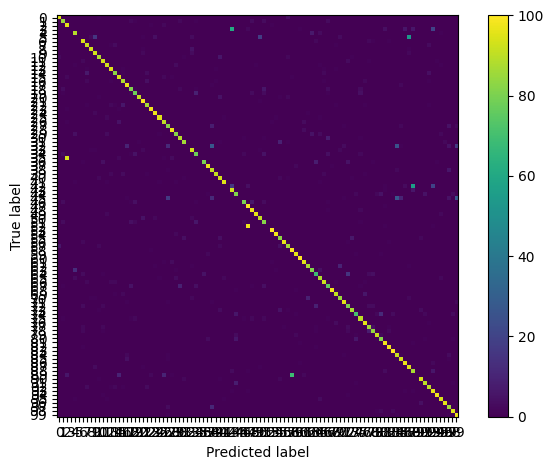

In [44]:
with open('cm_numpy_lora_cifar100.npy', 'wb') as f:
    np.save(f, cm.result().numpy())

default_cm_image_creator(cm.result())
print('CM Lora  CIFAR-100')

In [14]:
config = {
    "learning_rate": 0.00001,
    "weight_decay": 5.e-4,
    "batch_size": 64,
    "optimizer": "Adam",
    "architecture": "VGG19",
    "dataset": f'{dataset_name}',
    "epochs": 300,
    "lr_schedule": "ReduceLROnPlateau - Patience 4 - Monitoring Val Accuracy",
    "description": "Testing CIFAR-100 splited into 10 tasks."
}

tasks = [i for i in range(n_split_experiences)]
acc_by_task = {i: 0 for i in range(n_split_experiences)}
results_diff_models = {}
best_model = {}
cms = {}
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cm = ConfusionMatrix(num_classes=total_number_classes)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


for model_type in ['vgg19']:
    bz=config['batch_size']
        
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
                   
    model = models.vgg19_bn(weights="IMAGENET1K_V1")
    model.classifier[6] = nn.Linear(4096, total_number_classes)
    model = equip_vgg_with_lora(model, masks, total_number_classes)
    #model = convert_vgg_to_sena(model, masks, total_number_classes)
            
    print(f'model: {model_type}')
    
    for task in [9]:
        epoch_losses = {'train_acc': [], 'train_loss': [], 'test_acc': [], 'test_loss': []}

        model.to('cpu')
        model.change_to_task(task)
        model.to(device)
        print(40*'-', f'TASK_{task}', 40*'-')
    
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
        lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=4, verbose=True)
        
        early_stop = 0
        best_val = 0
        for i in range(config['epochs']):
            g = torch.Generator()
            g.manual_seed(0)
            batch_gen = torch.utils.data.DataLoader(train_ds[task], 
                                                  batch_size=config['batch_size'], 
                                                  shuffle=True, 
                                                  num_workers=1,
                                                  )
            print(f'Training task {task} in epoch {i}. Batch size: {bz}.')
            count = 0
            total_loss = .0
            total_hit = 0
            for batch in tqdm(batch_gen):
                sample = batch[0].to(device)
                target = batch[1]
                target_onehot = F.one_hot(target, num_classes=total_number_classes).to(torch.float).to(device)

                y_hat = model(sample)
    
                # Compute the loss
                loss_training = criterion(y_hat, target_onehot)            
                
                # Backpropagation and optimization
                optimizer.zero_grad()
                loss_training.backward()
                optimizer.step()
                
                total_loss += loss_training
                total_hit += sum(np.argmax(y_hat.cpu().detach().numpy(), axis=1) == target.numpy())

                sample.to('cpu')
                target_onehot.to('cpu')
                del sample, target_onehot
                gc.collect()
                torch.cuda.empty_cache()
                
            # Evaluate in test DS after each epoch
            with torch.no_grad():
                batch_gen_test = torch.utils.data.DataLoader(test_ds[task], 
                                                  batch_size=config['batch_size'], 
                                                  shuffle=True, 
                                                  num_workers=1,
                                                  )
                model.eval()
                test_loss = 0.
                acc = 0.
                for batch_test in tqdm(batch_gen_test):
                    sample = batch_test[0].to(device)
                    target = batch_test[1]
                    target_onehot = F.one_hot(target, num_classes=total_number_classes).to(torch.float).to(device)
        
                    y_hat = model(sample)
                    cpu_inference = y_hat.argmax(axis=1)
                    
                    test_loss += criterion(y_hat, target_onehot)
                    acc += sum(cpu_inference.cpu() == target).item()

                    sample.to('cpu')
                    target_onehot.to('cpu')
                    del sample, target_onehot
                    gc.collect()
                    torch.cuda.empty_cache()

                test_loss = (test_loss/len(batch_gen_test)).cpu()
                acc = acc/len(test_ds[task])
                lr_scheduler.step(acc)
                model.train()
            
            epoch_losses['train_acc'].append(total_hit/(len(batch_gen)*bz))
            epoch_losses['train_loss'].append((total_loss/len(batch_gen)).cpu().item())
            
            epoch_losses['test_acc'].append(acc)
            epoch_losses['test_loss'].append(test_loss.item())
    
            # if acc > (best_val+0.01):
            if acc > (best_val):
                model.to('cpu')
                best_model[f'{model_type}-{task}'] = deepcopy(model)
                model.to(device)
                best_val = acc
                early_stop = 0
    
            if early_stop > patience:
                break
            
            early_stop += 1

            
            print(f'Trainig acc: {total_hit/(len(batch_gen)*bz):.4}   //   Training loss: {(total_loss/len(batch_gen)):.4f}   //   Test acc: {acc:.4f}   //   Test loss: {test_loss:.4f}')
            print(f'early_stop: {early_stop}  /   Best acc: {best_val}')
            del batch_gen, batch_gen_test
            gc.collect()
            torch.cuda.empty_cache()

        model.to('cpu')
        del model
        model = best_model[f'{model_type}-{task}']
        del best_model[f'{model_type}-{task}']
        model.eval()
        model.to(device)

        with torch.no_grad():
            batch_gen_test = torch.utils.data.DataLoader(test_ds[task], 
                                              batch_size=bz, 
                                              shuffle=True, 
                                              num_workers=1,
                                              )
            for batch_test in tqdm(batch_gen_test):
                sample = batch_test[0].to(device)
                target = batch_test[1]
    
                y_hat = model(sample)
    
                cpu_inference = y_hat.argmax(axis=1)
    
                cm.update(target, cpu_inference.cpu())
                
            del batch_gen, batch_gen_test
            gc.collect()
            torch.cuda.empty_cache()

        gc.collect()
        torch.cuda.empty_cache()
        
        if task == 0:
            model.freeze_main_params()
        else:
            model.change_to_task(0)
        
        # results_diff_models[f'{model_type}-{task}'] = pd.DataFrame(epoch_losses)

        # del criterion, optimizer, lr_scheduler 
        gc.collect()
        torch.cuda.empty_cache()

model: vgg19
[WARM] The model is already prepared to task 9.
---------------------------------------- TASK_9 ----------------------------------------
Training task 9 in epoch 0. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.4662   //   Training loss: 4.2796   //   Test acc: 0.5090   //   Test loss: 4.1462
early_stop: 1  /   Best acc: 0.509
Training task 9 in epoch 1. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.5512   //   Training loss: 4.1092   //   Test acc: 0.6110   //   Test loss: 4.0581
early_stop: 1  /   Best acc: 0.611
Training task 9 in epoch 2. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.24it/s]


Trainig acc: 0.6473   //   Training loss: 4.0132   //   Test acc: 0.6770   //   Test loss: 3.9716
early_stop: 1  /   Best acc: 0.677
Training task 9 in epoch 3. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.33it/s]


Trainig acc: 0.6966   //   Training loss: 3.9520   //   Test acc: 0.7220   //   Test loss: 3.9245
early_stop: 1  /   Best acc: 0.722
Training task 9 in epoch 4. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


Trainig acc: 0.7338   //   Training loss: 3.9057   //   Test acc: 0.7440   //   Test loss: 3.8989
early_stop: 1  /   Best acc: 0.744
Training task 9 in epoch 5. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.25it/s]


Trainig acc: 0.7664   //   Training loss: 3.8642   //   Test acc: 0.7740   //   Test loss: 3.8614
early_stop: 1  /   Best acc: 0.774
Training task 9 in epoch 6. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.7903   //   Training loss: 3.8404   //   Test acc: 0.7820   //   Test loss: 3.8504
early_stop: 1  /   Best acc: 0.782
Training task 9 in epoch 7. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


Trainig acc: 0.7987   //   Training loss: 3.8302   //   Test acc: 0.7840   //   Test loss: 3.8408
early_stop: 1  /   Best acc: 0.784
Training task 9 in epoch 8. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.39it/s]


Trainig acc: 0.8121   //   Training loss: 3.8141   //   Test acc: 0.7960   //   Test loss: 3.8327
early_stop: 1  /   Best acc: 0.796
Training task 9 in epoch 9. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.36it/s]


Trainig acc: 0.8184   //   Training loss: 3.8051   //   Test acc: 0.8040   //   Test loss: 3.8241
early_stop: 1  /   Best acc: 0.804
Training task 9 in epoch 10. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.8295   //   Training loss: 3.7930   //   Test acc: 0.8100   //   Test loss: 3.8164
early_stop: 1  /   Best acc: 0.81
Training task 9 in epoch 11. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.37it/s]


Trainig acc: 0.8307   //   Training loss: 3.7923   //   Test acc: 0.8120   //   Test loss: 3.8156
early_stop: 1  /   Best acc: 0.812
Training task 9 in epoch 12. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.30it/s]


Trainig acc: 0.8445   //   Training loss: 3.7830   //   Test acc: 0.8080   //   Test loss: 3.8171
early_stop: 2  /   Best acc: 0.812
Training task 9 in epoch 13. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


Trainig acc: 0.843   //   Training loss: 3.7773   //   Test acc: 0.8160   //   Test loss: 3.8116
early_stop: 1  /   Best acc: 0.816
Training task 9 in epoch 14. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.14it/s]


Trainig acc: 0.8503   //   Training loss: 3.7699   //   Test acc: 0.8220   //   Test loss: 3.8052
early_stop: 1  /   Best acc: 0.822
Training task 9 in epoch 15. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:18<00:00,  1.13s/it]


Trainig acc: 0.8568   //   Training loss: 3.7679   //   Test acc: 0.8170   //   Test loss: 3.8105
early_stop: 2  /   Best acc: 0.822
Training task 9 in epoch 16. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:24<00:00,  1.51s/it]


Trainig acc: 0.8631   //   Training loss: 3.7574   //   Test acc: 0.8240   //   Test loss: 3.8020
early_stop: 1  /   Best acc: 0.824
Training task 9 in epoch 17. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


Trainig acc: 0.8669   //   Training loss: 3.7515   //   Test acc: 0.8230   //   Test loss: 3.7988
early_stop: 2  /   Best acc: 0.824
Training task 9 in epoch 18. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


Trainig acc: 0.8671   //   Training loss: 3.7530   //   Test acc: 0.8410   //   Test loss: 3.7915
early_stop: 1  /   Best acc: 0.841
Training task 9 in epoch 19. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


Trainig acc: 0.8685   //   Training loss: 3.7518   //   Test acc: 0.8260   //   Test loss: 3.8001
early_stop: 2  /   Best acc: 0.841
Training task 9 in epoch 20. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


Trainig acc: 0.8843   //   Training loss: 3.7346   //   Test acc: 0.8370   //   Test loss: 3.7921
early_stop: 3  /   Best acc: 0.841
Training task 9 in epoch 21. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.26it/s]


Trainig acc: 0.8857   //   Training loss: 3.7338   //   Test acc: 0.8350   //   Test loss: 3.7895
early_stop: 4  /   Best acc: 0.841
Training task 9 in epoch 22. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


Trainig acc: 0.8853   //   Training loss: 3.7350   //   Test acc: 0.8460   //   Test loss: 3.7846
early_stop: 1  /   Best acc: 0.846
Training task 9 in epoch 23. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


Trainig acc: 0.8807   //   Training loss: 3.7412   //   Test acc: 0.8390   //   Test loss: 3.7870
early_stop: 2  /   Best acc: 0.846
Training task 9 in epoch 24. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


Trainig acc: 0.8916   //   Training loss: 3.7290   //   Test acc: 0.8440   //   Test loss: 3.7828
early_stop: 3  /   Best acc: 0.846
Training task 9 in epoch 25. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


Trainig acc: 0.8936   //   Training loss: 3.7253   //   Test acc: 0.8400   //   Test loss: 3.7885
early_stop: 4  /   Best acc: 0.846
Training task 9 in epoch 26. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


Trainig acc: 0.8904   //   Training loss: 3.7299   //   Test acc: 0.8420   //   Test loss: 3.7876
early_stop: 5  /   Best acc: 0.846
Training task 9 in epoch 27. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.34it/s]


Epoch 00028: reducing learning rate of group 0 to 1.0000e-06.
Trainig acc: 0.8962   //   Training loss: 3.7213   //   Test acc: 0.8380   //   Test loss: 3.7862
early_stop: 6  /   Best acc: 0.846
Training task 9 in epoch 28. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.29it/s]


Trainig acc: 0.8966   //   Training loss: 3.7230   //   Test acc: 0.8420   //   Test loss: 3.7859
early_stop: 7  /   Best acc: 0.846
Training task 9 in epoch 29. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


Trainig acc: 0.9039   //   Training loss: 3.7150   //   Test acc: 0.8480   //   Test loss: 3.7816
early_stop: 1  /   Best acc: 0.848
Training task 9 in epoch 30. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


Trainig acc: 0.9033   //   Training loss: 3.7151   //   Test acc: 0.8480   //   Test loss: 3.7780
early_stop: 2  /   Best acc: 0.848
Training task 9 in epoch 31. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.31it/s]


Trainig acc: 0.9021   //   Training loss: 3.7176   //   Test acc: 0.8520   //   Test loss: 3.7794
early_stop: 1  /   Best acc: 0.852
Training task 9 in epoch 32. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


Trainig acc: 0.9023   //   Training loss: 3.7167   //   Test acc: 0.8420   //   Test loss: 3.7829
early_stop: 2  /   Best acc: 0.852
Training task 9 in epoch 33. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.17it/s]


Trainig acc: 0.9031   //   Training loss: 3.7192   //   Test acc: 0.8410   //   Test loss: 3.7853
early_stop: 3  /   Best acc: 0.852
Training task 9 in epoch 34. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


Trainig acc: 0.9037   //   Training loss: 3.7139   //   Test acc: 0.8420   //   Test loss: 3.7867
early_stop: 4  /   Best acc: 0.852
Training task 9 in epoch 35. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.06it/s]


Trainig acc: 0.9005   //   Training loss: 3.7156   //   Test acc: 0.8440   //   Test loss: 3.7799
early_stop: 5  /   Best acc: 0.852
Training task 9 in epoch 36. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.35it/s]


Epoch 00037: reducing learning rate of group 0 to 1.0000e-07.
Trainig acc: 0.9074   //   Training loss: 3.7122   //   Test acc: 0.8500   //   Test loss: 3.7759
early_stop: 6  /   Best acc: 0.852
Training task 9 in epoch 37. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.34it/s]


Trainig acc: 0.9011   //   Training loss: 3.7184   //   Test acc: 0.8410   //   Test loss: 3.7884
early_stop: 7  /   Best acc: 0.852
Training task 9 in epoch 38. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.35it/s]


Trainig acc: 0.9092   //   Training loss: 3.7102   //   Test acc: 0.8440   //   Test loss: 3.7811
early_stop: 8  /   Best acc: 0.852
Training task 9 in epoch 39. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


Trainig acc: 0.9059   //   Training loss: 3.7106   //   Test acc: 0.8460   //   Test loss: 3.7825
early_stop: 9  /   Best acc: 0.852
Training task 9 in epoch 40. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.9096   //   Training loss: 3.7113   //   Test acc: 0.8440   //   Test loss: 3.7783
early_stop: 10  /   Best acc: 0.852
Training task 9 in epoch 41. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.32it/s]


Trainig acc: 0.9068   //   Training loss: 3.7117   //   Test acc: 0.8550   //   Test loss: 3.7751
early_stop: 1  /   Best acc: 0.855
Training task 9 in epoch 42. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.28it/s]


Trainig acc: 0.9088   //   Training loss: 3.7147   //   Test acc: 0.8520   //   Test loss: 3.7759
early_stop: 2  /   Best acc: 0.855
Training task 9 in epoch 43. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.22it/s]


Trainig acc: 0.9082   //   Training loss: 3.7132   //   Test acc: 0.8470   //   Test loss: 3.7775
early_stop: 3  /   Best acc: 0.855
Training task 9 in epoch 44. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


Trainig acc: 0.9092   //   Training loss: 3.7108   //   Test acc: 0.8520   //   Test loss: 3.7789
early_stop: 4  /   Best acc: 0.855
Training task 9 in epoch 45. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


Trainig acc: 0.9053   //   Training loss: 3.7111   //   Test acc: 0.8540   //   Test loss: 3.7777
early_stop: 5  /   Best acc: 0.855
Training task 9 in epoch 46. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.38it/s]


Epoch 00047: reducing learning rate of group 0 to 1.0000e-08.
Trainig acc: 0.907   //   Training loss: 3.7110   //   Test acc: 0.8460   //   Test loss: 3.7831
early_stop: 6  /   Best acc: 0.855
Training task 9 in epoch 47. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.9076   //   Training loss: 3.7130   //   Test acc: 0.8540   //   Test loss: 3.7743
early_stop: 7  /   Best acc: 0.855
Training task 9 in epoch 48. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Trainig acc: 0.8972   //   Training loss: 3.7207   //   Test acc: 0.8500   //   Test loss: 3.7754
early_stop: 8  /   Best acc: 0.855
Training task 9 in epoch 49. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


Trainig acc: 0.908   //   Training loss: 3.7103   //   Test acc: 0.8530   //   Test loss: 3.7789
early_stop: 9  /   Best acc: 0.855
Training task 9 in epoch 50. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.06s/it]


Trainig acc: 0.907   //   Training loss: 3.7150   //   Test acc: 0.8540   //   Test loss: 3.7779
early_stop: 10  /   Best acc: 0.855
Training task 9 in epoch 51. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


Trainig acc: 0.9049   //   Training loss: 3.7163   //   Test acc: 0.8480   //   Test loss: 3.7774
early_stop: 11  /   Best acc: 0.855
Training task 9 in epoch 52. Batch size: 64.


100%|███████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.92it/s]


[INFO] Model prepared to task 0.


In [15]:
cm.result().numpy()

array([[93,  0,  0, ...,  0,  0,  0],
       [ 0, 85,  0, ...,  0,  0,  0],
       [ 0,  0, 64, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 84,  0,  0],
       [ 0,  0,  0, ...,  0, 88,  0],
       [ 0,  0,  0, ...,  0,  0, 93]], dtype=int64)

CM SENA  CIFAR-100


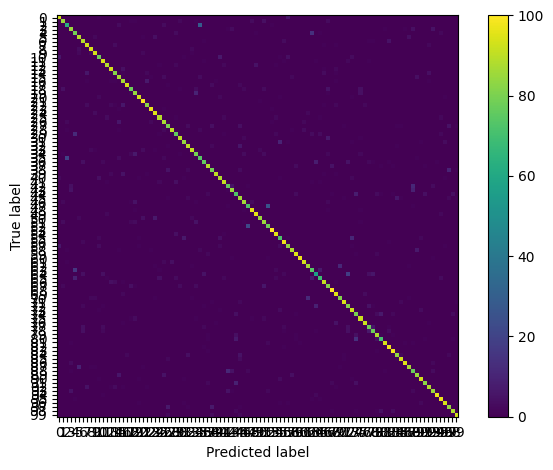

In [16]:
with open('cm_numpy_sena_cifar100.npy', 'wb') as f:
    np.save(f, cm.result().numpy())

default_cm_image_creator(cm.result())
print('CM SENA  CIFAR-100')

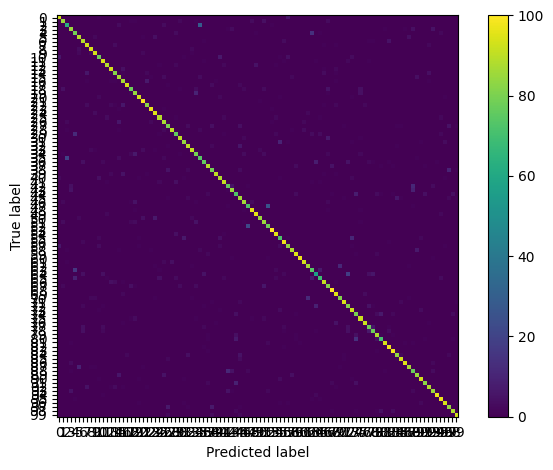

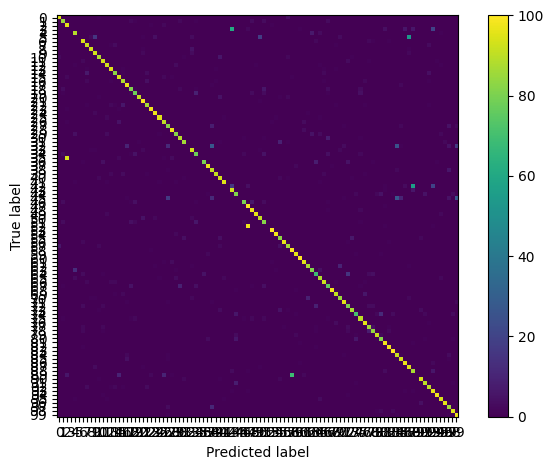

In [5]:
with open('cm_numpy_sena_cifar100.npy', 'rb') as f:
    loaded_data = np.load(f)

fig1=default_cm_image_creator(torch.tensor(loaded_data))
fig1.savefig('sena_cifar100.png', dpi=300, transparent=True)

with open('cm_numpy_lora_cifar100.npy', 'rb') as f:
    loaded_data = np.load(f)

fig1=default_cm_image_creator(torch.tensor(loaded_data))
fig1.savefig('lora_cifar100.png', dpi=300, transparent=True)

In [43]:
with open(results_file_name, 'wb') as f:
    pd.to_pickle(results_diff_models, f)

In [55]:
for key in best_model:
    print(key)
    torch.save(best_model[key], f'checkpoints/{key}-{dataset_name}.pth')

lora-0
lora-1
sena-0
sena-1


##### LoraCNN in First Task
+ Train for 158 epochs
+ Finish test acc: 0.8338
+ Best test acc: 0.848 in epoch number 148

##### LoraCNN in Second Task
+ Train for 94 epochs
+ Reached out test acc 0.80 in epoch 40
+ Finish test acc: 0.7670
+ Best test acc: 0.825 in epoch number 30

##### SenaCNN in First Task
+ Train for 141 epochs
+ Finish test acc: 0.8348
+ Best test acc: 0.8366 in epoch number 131

##### SenaCNN in Second Task
+ Train for 89 epochs
+ Reached out test acc 0.80 in epoch 22
+ Finish test acc: 0.8654
+ Best test acc: 0.8708 in epoch number 79

In [26]:
model = torch.load('checkpoints/lora-0-cifar-10.pth')

In [45]:
with open(results_file_name, 'rb') as f:
    results_diff_models = pd.read_pickle(f)


### Plot results of ACC and Loss

##### Analizing LoraCNN

+ Task 0

In the first task the best accuracy in test data set reached out by LoraCNN was 0.8480


<Axes: title={'center': 'Test Loss LoraCNN in Task 0'}>

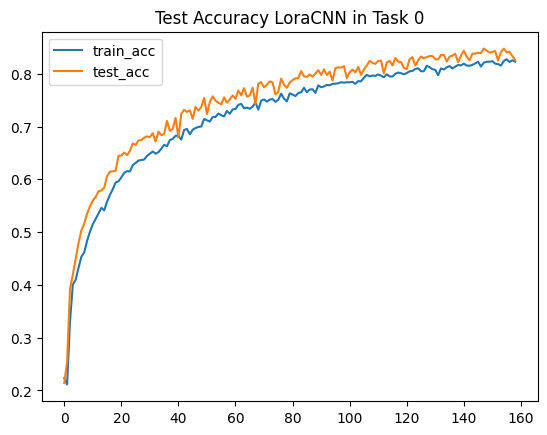

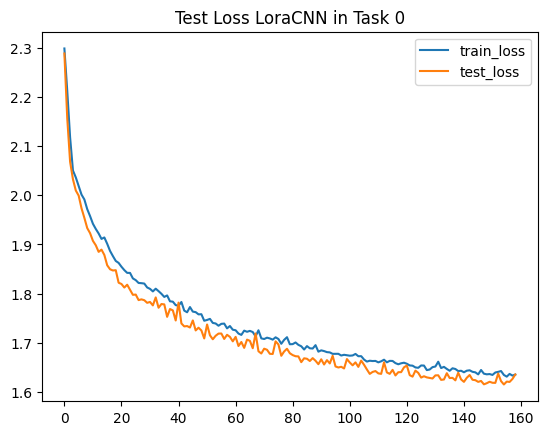

In [41]:
loracnn_0_acc = results_diff_models['lora-0'][['train_acc', 'test_acc']]
loracnn_0_loss = results_diff_models['lora-0'][['train_loss', 'test_loss']]

loracnn_0_acc.plot(title=f'Test Accuracy LoraCNN in Task 0')
print(f'In the first task the best accuracy in test data set reached out by LoraCNN was {loracnn_0_acc["test_acc"].max():.4f}')

loracnn_0_loss.plot(title=f'Test Loss LoraCNN in Task 0')

+ Task 1

In the second task the best accuracy in test data set reached out by LoraCNN was 0.8250


<Axes: title={'center': 'Test Loss LoraCNN in Task 1'}>

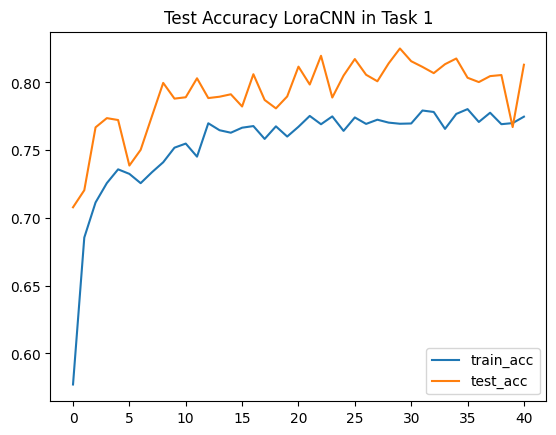

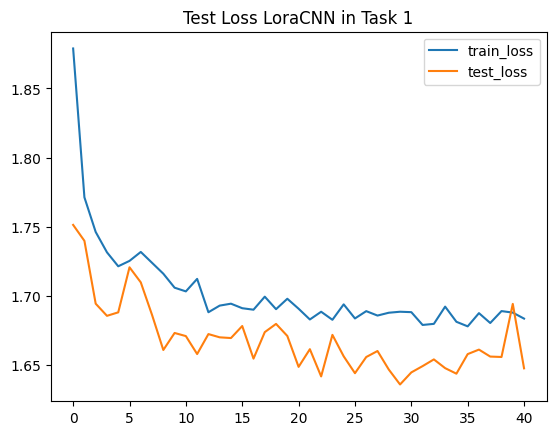

In [47]:
loracnn_1_acc = results_diff_models['lora-1'][['train_acc', 'test_acc']]
loracnn_1_loss = results_diff_models['lora-1'][['train_loss', 'test_loss']]

loracnn_1_acc.plot(title=f'Test Accuracy LoraCNN in Task 1')
print(f'In the second task the best accuracy in test data set reached out by LoraCNN was {loracnn_1_acc["test_acc"].max():.4f}')

loracnn_1_loss.plot(title=f'Test Loss LoraCNN in Task 1')

### Comparsion in number of parameters added to learn a new task

##### Analyzing all parameters including Fully Connected Layers

In [50]:
model = SenaCNN_32(masks)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
sena_init_params = params

model.freeze_main_params()
model.change_to_task(1)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
sena_after_freeze_params = params


model = LoraCNN_32(masks)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
lora_init_params = params

model.freeze_main_params()
model.change_to_task(1)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
lora_after_freeze_params = params

print(80*'-', '\n')
print(f'In SenaCNN after first training, each new training has a gain of {(((sena_init_params-sena_after_freeze_params)/sena_init_params)*100):.2f}%')
print(f'In LoraCNN after first training, each new training has a gain of {(((lora_init_params-lora_after_freeze_params)/lora_init_params)*100):.2f}%')

Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
-------------------------------------------------------------------------------- 

In SenaCNN after first training, each new training has a gain of 0.37%
In LoraCNN after first training, each new training has a gain of 72.82%


##### Analyzing only paramaters of Conv Layers from models

In [52]:
model = SenaCNN_32(masks)
model_parameters = list(filter(lambda p: p[0].startswith('conv') and p[1].requires_grad, model.named_parameters()))
params = sum([np.prod(p[1].size()) for p in model_parameters])
sena_init_params = params

model.freeze_main_params()
model.change_to_task(1)
model_parameters = list(filter(lambda p: p[0].startswith('conv') and p[1].requires_grad, model.named_parameters()))
params = sum([np.prod(p[1].size()) for p in model_parameters])
sena_after_freeze_params = params


model = LoraCNN_32(masks)
model_parameters = list(filter(lambda p: p[0].startswith('conv') and p[1].requires_grad, model.named_parameters()))
params = sum([np.prod(p[1].size()) for p in model_parameters])
lora_init_params = params

model.freeze_main_params()
model.change_to_task(1)
model_parameters = list(filter(lambda p: p[0].startswith('conv') and p[1].requires_grad, model.named_parameters()))
params = sum([np.prod(p[1].size()) for p in model_parameters])
lora_after_freeze_params = params

print(80*'-', '\n')
print(f'In SenaCNN after first training, each new training has a gain of {(((sena_init_params-sena_after_freeze_params)/sena_init_params)*100):.2f}%')
print(f'In LoraCNN after first training, each new training has a gain of {(((lora_init_params-lora_after_freeze_params)/lora_init_params)*100):.2f}%')

Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
Changing the configuration to task 1. Remember to reinitialize the Optmizer
-------------------------------------------------------------------------------- 

In SenaCNN after first training, each new training has a gain of 15.47%
In LoraCNN after first training, each new training has a gain of 88.83%
